# Algoritmos Evolutivos & Aprendizado por Reforço

## Alunos

- João Vitor Vendemiato Fatoretto - 199944
- Natan Beltrão da Cunha Pevidor Carvalho - 184972

## Parte 1 - Algoritmos Evolutivos

Neste projeto, treinamos dois algoritmos diferentes para aprender a jogar o jogo Pacman ([código](https://gitlab.techniek.hva.nl/artificial-intelligence/pacman-contest-3)). Nesta primeira parte, treinamos um algoritmo evolutivo.

Como os fantasmas do jogo se comportam de forma aleatória, não é possível encontrar um caminho fixo para a vitória. Por isso, tentamos desenvolver um algoritmo que chegasse a uma estratégia ideal e não um caminho fixo. Para isso, nos inspiramos em Brandstetter & Ahmadi, 2012. Uma estratégia (implementada em [strategy.py](./strategy.py)) consiste em 5 árvores, onde as folhas consistem em valores calculados a partir do estado do jogo e os outros nós são operadores binários. Cada árvore está associada a uma ação (4 direções ou ficar parado) e a ação a ser tomada é a que tiver maior valor dentre as ações possíveis no estado atual.

### Valores

Os valores (implementados em [values.py](./values.py)) possíveis para as folhas de uma árvore são:

- Coordenadas do Pacman
- Quantidade, Distância e Coordenadas do Fantasma não-comestível mais próximo
- Quantidade, Distância e Coordenadas do Fantasma comestível mais próximo
- Quantidade, Distância e Coordenadas da comida mais próxima
- Quantidade, Distância e Coordenadas da cápsula mais próxima
- Valores constantes: -1, 0, 0.1, 1, 10

### Operadores

Os operadores (implementados em [operators.py](./operators.py)) possíveis para os outros nós são:

- Subtração
- Adição
- Multiplicação
- Divisão (retorna 0 caso o divisor seja 0)
- Máximo
- Mínimo

### Geração Inicial

Para criar a primeira geração, implementamos em [strategyGenerator.py](./strategyGenerator.py) um mecanismo de geração de estratégia, onde a chance de um nó ser uma folha aumenta conforme sua profundidade, de forma a gerar árvores com tamanhos variados mas que tendam a não serem muito grandes. Cada geração possui 200 estratégias.

In [1]:
import strategyGenerator

def createGeneration(size=200):
    generation = []
    for _ in range(size):
        generation.append(strategyGenerator.generateStrategy())
    return generation

generation = createGeneration()

Para cada estratégia em uma geração, executamos 5 jogos de forma a levar em conta a aleatoriedade do movimento dos fantasmas. A medida de fitness de cada estratégia é a média dos scores obtidos nesses 5 jogos.

Ao final de cada execução, utilizamos o método da roleta utilizando a raiz quadrada da função de fitness (com windowing para evitar raízes negativas). Das para selecionar os membros para a próxima geração, dos quais:

- 15% serão estratégias sobreviventes, simplesmente replicadas da geração anterior
- 15% serão estratégias com alguma mutação
- 70% serão estratégias resultantes da reprodução de duas estratégias da geração anterior, com crossover

### Mutação

As mutações possíveis, implementadas em [generationReproduction.py](./generationReproduction.py), são:

- A geração de uma nova árvore para substituir uma das 5 árvores da estratégia
- A troca de posição entre duas árvores já existentes
- A troca de ramos entre duas árvores já existentes

### Crossover

O crossover, também implementado em [generationReproduction.py](./generationReproduction.py), seleciona as árvores novas a partir de 3 estratégias:

- Selecionar uma das árvores dentre as duas estratégias selecionadas para reprodução
- Selecionar uma das árvores dentre as duas estratégias selecionadas para reprodução e trocar um dos seus ramos pelo ramo da outa árvore
- Fundir as duas árvores anteriores em uma nova raiz comum selecionada aleatoriamente

Executamos, então, 20 gerações para cada layout do jogo, iniciando com smallClassic:

In [2]:
import generationReproduction
import globalValues
import numpy as np
import pacman
import time

def selectByRoulette(gen, scores):
    probability = np.sqrt(np.array(scores) - min(scores))
    probability = probability / np.sum(probability)
    return np.random.choice(gen, p=probability)

def runGeneticLearning(layout, generation, iterations=20):
    startTime = time.time()
    generationAverage = []
    generationMax = []
    generationMin = []
    winningStrategy = None

    for i in range(iterations):
        averageScore = []

        for strategy in generation:
            globalValues.strategy = strategy
            args = pacman.readCommand(["-l", layout, "-p", "GeneticAgent", "-n", "5", "-q"])
            games = pacman.runGames(**args)
            scores = [g.state.getScore() for g in games]
            averageScore.append(sum(scores)/len(scores))

        generationAverage.append(sum(averageScore)/len(averageScore))
        generationMax.append(max(averageScore))
        generationMin.append(min(averageScore))
        winningStrategy = generation[averageScore.index(max(averageScore))]

        if i < iterations - 1:
            newGeneration = []
            for _ in range(round(1.5 * len(generation) / 10)):
                newGeneration.append(selectByRoulette(generation, averageScore))
            for _ in range(round(1.5 * len(generation) / 10)):
                newGeneration.append(generationReproduction.mutate(selectByRoulette(generation, averageScore)))
            for _ in range(len(generation) - len(newGeneration)):
                firstStrategy = selectByRoulette(generation, averageScore)
                secondStrategy = selectByRoulette(generation, averageScore)
                newGeneration.append(generationReproduction.crossover(firstStrategy, secondStrategy))
    
    print("Execution time: %s seconds" % (time.time() - startTime))
    return (generationAverage, generationMax, generationMin, winningStrategy)

generationAverage, generationMax, generationMin, smallClassicStrategy = runGeneticLearning("smallClassic", generation)

layout:  smallClassic
Pacman died! Score: -518
Pacman died! Score: -518
Pacman died! Score: -545
Pacman died! Score: -516
Pacman died! Score: -542
Average Score: -527.8
Scores:        -518.0, -518.0, -545.0, -516.0, -542.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -448
Pacman died! Score: -468
Pacman died! Score: -433
Pacman died! Score: -427
Pacman died! Score: -424
Average Score: -440.0
Scores:        -448.0, -468.0, -433.0, -427.0, -424.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -586
Pacman died! Score: -439
Pacman died! Score: -441
Pacman died! Score: -459
Pacman died! Score: -445
Average Score: -474.0
Scores:        -586.0, -439.0, -441.0, -459.0, -445.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -494
Pacman died! Score: -445
Pacman died! Score: -437
Pacman died! Score: -435

Pacman died! Score: -578
Pacman died! Score: -531
Pacman died! Score: -520
Pacman died! Score: -567
Pacman died! Score: -538
Average Score: -546.8
Scores:        -578.0, -531.0, -520.0, -567.0, -538.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -541
Pacman died! Score: -496
Pacman died! Score: -463
Pacman died! Score: -438
Pacman died! Score: -469
Average Score: -481.4
Scores:        -541.0, -496.0, -463.0, -438.0, -469.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -503
Pacman died! Score: -545
Pacman died! Score: -490
Pacman died! Score: -504
Pacman died! Score: -485
Average Score: -505.4
Scores:        -503.0, -545.0, -490.0, -504.0, -485.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -439
Pacman died! Score: -470
Pacman died! Score: -469
Pacman died! Score: -457
Pacman died! Score: -

Pacman died! Score: -435
Pacman died! Score: -412
Pacman died! Score: -417
Average Score: -436.4
Scores:        -457.0, -461.0, -435.0, -412.0, -417.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -452
Pacman died! Score: -450
Pacman died! Score: -445
Pacman died! Score: -460
Pacman died! Score: -434
Average Score: -448.2
Scores:        -452.0, -450.0, -445.0, -460.0, -434.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -529
Pacman died! Score: -520
Pacman died! Score: -549
Pacman died! Score: -570
Average Score: -536.0
Scores:        -512.0, -529.0, -520.0, -549.0, -570.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -479
Pacman died! Score: -479
Pacman died! Score: -487
Pacman died! Score: -480
Pacman died! Score: -480
Average Score: -481.0
Scores:        -479.0, -

Pacman died! Score: -547
Pacman died! Score: -538
Average Score: -530.6
Scores:        -529.0, -523.0, -516.0, -547.0, -538.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -439
Pacman died! Score: -431
Pacman died! Score: -461
Pacman died! Score: -386
Pacman died! Score: -512
Average Score: -445.8
Scores:        -439.0, -431.0, -461.0, -386.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -482
Pacman died! Score: -537
Pacman died! Score: -419
Pacman died! Score: -446
Pacman died! Score: -487
Average Score: -474.2
Scores:        -482.0, -537.0, -419.0, -446.0, -487.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -518
Pacman died! Score: -534
Pacman died! Score: -518
Pacman died! Score: -569
Pacman died! Score: -519
Average Score: -531.6
Scores:        -518.0, -534.0, -518.0, -569.0, -5

Pacman died! Score: -380
Pacman died! Score: -381
Pacman died! Score: -376
Pacman died! Score: -372
Pacman died! Score: -374
Average Score: -376.6
Scores:        -380.0, -381.0, -376.0, -372.0, -374.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -473
Pacman died! Score: -504
Pacman died! Score: -471
Pacman died! Score: -404
Pacman died! Score: -458
Average Score: -462.0
Scores:        -473.0, -504.0, -471.0, -404.0, -458.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -485
Pacman died! Score: -474
Pacman died! Score: -468
Pacman died! Score: -468
Pacman died! Score: -470
Average Score: -473.0
Scores:        -485.0, -474.0, -468.0, -468.0, -470.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -411
Pacman died! Score: -475
Pacman died! Score: -427
Pacman died! Score: -425
Pacman died! Score: -

Pacman died! Score: -552
Pacman died! Score: -526
Pacman died! Score: -556
Pacman died! Score: -512
Pacman died! Score: -545
Average Score: -538.2
Scores:        -552.0, -526.0, -556.0, -512.0, -545.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -453
Pacman died! Score: -583
Pacman died! Score: -415
Pacman died! Score: -448
Pacman died! Score: -422
Average Score: -464.2
Scores:        -453.0, -583.0, -415.0, -448.0, -422.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -451
Pacman died! Score: -435
Pacman died! Score: -438
Pacman died! Score: -467
Pacman died! Score: -528
Average Score: -463.8
Scores:        -451.0, -435.0, -438.0, -467.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -474
Pacman died! Score: -385
Pacman died! Score: -404
Pacman died! Score: -385
Pacman died! Score: -

Pacman died! Score: -405
Pacman died! Score: -445
Pacman died! Score: -468
Average Score: -430.8
Scores:        -421.0, -415.0, -405.0, -445.0, -468.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -453
Pacman died! Score: -442
Pacman died! Score: -438
Pacman died! Score: -458
Pacman died! Score: -433
Average Score: -444.8
Scores:        -453.0, -442.0, -438.0, -458.0, -433.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -441
Pacman died! Score: -516
Pacman died! Score: -441
Pacman died! Score: -448
Pacman died! Score: -455
Average Score: -460.2
Scores:        -441.0, -516.0, -441.0, -448.0, -455.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -437
Pacman died! Score: -466
Pacman died! Score: -468
Pacman died! Score: -430
Pacman died! Score: -438
Average Score: -447.8
Scores:        -437.0, -

Pacman died! Score: -519
Pacman died! Score: -513
Average Score: -532.8
Scores:        -570.0, -540.0, -522.0, -519.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -525
Pacman died! Score: -528
Pacman died! Score: -511
Pacman died! Score: -561
Pacman died! Score: -528
Average Score: -530.6
Scores:        -525.0, -528.0, -511.0, -561.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -477
Pacman died! Score: -466
Pacman died! Score: -459
Pacman died! Score: -462
Pacman died! Score: -471
Average Score: -467.0
Scores:        -477.0, -466.0, -459.0, -462.0, -471.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -501
Pacman died! Score: -565
Pacman died! Score: -555
Pacman died! Score: -525
Pacman died! Score: -502
Average Score: -529.6
Scores:        -501.0, -565.0, -555.0, -525.0, -5

Pacman died! Score: -569
Average Score: -519.6
Scores:        -510.0, -493.0, -524.0, -502.0, -569.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -382
Pacman died! Score: -452
Pacman died! Score: -459
Pacman died! Score: -414
Pacman died! Score: -459
Average Score: -433.2
Scores:        -382.0, -452.0, -459.0, -414.0, -459.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -466
Pacman died! Score: -441
Pacman died! Score: -433
Pacman died! Score: -474
Pacman died! Score: -452
Average Score: -453.2
Scores:        -466.0, -441.0, -433.0, -474.0, -452.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -539
Pacman died! Score: -557
Pacman died! Score: -519
Pacman died! Score: -543
Pacman died! Score: -512
Average Score: -534.0
Scores:        -539.0, -557.0, -519.0, -543.0, -512.0
Win Rate:      0/5 (

Pacman died! Score: -402
Pacman died! Score: -407
Pacman died! Score: -417
Pacman died! Score: -387
Pacman died! Score: -388
Average Score: -400.2
Scores:        -402.0, -407.0, -417.0, -387.0, -388.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -382
Pacman died! Score: -412
Pacman died! Score: -396
Pacman died! Score: -419
Pacman died! Score: -396
Average Score: -401.0
Scores:        -382.0, -412.0, -396.0, -419.0, -396.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -462
Pacman died! Score: -497
Pacman died! Score: -411
Pacman died! Score: -403
Pacman died! Score: -487
Average Score: -452.0
Scores:        -462.0, -497.0, -411.0, -403.0, -487.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -417
Pacman died! Score: -454
Pacman died! Score: -460
Pacman died! Score: -464
Pacman died! Score: -

Pacman died! Score: -512
Pacman died! Score: -535
Pacman died! Score: -538
Pacman died! Score: -580
Average Score: -537.2
Scores:        -521.0, -512.0, -535.0, -538.0, -580.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -486
Pacman died! Score: -505
Pacman died! Score: -461
Pacman died! Score: -508
Pacman died! Score: -490
Average Score: -490.0
Scores:        -486.0, -505.0, -461.0, -508.0, -490.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -518
Pacman died! Score: -512
Pacman died! Score: -517
Pacman died! Score: -523
Average Score: -516.4
Scores:        -512.0, -518.0, -512.0, -517.0, -523.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -429
Pacman died! Score: -433
Pacman died! Score: -446
Pacman died! Score: -453
Pacman died! Score: -440
Average Score: -440.2

Pacman died! Score: -482
Pacman died! Score: -493
Pacman died! Score: -518
Pacman died! Score: -490
Average Score: -494.2
Scores:        -488.0, -482.0, -493.0, -518.0, -490.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -431
Pacman died! Score: -406
Pacman died! Score: -384
Pacman died! Score: -381
Pacman died! Score: -404
Average Score: -401.2
Scores:        -431.0, -406.0, -384.0, -381.0, -404.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -446
Pacman died! Score: -446
Pacman died! Score: -573
Pacman died! Score: -440
Pacman died! Score: -427
Average Score: -466.4
Scores:        -446.0, -446.0, -573.0, -440.0, -427.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -380
Pacman died! Score: -373
Pacman died! Score: -439
Pacman died! Score: -378
Pacman died! Score: -366
Average Score: -387.2

Pacman died! Score: -514
Pacman died! Score: -496
Pacman died! Score: -443
Pacman died! Score: -445
Average Score: -471.8
Scores:        -461.0, -514.0, -496.0, -443.0, -445.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -480
Pacman died! Score: -519
Pacman died! Score: -503
Pacman died! Score: -497
Pacman died! Score: -473
Average Score: -494.4
Scores:        -480.0, -519.0, -503.0, -497.0, -473.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -459
Pacman died! Score: -428
Pacman died! Score: -470
Pacman died! Score: -435
Pacman died! Score: -464
Average Score: -451.2
Scores:        -459.0, -428.0, -470.0, -435.0, -464.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -577
Pacman died! Score: -512
Pacman died! Score: -514
Pacman died! Score: -512
Average Score: -525.4

Pacman died! Score: -477
Pacman died! Score: -494
Pacman died! Score: -501
Pacman died! Score: -482
Average Score: -488.0
Scores:        -486.0, -477.0, -494.0, -501.0, -482.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -391
Pacman died! Score: -416
Pacman died! Score: -388
Pacman died! Score: -471
Pacman died! Score: -417
Average Score: -416.6
Scores:        -391.0, -416.0, -388.0, -471.0, -417.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -447
Pacman died! Score: -398
Pacman died! Score: -468
Pacman died! Score: -444
Pacman died! Score: -451
Average Score: -441.6
Scores:        -447.0, -398.0, -468.0, -444.0, -451.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -432
Pacman died! Score: -432
Pacman died! Score: -412
Pacman died! Score: -497
Pacman died! Score: -450
Average Score: -444.6

Pacman died! Score: -434
Pacman died! Score: -430
Pacman died! Score: -468
Pacman died! Score: -466
Average Score: -449.4
Scores:        -449.0, -434.0, -430.0, -468.0, -466.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -528
Pacman died! Score: -514
Pacman died! Score: -539
Pacman died! Score: -446
Pacman died! Score: -485
Average Score: -502.4
Scores:        -528.0, -514.0, -539.0, -446.0, -485.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -440
Pacman died! Score: -446
Pacman died! Score: -438
Pacman died! Score: -444
Pacman died! Score: -448
Average Score: -443.2
Scores:        -440.0, -446.0, -438.0, -444.0, -448.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -519
Pacman died! Score: -528
Pacman died! Score: -533
Pacman died! Score: -528
Pacman died! Score: -514
Average Score: -524.4

Pacman died! Score: -447
Pacman died! Score: -471
Pacman died! Score: -442
Pacman died! Score: -467
Average Score: -452.0
Scores:        -433.0, -447.0, -471.0, -442.0, -467.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -434
Pacman died! Score: -440
Pacman died! Score: -438
Pacman died! Score: -440
Pacman died! Score: -436
Average Score: -437.6
Scores:        -434.0, -440.0, -438.0, -440.0, -436.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -532
Pacman died! Score: -502
Pacman died! Score: -502
Pacman died! Score: -501
Pacman died! Score: -510
Average Score: -509.4
Scores:        -532.0, -502.0, -502.0, -501.0, -510.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -513
Pacman died! Score: -510
Pacman died! Score: -509
Pacman died! Score: -505
Pacman died! Score: -499
Average Score: -507.2

Pacman died! Score: -454
Pacman died! Score: -437
Pacman died! Score: -443
Pacman died! Score: -432
Average Score: -440.2
Scores:        -435.0, -454.0, -437.0, -443.0, -432.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -556
Pacman died! Score: -512
Pacman died! Score: -544
Pacman died! Score: -513
Pacman died! Score: -534
Average Score: -531.8
Scores:        -556.0, -512.0, -544.0, -513.0, -534.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -495
Pacman died! Score: -485
Pacman died! Score: -553
Pacman died! Score: -516
Pacman died! Score: -521
Average Score: -514.0
Scores:        -495.0, -485.0, -553.0, -516.0, -521.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -514
Pacman died! Score: -549
Pacman died! Score: -540
Pacman died! Score: -543
Pacman died! Score: -567
Average Score: -542.6

Pacman died! Score: -474
Pacman died! Score: -514
Pacman died! Score: -446
Pacman died! Score: -471
Average Score: -403.8
Scores:        -114.0, -474.0, -514.0, -446.0, -471.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -544
Pacman died! Score: -511
Pacman died! Score: -519
Pacman died! Score: -514
Pacman died! Score: -504
Average Score: -518.4
Scores:        -544.0, -511.0, -519.0, -514.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -443
Pacman died! Score: -440
Pacman died! Score: -534
Pacman died! Score: -484
Pacman died! Score: -459
Average Score: -472.0
Scores:        -443.0, -440.0, -534.0, -484.0, -459.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -542
Pacman died! Score: -555
Pacman died! Score: -529
Pacman died! Score: -525
Pacman died! Score: -515
Average Score: -533.2

Pacman died! Score: -520
Pacman died! Score: -512
Pacman died! Score: -527
Pacman died! Score: -568
Average Score: -528.6
Scores:        -516.0, -520.0, -512.0, -527.0, -568.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -499
Pacman died! Score: -497
Pacman died! Score: -499
Pacman died! Score: -528
Pacman died! Score: -504
Average Score: -505.4
Scores:        -499.0, -497.0, -499.0, -528.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -520
Pacman died! Score: -513
Pacman died! Score: -514
Pacman died! Score: -514
Pacman died! Score: -566
Average Score: -525.4
Scores:        -520.0, -513.0, -514.0, -514.0, -566.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -433
Pacman died! Score: -446
Pacman died! Score: -432
Pacman died! Score: -465
Pacman died! Score: -446
Average Score: -444.4

Pacman died! Score: -432
Pacman died! Score: -430
Pacman died! Score: -439
Pacman died! Score: -429
Average Score: -434.2
Scores:        -441.0, -432.0, -430.0, -439.0, -429.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -432
Pacman died! Score: -438
Pacman died! Score: -413
Pacman died! Score: -480
Pacman died! Score: -564
Average Score: -465.4
Scores:        -432.0, -438.0, -413.0, -480.0, -564.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -466
Pacman died! Score: -460
Pacman died! Score: -429
Pacman died! Score: -464
Pacman died! Score: -424
Average Score: -448.6
Scores:        -466.0, -460.0, -429.0, -464.0, -424.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -475
Pacman died! Score: -490
Pacman died! Score: -499
Pacman died! Score: -472
Pacman died! Score: -469
Average Score: -481.0

Pacman died! Score: -580
Pacman died! Score: -465
Pacman died! Score: -429
Pacman died! Score: -418
Average Score: -464.2
Scores:        -429.0, -580.0, -465.0, -429.0, -418.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -627
Pacman died! Score: -474
Pacman died! Score: -465
Pacman died! Score: -465
Pacman died! Score: -475
Average Score: -501.2
Scores:        -627.0, -474.0, -465.0, -465.0, -475.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -418
Pacman died! Score: -422
Pacman died! Score: -424
Pacman died! Score: -420
Pacman died! Score: -414
Average Score: -419.6
Scores:        -418.0, -422.0, -424.0, -420.0, -414.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -430
Pacman died! Score: -394
Pacman died! Score: -478
Pacman died! Score: -476
Pacman died! Score: -479
Average Score: -451.4

Pacman died! Score: -498
Pacman died! Score: -512
Pacman died! Score: -529
Average Score: -508.8
Scores:        -517.0, -488.0, -498.0, -512.0, -529.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -479
Pacman died! Score: -486
Pacman died! Score: -512
Pacman died! Score: -507
Pacman died! Score: -509
Average Score: -498.6
Scores:        -479.0, -486.0, -512.0, -507.0, -509.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -429
Pacman died! Score: -443
Pacman died! Score: -433
Pacman died! Score: -443
Pacman died! Score: -448
Average Score: -439.2
Scores:        -429.0, -443.0, -433.0, -443.0, -448.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -441
Pacman died! Score: -447
Pacman died! Score: -505
Pacman died! Score: -493
Pacman died! Score: -606
Average Score: -498.4
Scores:        -441.0, -

Pacman died! Score: -357
Pacman died! Score: -449
Average Score: -422.4
Scores:        -408.0, -449.0, -449.0, -357.0, -449.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -383
Pacman died! Score: -417
Pacman died! Score: -410
Pacman died! Score: -601
Pacman died! Score: -389
Average Score: -440.0
Scores:        -383.0, -417.0, -410.0, -601.0, -389.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -484
Pacman died! Score: -474
Pacman died! Score: -459
Pacman died! Score: -477
Pacman died! Score: -507
Average Score: -480.2
Scores:        -484.0, -474.0, -459.0, -477.0, -507.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -363
Pacman died! Score: -480
Pacman died! Score: -473
Pacman died! Score: -507
Pacman died! Score: -499
Average Score: -464.4
Scores:        -363.0, -480.0, -473.0, -507.0, -4

Pacman died! Score: -412
Pacman died! Score: -465
Pacman died! Score: -454
Pacman died! Score: -405
Pacman died! Score: -502
Average Score: -447.6
Scores:        -412.0, -465.0, -454.0, -405.0, -502.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -461
Pacman died! Score: -451
Pacman died! Score: -467
Pacman died! Score: -443
Pacman died! Score: -558
Average Score: -476.0
Scores:        -461.0, -451.0, -467.0, -443.0, -558.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -483
Pacman died! Score: -455
Pacman died! Score: -471
Pacman died! Score: -446
Pacman died! Score: -469
Average Score: -464.8
Scores:        -483.0, -455.0, -471.0, -446.0, -469.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -452
Pacman died! Score: -436
Pacman died! Score: -446
Pacman died! Score: -494
Pacman died! Score: -

Pacman died! Score: -406
Pacman died! Score: -384
Pacman died! Score: -396
Pacman died! Score: -403
Average Score: -398.6
Scores:        -404.0, -406.0, -384.0, -396.0, -403.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -493
Pacman died! Score: -507
Pacman died! Score: -560
Pacman died! Score: -530
Pacman died! Score: -522
Average Score: -522.4
Scores:        -493.0, -507.0, -560.0, -530.0, -522.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -530
Pacman died! Score: -434
Pacman died! Score: -422
Pacman died! Score: -432
Pacman died! Score: -420
Average Score: -447.6
Scores:        -530.0, -434.0, -422.0, -432.0, -420.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -453
Pacman died! Score: -454
Pacman died! Score: -479
Pacman died! Score: -471
Pacman died! Score: -420
Average Score: -455.4

Pacman died! Score: -438
Pacman died! Score: -443
Pacman died! Score: -483
Pacman died! Score: -510
Average Score: -468.8
Scores:        -470.0, -438.0, -443.0, -483.0, -510.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -567
Pacman died! Score: -545
Pacman died! Score: -518
Pacman died! Score: -516
Pacman died! Score: -513
Average Score: -531.8
Scores:        -567.0, -545.0, -518.0, -516.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -495
Pacman died! Score: -466
Pacman died! Score: -397
Pacman died! Score: -445
Pacman died! Score: -433
Average Score: -447.2
Scores:        -495.0, -466.0, -397.0, -445.0, -433.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -520
Pacman died! Score: -529
Pacman died! Score: -530
Pacman died! Score: -535
Pacman died! Score: -519
Average Score: -526.6

Pacman died! Score: -525
Pacman died! Score: -554
Pacman died! Score: -516
Pacman died! Score: -502
Average Score: -522.4
Scores:        -515.0, -525.0, -554.0, -516.0, -502.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -430
Pacman died! Score: -414
Pacman died! Score: -432
Pacman died! Score: -443
Pacman died! Score: -442
Average Score: -432.2
Scores:        -430.0, -414.0, -432.0, -443.0, -442.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -483
Pacman died! Score: -459
Pacman died! Score: -455
Pacman died! Score: -459
Pacman died! Score: -487
Average Score: -468.6
Scores:        -483.0, -459.0, -455.0, -459.0, -487.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -520
Pacman died! Score: -453
Pacman died! Score: -493
Pacman died! Score: -436
Pacman died! Score: -451
Average Score: -470.6

Pacman died! Score: -512
Pacman died! Score: -560
Pacman died! Score: -513
Pacman died! Score: -512
Average Score: -522.0
Scores:        -513.0, -512.0, -560.0, -513.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -394
Pacman died! Score: -512
Pacman died! Score: -407
Pacman died! Score: -338
Pacman died! Score: -358
Average Score: -401.8
Scores:        -394.0, -512.0, -407.0, -338.0, -358.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -466
Pacman died! Score: -473
Pacman died! Score: -490
Pacman died! Score: -492
Pacman died! Score: -519
Average Score: -488.0
Scores:        -466.0, -473.0, -490.0, -492.0, -519.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -469
Pacman died! Score: -470
Pacman died! Score: -422
Pacman died! Score: -451
Pacman died! Score: -463
Average Score: -455.0

Pacman died! Score: -547
Pacman died! Score: -502
Pacman died! Score: -525
Pacman died! Score: -539
Average Score: -526.4
Scores:        -519.0, -547.0, -502.0, -525.0, -539.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -497
Pacman died! Score: -440
Pacman died! Score: -455
Pacman died! Score: -440
Pacman died! Score: -495
Average Score: -465.4
Scores:        -497.0, -440.0, -455.0, -440.0, -495.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -535
Pacman died! Score: -535
Pacman died! Score: -541
Pacman died! Score: -531
Pacman died! Score: -512
Average Score: -530.8
Scores:        -535.0, -535.0, -541.0, -531.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -498
Pacman died! Score: -493
Pacman died! Score: -521
Pacman died! Score: -506
Pacman died! Score: -538
Average Score: -511.2

Pacman died! Score: -517
Pacman died! Score: -518
Pacman died! Score: -519
Pacman died! Score: -585
Average Score: -531.2
Scores:        -517.0, -517.0, -518.0, -519.0, -585.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -517
Pacman died! Score: -513
Pacman died! Score: -537
Pacman died! Score: -521
Pacman died! Score: -560
Average Score: -529.6
Scores:        -517.0, -513.0, -537.0, -521.0, -560.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -46
Pacman died! Score: -451
Pacman died! Score: -222
Pacman died! Score: -430
Pacman died! Score: -12
Average Score: -232.2
Scores:        -46.0, -451.0, -222.0, -430.0, -12.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -498
Pacman died! Score: -428
Pacman died! Score: -372
Pacman died! Score: -444
Pacman died! Score: -449
Average Score: -438.2
Sco

Pacman died! Score: -523
Pacman died! Score: -458
Average Score: -469.2
Scores:        -463.0, -460.0, -442.0, -523.0, -458.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -514
Pacman died! Score: -518
Pacman died! Score: -524
Pacman died! Score: -537
Pacman died! Score: -528
Average Score: -524.2
Scores:        -514.0, -518.0, -524.0, -537.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -433
Pacman died! Score: -428
Pacman died! Score: -473
Pacman died! Score: -421
Pacman died! Score: -417
Average Score: -434.4
Scores:        -433.0, -428.0, -473.0, -421.0, -417.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -464
Pacman died! Score: -521
Pacman died! Score: -492
Pacman died! Score: -505
Pacman died! Score: -458
Average Score: -488.0
Scores:        -464.0, -521.0, -492.0, -505.0, -4

Pacman died! Score: -449
Pacman died! Score: -475
Pacman died! Score: -398
Pacman died! Score: -211
Average Score: -384.2
Scores:        -388.0, -449.0, -475.0, -398.0, -211.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -386
Pacman died! Score: -491
Pacman died! Score: -422
Pacman died! Score: -407
Pacman died! Score: -442
Average Score: -429.6
Scores:        -386.0, -491.0, -422.0, -407.0, -442.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -440
Pacman died! Score: -440
Pacman died! Score: -434
Pacman died! Score: -508
Pacman died! Score: -432
Average Score: -450.8
Scores:        -440.0, -440.0, -434.0, -508.0, -432.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -403
Pacman died! Score: -468
Pacman died! Score: -443
Pacman died! Score: -421
Pacman died! Score: -429
Average Score: -432.8

Pacman died! Score: -488
Pacman died! Score: -448
Pacman died! Score: -442
Average Score: -473.2
Scores:        -500.0, -488.0, -488.0, -448.0, -442.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -522
Pacman died! Score: -421
Pacman died! Score: -432
Pacman died! Score: -588
Pacman died! Score: -454
Average Score: -483.4
Scores:        -522.0, -421.0, -432.0, -588.0, -454.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -524
Pacman died! Score: -493
Pacman died! Score: -549
Pacman died! Score: -498
Pacman died! Score: -542
Average Score: -521.2
Scores:        -524.0, -493.0, -549.0, -498.0, -542.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -510
Pacman died! Score: -463
Pacman died! Score: -495
Pacman died! Score: -431
Pacman died! Score: -428
Average Score: -465.4
Scores:        -510.0, -

Pacman died! Score: -460
Pacman died! Score: -429
Pacman died! Score: -427
Pacman died! Score: -461
Pacman died! Score: -455
Average Score: -446.4
Scores:        -460.0, -429.0, -427.0, -461.0, -455.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -423
Pacman died! Score: -446
Pacman died! Score: -446
Average Score: -437.8
Scores:        -446.0, -428.0, -423.0, -446.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -496
Pacman died! Score: -579
Pacman died! Score: -556
Pacman died! Score: -509
Pacman died! Score: -546
Average Score: -537.2
Scores:        -496.0, -579.0, -556.0, -509.0, -546.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -399
Pacman died! Score: -393
Pacman died! Score: -466
Pacman died! Score: -460
Pacman died! Score: -

Pacman died! Score: -464
Pacman died! Score: -453
Average Score: -450.0
Scores:        -455.0, -437.0, -441.0, -464.0, -453.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -559
Pacman died! Score: -457
Pacman died! Score: -584
Pacman died! Score: -593
Pacman died! Score: -511
Average Score: -540.8
Scores:        -559.0, -457.0, -584.0, -593.0, -511.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -575
Pacman died! Score: -511
Pacman died! Score: -513
Pacman died! Score: -582
Pacman died! Score: -523
Average Score: -540.8
Scores:        -575.0, -511.0, -513.0, -582.0, -523.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -429
Pacman died! Score: -401
Pacman died! Score: -401
Pacman died! Score: -364
Pacman died! Score: -480
Average Score: -415.0
Scores:        -429.0, -401.0, -401.0, -364.0, -4

Pacman died! Score: -415
Pacman died! Score: -501
Average Score: -419.0
Scores:        -479.0, -286.0, -414.0, -415.0, -501.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -533
Pacman died! Score: -512
Pacman died! Score: -608
Pacman died! Score: -540
Pacman died! Score: -529
Average Score: -544.4
Scores:        -533.0, -512.0, -608.0, -540.0, -529.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -535
Pacman died! Score: -501
Pacman died! Score: -532
Pacman died! Score: -509
Pacman died! Score: -540
Average Score: -523.4
Scores:        -535.0, -501.0, -532.0, -509.0, -540.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -449
Pacman died! Score: -511
Pacman died! Score: -469
Pacman died! Score: -443
Pacman died! Score: -478
Average Score: -470.0
Scores:        -449.0, -511.0, -469.0, -443.0, -4

Pacman died! Score: -498
Average Score: -455.0
Scores:        -432.0, -458.0, -452.0, -435.0, -498.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -513
Pacman died! Score: -621
Pacman died! Score: -537
Pacman died! Score: -622
Pacman died! Score: -597
Average Score: -578.0
Scores:        -513.0, -621.0, -537.0, -622.0, -597.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -534
Pacman died! Score: -512
Pacman died! Score: -515
Pacman died! Score: -560
Pacman died! Score: -536
Average Score: -531.4
Scores:        -534.0, -512.0, -515.0, -560.0, -536.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -517
Pacman died! Score: -560
Pacman died! Score: -513
Pacman died! Score: -513
Pacman died! Score: -519
Average Score: -524.4
Scores:        -517.0, -560.0, -513.0, -513.0, -519.0
Win Rate:      0/5 (

Pacman died! Score: -523
Average Score: -549.6
Scores:        -618.0, -555.0, -532.0, -520.0, -523.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -541
Pacman died! Score: -512
Pacman died! Score: -516
Pacman died! Score: -539
Pacman died! Score: -543
Average Score: -530.2
Scores:        -541.0, -512.0, -516.0, -539.0, -543.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -461
Pacman died! Score: -469
Pacman died! Score: -428
Pacman died! Score: -460
Pacman died! Score: -448
Average Score: -453.2
Scores:        -461.0, -469.0, -428.0, -460.0, -448.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -546
Pacman died! Score: -542
Pacman died! Score: -568
Pacman died! Score: -514
Pacman died! Score: -591
Average Score: -552.2
Scores:        -546.0, -542.0, -568.0, -514.0, -591.0
Win Rate:      0/5 (

Pacman died! Score: -428
Pacman died! Score: -394
Pacman died! Score: -437
Pacman died! Score: -407
Pacman died! Score: -392
Average Score: -411.6
Scores:        -428.0, -394.0, -437.0, -407.0, -392.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -520
Pacman died! Score: -451
Pacman died! Score: -444
Pacman died! Score: -436
Pacman died! Score: -451
Average Score: -460.4
Scores:        -520.0, -451.0, -444.0, -436.0, -451.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -394
Pacman died! Score: -438
Pacman died! Score: -396
Pacman died! Score: -409
Pacman died! Score: -397
Average Score: -406.8
Scores:        -394.0, -438.0, -396.0, -409.0, -397.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -422
Pacman died! Score: -394
Pacman died! Score: -426
Pacman died! Score: -677
Pacman died! Score: -

Pacman died! Score: -558
Pacman died! Score: -565
Pacman died! Score: -537
Pacman died! Score: -513
Average Score: -537.4
Scores:        -514.0, -558.0, -565.0, -537.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -408
Pacman died! Score: -394
Pacman died! Score: -459
Pacman died! Score: -446
Pacman died! Score: -431
Average Score: -427.6
Scores:        -408.0, -394.0, -459.0, -446.0, -431.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -468
Pacman died! Score: -485
Pacman died! Score: -466
Pacman died! Score: -473
Pacman died! Score: -448
Average Score: -468.0
Scores:        -468.0, -485.0, -466.0, -473.0, -448.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -509
Pacman died! Score: -520
Pacman died! Score: -506
Pacman died! Score: -513
Pacman died! Score: -417
Average Score: -493.0

Pacman died! Score: -574
Pacman died! Score: -438
Pacman died! Score: -472
Pacman died! Score: -463
Average Score: -478.0
Scores:        -443.0, -574.0, -438.0, -472.0, -463.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -503
Pacman died! Score: -416
Pacman died! Score: -400
Pacman died! Score: -433
Pacman died! Score: -414
Average Score: -433.2
Scores:        -503.0, -416.0, -400.0, -433.0, -414.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -394
Pacman died! Score: -403
Pacman died! Score: -432
Pacman died! Score: -397
Pacman died! Score: -500
Average Score: -425.2
Scores:        -394.0, -403.0, -432.0, -397.0, -500.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -435
Pacman died! Score: -474
Pacman died! Score: -433
Pacman died! Score: -547
Pacman died! Score: -553
Average Score: -488.4

Pacman died! Score: -451
Pacman died! Score: -443
Pacman died! Score: -515
Pacman died! Score: -445
Average Score: -462.8
Scores:        -460.0, -451.0, -443.0, -515.0, -445.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -506
Pacman died! Score: -503
Pacman died! Score: -527
Pacman died! Score: -520
Pacman died! Score: -504
Average Score: -512.0
Scores:        -506.0, -503.0, -527.0, -520.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -448
Pacman died! Score: -446
Pacman died! Score: -422
Pacman died! Score: -550
Pacman died! Score: -466
Average Score: -466.4
Scores:        -448.0, -446.0, -422.0, -550.0, -466.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -398
Pacman died! Score: -443
Pacman died! Score: -450
Pacman died! Score: -325
Pacman died! Score: -449
Average Score: -413.0

Pacman died! Score: -466
Pacman died! Score: -619
Pacman died! Score: -495
Pacman died! Score: -449
Average Score: -494.0
Scores:        -441.0, -466.0, -619.0, -495.0, -449.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -492
Pacman died! Score: -493
Pacman died! Score: -578
Pacman died! Score: -470
Pacman died! Score: -465
Average Score: -499.6
Scores:        -492.0, -493.0, -578.0, -470.0, -465.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -419
Pacman died! Score: -389
Pacman died! Score: -394
Pacman died! Score: -417
Pacman died! Score: -385
Average Score: -400.8
Scores:        -419.0, -389.0, -394.0, -417.0, -385.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -480
Pacman died! Score: -499
Pacman died! Score: -495
Pacman died! Score: -435
Pacman died! Score: -477
Average Score: -477.2

Pacman died! Score: -381
Pacman died! Score: -426
Pacman died! Score: -449
Pacman died! Score: -416
Average Score: -409.8
Scores:        -377.0, -381.0, -426.0, -449.0, -416.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -409
Pacman died! Score: -397
Pacman died! Score: -400
Pacman died! Score: -395
Pacman died! Score: -423
Average Score: -404.8
Scores:        -409.0, -397.0, -400.0, -395.0, -423.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -507
Pacman died! Score: -494
Pacman died! Score: -386
Pacman died! Score: -481
Pacman died! Score: -502
Average Score: -474.0
Scores:        -507.0, -494.0, -386.0, -481.0, -502.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -499
Pacman died! Score: -566
Pacman died! Score: -457
Pacman died! Score: -452
Pacman died! Score: -452
Average Score: -485.2

Pacman died! Score: -555
Pacman died! Score: -512
Pacman died! Score: -516
Pacman died! Score: -515
Average Score: -528.2
Scores:        -543.0, -555.0, -512.0, -516.0, -515.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -525
Pacman died! Score: -563
Pacman died! Score: -513
Pacman died! Score: -512
Pacman died! Score: -512
Average Score: -525.0
Scores:        -525.0, -563.0, -513.0, -512.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -518
Pacman died! Score: -547
Pacman died! Score: -456
Pacman died! Score: -515
Pacman died! Score: -512
Average Score: -509.6
Scores:        -518.0, -547.0, -456.0, -515.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -562
Pacman died! Score: -529
Pacman died! Score: -512
Pacman died! Score: -522
Pacman died! Score: -637
Average Score: -552.4

Pacman died! Score: -495
Pacman died! Score: -514
Pacman died! Score: -533
Pacman died! Score: -436
Average Score: -531.6
Scores:        -680.0, -495.0, -514.0, -533.0, -436.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -555
Pacman died! Score: -581
Pacman died! Score: -602
Pacman died! Score: -517
Pacman died! Score: -543
Average Score: -559.6
Scores:        -555.0, -581.0, -602.0, -517.0, -543.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -516
Pacman died! Score: -513
Pacman died! Score: -550
Pacman died! Score: -521
Pacman died! Score: -553
Average Score: -530.6
Scores:        -516.0, -513.0, -550.0, -521.0, -553.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -431
Pacman died! Score: -439
Pacman died! Score: -438
Pacman died! Score: -472
Pacman died! Score: -509
Average Score: -457.8

Pacman died! Score: -613
Pacman died! Score: -462
Pacman died! Score: -442
Average Score: -490.4
Scores:        -461.0, -474.0, -613.0, -462.0, -442.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -406
Pacman died! Score: -384
Pacman died! Score: -398
Pacman died! Score: -391
Pacman died! Score: -417
Average Score: -399.2
Scores:        -406.0, -384.0, -398.0, -391.0, -417.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -523
Pacman died! Score: -452
Pacman died! Score: -499
Pacman died! Score: -503
Pacman died! Score: -527
Average Score: -500.8
Scores:        -523.0, -452.0, -499.0, -503.0, -527.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -528
Pacman died! Score: -453
Pacman died! Score: -449
Pacman died! Score: -454
Pacman died! Score: -470
Average Score: -470.8
Scores:        -528.0, -

Pacman died! Score: -617
Pacman died! Score: -540
Average Score: -537.0
Scores:        -501.0, -519.0, -508.0, -617.0, -540.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -513
Pacman died! Score: -513
Pacman died! Score: -563
Pacman died! Score: -536
Average Score: -527.4
Scores:        -512.0, -513.0, -513.0, -563.0, -536.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -500
Pacman died! Score: -510
Pacman died! Score: -522
Pacman died! Score: -568
Pacman died! Score: -504
Average Score: -520.8
Scores:        -500.0, -510.0, -522.0, -568.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -516
Pacman died! Score: -528
Pacman died! Score: -529
Pacman died! Score: -485
Pacman died! Score: -519
Average Score: -515.4
Scores:        -516.0, -528.0, -529.0, -485.0, -5

Pacman died! Score: -444
Average Score: -432.4
Scores:        -468.0, -404.0, -427.0, -419.0, -444.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -438
Pacman died! Score: -476
Pacman died! Score: -448
Pacman died! Score: -430
Pacman died! Score: -638
Average Score: -486.0
Scores:        -438.0, -476.0, -448.0, -430.0, -638.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -511
Pacman died! Score: -518
Pacman died! Score: -515
Pacman died! Score: -570
Pacman died! Score: -629
Average Score: -548.6
Scores:        -511.0, -518.0, -515.0, -570.0, -629.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -572
Pacman died! Score: -515
Pacman died! Score: -511
Pacman died! Score: -646
Average Score: -551.2
Scores:        -512.0, -572.0, -515.0, -511.0, -646.0
Win Rate:      0/5 (

Pacman died! Score: -461
Average Score: -424.8
Scores:        -384.0, -418.0, -414.0, -447.0, -461.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -511
Pacman died! Score: -529
Pacman died! Score: -553
Pacman died! Score: -651
Average Score: -551.2
Scores:        -512.0, -511.0, -529.0, -553.0, -651.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -539
Pacman died! Score: -528
Pacman died! Score: -511
Pacman died! Score: -512
Pacman died! Score: -526
Average Score: -523.2
Scores:        -539.0, -528.0, -511.0, -512.0, -526.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -399
Pacman died! Score: -374
Pacman died! Score: -374
Pacman died! Score: -399
Pacman died! Score: -387
Average Score: -386.6
Scores:        -399.0, -374.0, -374.0, -399.0, -387.0
Win Rate:      0/5 (

Pacman died! Score: -458
Average Score: -443.2
Scores:        -455.0, -425.0, -428.0, -450.0, -458.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -559
Pacman died! Score: -521
Pacman died! Score: -511
Pacman died! Score: -526
Pacman died! Score: -513
Average Score: -526.0
Scores:        -559.0, -521.0, -511.0, -526.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -542
Pacman died! Score: -534
Pacman died! Score: -574
Pacman died! Score: -581
Pacman died! Score: -524
Average Score: -551.0
Scores:        -542.0, -534.0, -574.0, -581.0, -524.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -537
Pacman died! Score: -513
Pacman died! Score: -506
Pacman died! Score: -527
Average Score: -519.0
Scores:        -512.0, -537.0, -513.0, -506.0, -527.0
Win Rate:      0/5 (

Pacman died! Score: -511
Average Score: -513.6
Scores:        -530.0, -522.0, -513.0, -492.0, -511.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -463
Pacman died! Score: -515
Pacman died! Score: -474
Pacman died! Score: -486
Pacman died! Score: -499
Average Score: -487.4
Scores:        -463.0, -515.0, -474.0, -486.0, -499.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -517
Pacman died! Score: -560
Pacman died! Score: -511
Pacman died! Score: -559
Pacman died! Score: -513
Average Score: -532.0
Scores:        -517.0, -560.0, -511.0, -559.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -506
Pacman died! Score: -512
Pacman died! Score: -552
Pacman died! Score: -520
Pacman died! Score: -534
Average Score: -524.8
Scores:        -506.0, -512.0, -552.0, -520.0, -534.0
Win Rate:      0/5 (

Pacman died! Score: -523
Pacman died! Score: -525
Pacman died! Score: -571
Pacman died! Score: -535
Pacman died! Score: -562
Average Score: -543.2
Scores:        -523.0, -525.0, -571.0, -535.0, -562.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -603
Pacman died! Score: -512
Pacman died! Score: -532
Pacman died! Score: -552
Pacman died! Score: -592
Average Score: -558.2
Scores:        -603.0, -512.0, -532.0, -552.0, -592.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -477
Pacman died! Score: -494
Pacman died! Score: -463
Pacman died! Score: -471
Pacman died! Score: -524
Average Score: -485.8
Scores:        -477.0, -494.0, -463.0, -471.0, -524.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -535
Pacman died! Score: -535
Pacman died! Score: -529
Pacman died! Score: -565
Pacman died! Score: -

Pacman died! Score: -537
Pacman died! Score: -548
Pacman died! Score: -516
Pacman died! Score: -524
Pacman died! Score: -522
Average Score: -529.4
Scores:        -537.0, -548.0, -516.0, -524.0, -522.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -513
Pacman died! Score: -728
Pacman died! Score: -543
Pacman died! Score: -522
Pacman died! Score: -513
Average Score: -563.8
Scores:        -513.0, -728.0, -543.0, -522.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -450
Pacman died! Score: -455
Pacman died! Score: -431
Pacman died! Score: -441
Pacman died! Score: -515
Average Score: -458.4
Scores:        -450.0, -455.0, -431.0, -441.0, -515.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -431
Pacman died! Score: -475
Pacman died! Score: -504
Pacman died! Score: -471
Pacman died! Score: -

Pacman died! Score: -516
Pacman died! Score: -514
Pacman died! Score: -513
Pacman died! Score: -533
Pacman died! Score: -512
Average Score: -517.6
Scores:        -516.0, -514.0, -513.0, -533.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -468
Pacman died! Score: -543
Pacman died! Score: -468
Pacman died! Score: -505
Pacman died! Score: -470
Average Score: -490.8
Scores:        -468.0, -543.0, -468.0, -505.0, -470.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -515
Pacman died! Score: -482
Pacman died! Score: -510
Pacman died! Score: -513
Pacman died! Score: -504
Average Score: -504.8
Scores:        -515.0, -482.0, -510.0, -513.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -597
Pacman died! Score: -502
Pacman died! Score: -520
Pacman died! Score: -542
Pacman died! Score: -

Pacman died! Score: -583
Pacman died! Score: -528
Pacman died! Score: -511
Pacman died! Score: -540
Pacman died! Score: -520
Average Score: -536.4
Scores:        -583.0, -528.0, -511.0, -540.0, -520.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -506
Pacman died! Score: -506
Pacman died! Score: -565
Pacman died! Score: -522
Pacman died! Score: -513
Average Score: -522.4
Scores:        -506.0, -506.0, -565.0, -522.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -494
Pacman died! Score: -465
Pacman died! Score: -435
Pacman died! Score: -422
Pacman died! Score: -479
Average Score: -459.0
Scores:        -494.0, -465.0, -435.0, -422.0, -479.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -421
Pacman died! Score: -397
Pacman died! Score: -460
Pacman died! Score: -463
Pacman died! Score: -

Pacman died! Score: -471
Pacman died! Score: -445
Pacman died! Score: -429
Pacman died! Score: -528
Pacman died! Score: -446
Average Score: -463.8
Scores:        -471.0, -445.0, -429.0, -528.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -447
Pacman died! Score: -442
Pacman died! Score: -481
Pacman died! Score: -495
Pacman died! Score: -449
Average Score: -462.8
Scores:        -447.0, -442.0, -481.0, -495.0, -449.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -430
Pacman died! Score: -422
Pacman died! Score: -416
Pacman died! Score: -392
Pacman died! Score: -394
Average Score: -410.8
Scores:        -430.0, -422.0, -416.0, -392.0, -394.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -457
Pacman died! Score: -457
Pacman died! Score: -383
Pacman died! Score: -447
Pacman died! Score: -

Pacman died! Score: -445
Pacman died! Score: -429
Pacman died! Score: -446
Average Score: -457.4
Scores:        -521.0, -446.0, -445.0, -429.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -517
Pacman died! Score: -618
Pacman died! Score: -549
Pacman died! Score: -521
Pacman died! Score: -598
Average Score: -560.6
Scores:        -517.0, -618.0, -549.0, -521.0, -598.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -534
Pacman died! Score: -511
Pacman died! Score: -527
Pacman died! Score: -543
Pacman died! Score: -614
Average Score: -545.8
Scores:        -534.0, -511.0, -527.0, -543.0, -614.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -454
Pacman died! Score: -392
Pacman died! Score: -455
Pacman died! Score: -402
Pacman died! Score: -457
Average Score: -432.0
Scores:        -454.0, -

Pacman died! Score: -491
Pacman died! Score: -495
Pacman died! Score: -495
Average Score: -508.0
Scores:        -536.0, -523.0, -491.0, -495.0, -495.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -434
Pacman died! Score: -436
Pacman died! Score: -468
Pacman died! Score: -482
Pacman died! Score: -448
Average Score: -453.6
Scores:        -434.0, -436.0, -468.0, -482.0, -448.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -445
Pacman died! Score: -469
Pacman died! Score: -472
Pacman died! Score: -459
Pacman died! Score: -450
Average Score: -459.0
Scores:        -445.0, -469.0, -472.0, -459.0, -450.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -503
Pacman died! Score: -502
Pacman died! Score: -518
Pacman died! Score: -504
Pacman died! Score: -497
Average Score: -504.8
Scores:        -503.0, -

Pacman died! Score: -533
Pacman died! Score: -515
Pacman died! Score: -537
Average Score: -538.2
Scores:        -581.0, -525.0, -533.0, -515.0, -537.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -403
Pacman died! Score: -403
Pacman died! Score: -411
Pacman died! Score: -409
Pacman died! Score: -439
Average Score: -413.0
Scores:        -403.0, -403.0, -411.0, -409.0, -439.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -557
Pacman died! Score: -539
Pacman died! Score: -433
Pacman died! Score: -394
Pacman died! Score: -439
Average Score: -472.4
Scores:        -557.0, -539.0, -433.0, -394.0, -439.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -559
Pacman died! Score: -442
Pacman died! Score: -520
Pacman died! Score: -522
Pacman died! Score: -500
Average Score: -508.6
Scores:        -559.0, -

Pacman died! Score: -512
Pacman died! Score: -513
Average Score: -519.4
Scores:        -515.0, -535.0, -522.0, -512.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -513
Pacman died! Score: -525
Pacman died! Score: -527
Pacman died! Score: -551
Pacman died! Score: -519
Average Score: -527.0
Scores:        -513.0, -525.0, -527.0, -551.0, -519.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -540
Pacman died! Score: -537
Pacman died! Score: -537
Pacman died! Score: -517
Pacman died! Score: -548
Average Score: -535.8
Scores:        -540.0, -537.0, -537.0, -517.0, -548.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -582
Pacman died! Score: -504
Pacman died! Score: -480
Pacman died! Score: -474
Pacman died! Score: -484
Average Score: -504.8
Scores:        -582.0, -504.0, -480.0, -474.0, -4

Pacman died! Score: -484
Pacman died! Score: -457
Average Score: -446.2
Scores:        -473.0, -397.0, -420.0, -484.0, -457.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -567
Pacman died! Score: -522
Pacman died! Score: -508
Pacman died! Score: -516
Pacman died! Score: -505
Average Score: -523.6
Scores:        -567.0, -522.0, -508.0, -516.0, -505.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -436
Pacman died! Score: -484
Pacman died! Score: -449
Pacman died! Score: -479
Pacman died! Score: -464
Average Score: -462.4
Scores:        -436.0, -484.0, -449.0, -479.0, -464.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -430
Pacman died! Score: -428
Pacman died! Score: -449
Pacman died! Score: -429
Pacman died! Score: -422
Average Score: -431.6
Scores:        -430.0, -428.0, -449.0, -429.0, -4

Pacman died! Score: -456
Pacman died! Score: -485
Average Score: -445.0
Scores:        -424.0, -425.0, -435.0, -456.0, -485.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -458
Pacman died! Score: -461
Pacman died! Score: -469
Pacman died! Score: -466
Pacman died! Score: -461
Average Score: -463.0
Scores:        -458.0, -461.0, -469.0, -466.0, -461.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -468
Pacman died! Score: -497
Pacman died! Score: -497
Pacman died! Score: -503
Pacman died! Score: -494
Average Score: -491.8
Scores:        -468.0, -497.0, -497.0, -503.0, -494.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -440
Pacman died! Score: -459
Pacman died! Score: -445
Pacman died! Score: -535
Pacman died! Score: -464
Average Score: -468.6
Scores:        -440.0, -459.0, -445.0, -535.0, -4

Pacman died! Score: -475
Pacman died! Score: -457
Average Score: -474.8
Scores:        -472.0, -511.0, -459.0, -475.0, -457.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -436
Pacman died! Score: -538
Pacman died! Score: -426
Pacman died! Score: -500
Pacman died! Score: -428
Average Score: -465.6
Scores:        -436.0, -538.0, -426.0, -500.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -461
Pacman died! Score: -463
Pacman died! Score: -384
Pacman died! Score: -408
Pacman died! Score: -449
Average Score: -433.0
Scores:        -461.0, -463.0, -384.0, -408.0, -449.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -426
Pacman died! Score: -479
Pacman died! Score: -425
Pacman died! Score: -406
Pacman died! Score: -431
Average Score: -433.4
Scores:        -426.0, -479.0, -425.0, -406.0, -4

Pacman died! Score: -456
Pacman died! Score: -438
Average Score: -455.0
Scores:        -483.0, -450.0, -448.0, -456.0, -438.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -584
Pacman died! Score: -526
Pacman died! Score: -525
Pacman died! Score: -545
Pacman died! Score: -546
Average Score: -545.2
Scores:        -584.0, -526.0, -525.0, -545.0, -546.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -424
Pacman died! Score: -534
Pacman died! Score: -427
Pacman died! Score: -483
Pacman died! Score: -428
Average Score: -459.2
Scores:        -424.0, -534.0, -427.0, -483.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -400
Pacman died! Score: -409
Pacman died! Score: -405
Pacman died! Score: -424
Pacman died! Score: -429
Average Score: -413.4
Scores:        -400.0, -409.0, -405.0, -424.0, -4

Pacman died! Score: -547
Pacman died! Score: -540
Pacman died! Score: -568
Pacman died! Score: -549
Average Score: -543.2
Scores:        -512.0, -547.0, -540.0, -568.0, -549.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -440
Pacman died! Score: -431
Pacman died! Score: -448
Pacman died! Score: -423
Pacman died! Score: -454
Average Score: -439.2
Scores:        -440.0, -431.0, -448.0, -423.0, -454.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -504
Pacman died! Score: -503
Pacman died! Score: -518
Pacman died! Score: -513
Pacman died! Score: -523
Average Score: -512.2
Scores:        -504.0, -503.0, -518.0, -513.0, -523.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -456
Pacman died! Score: -452
Pacman died! Score: -454
Pacman died! Score: -447
Pacman died! Score: -445
Average Score: -450.8

Pacman died! Score: -417
Pacman died! Score: -438
Pacman died! Score: -397
Pacman died! Score: -400
Average Score: -430.8
Scores:        -502.0, -417.0, -438.0, -397.0, -400.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -437
Pacman died! Score: -437
Pacman died! Score: -429
Pacman died! Score: -433
Pacman died! Score: -455
Average Score: -438.2
Scores:        -437.0, -437.0, -429.0, -433.0, -455.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -527
Pacman died! Score: -512
Pacman died! Score: -512
Pacman died! Score: -558
Pacman died! Score: -522
Average Score: -526.2
Scores:        -527.0, -512.0, -512.0, -558.0, -522.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -536
Pacman died! Score: -554
Pacman died! Score: -543
Pacman died! Score: -523
Pacman died! Score: -526
Average Score: -536.4

Pacman died! Score: -502
Pacman died! Score: -617
Pacman died! Score: -633
Average Score: -559.2
Scores:        -537.0, -507.0, -502.0, -617.0, -633.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -391
Pacman died! Score: -431
Pacman died! Score: -435
Pacman died! Score: -453
Pacman died! Score: -429
Average Score: -427.8
Scores:        -391.0, -431.0, -435.0, -453.0, -429.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -419
Pacman died! Score: -419
Pacman died! Score: -428
Pacman died! Score: -394
Pacman died! Score: -391
Average Score: -410.2
Scores:        -419.0, -419.0, -428.0, -394.0, -391.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -559
Pacman died! Score: -541
Pacman died! Score: -511
Pacman died! Score: -511
Pacman died! Score: -522
Average Score: -528.8
Scores:        -559.0, -

Pacman died! Score: -496
Pacman died! Score: -479
Pacman died! Score: -435
Average Score: -476.4
Scores:        -443.0, -529.0, -496.0, -479.0, -435.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -377
Pacman died! Score: -442
Pacman died! Score: -345
Pacman died! Score: -412
Pacman died! Score: -359
Average Score: -387.0
Scores:        -377.0, -442.0, -345.0, -412.0, -359.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -472
Pacman died! Score: -427
Pacman died! Score: -513
Pacman died! Score: -397
Pacman died! Score: -521
Average Score: -466.0
Scores:        -472.0, -427.0, -513.0, -397.0, -521.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -453
Pacman died! Score: -435
Pacman died! Score: -541
Pacman died! Score: -577
Pacman died! Score: -467
Average Score: -494.6
Scores:        -453.0, -

Pacman died! Score: -505
Pacman died! Score: -453
Pacman died! Score: -473
Average Score: -460.0
Scores:        -436.0, -433.0, -505.0, -453.0, -473.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -532
Pacman died! Score: -518
Pacman died! Score: -515
Pacman died! Score: -535
Pacman died! Score: -538
Average Score: -527.6
Scores:        -532.0, -518.0, -515.0, -535.0, -538.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -418
Pacman died! Score: -540
Pacman died! Score: -414
Pacman died! Score: -434
Pacman died! Score: -529
Average Score: -467.0
Scores:        -418.0, -540.0, -414.0, -434.0, -529.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -431
Pacman died! Score: -443
Pacman died! Score: -432
Pacman died! Score: -450
Pacman died! Score: -430
Average Score: -437.2
Scores:        -431.0, -

Pacman died! Score: -571
Pacman died! Score: -518
Average Score: -536.8
Scores:        -518.0, -560.0, -517.0, -571.0, -518.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -504
Pacman died! Score: -503
Pacman died! Score: -532
Pacman died! Score: -531
Pacman died! Score: -562
Average Score: -526.4
Scores:        -504.0, -503.0, -532.0, -531.0, -562.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -387
Pacman died! Score: -379
Pacman died! Score: -402
Pacman died! Score: -489
Pacman died! Score: -495
Average Score: -430.4
Scores:        -387.0, -379.0, -402.0, -489.0, -495.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -452
Pacman died! Score: -527
Pacman died! Score: -441
Pacman died! Score: -442
Pacman died! Score: -433
Average Score: -459.0
Scores:        -452.0, -527.0, -441.0, -442.0, -4

Pacman died! Score: -464
Average Score: -454.4
Scores:        -444.0, -462.0, -456.0, -446.0, -464.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -563
Pacman died! Score: -513
Pacman died! Score: -527
Pacman died! Score: -562
Pacman died! Score: -513
Average Score: -535.6
Scores:        -563.0, -513.0, -527.0, -562.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -513
Pacman died! Score: -543
Pacman died! Score: -519
Pacman died! Score: -518
Pacman died! Score: -517
Average Score: -522.0
Scores:        -513.0, -543.0, -519.0, -518.0, -517.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -447
Pacman died! Score: -470
Pacman died! Score: -491
Pacman died! Score: -464
Pacman died! Score: -459
Average Score: -466.2
Scores:        -447.0, -470.0, -491.0, -464.0, -459.0
Win Rate:      0/5 (

Pacman died! Score: -531
Average Score: -517.0
Scores:        -503.0, -520.0, -507.0, -524.0, -531.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -516
Pacman died! Score: -501
Pacman died! Score: -503
Pacman died! Score: -557
Pacman died! Score: -503
Average Score: -516.0
Scores:        -516.0, -501.0, -503.0, -557.0, -503.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -531
Pacman died! Score: -418
Pacman died! Score: -436
Pacman died! Score: -411
Pacman died! Score: -423
Average Score: -443.8
Scores:        -531.0, -418.0, -436.0, -411.0, -423.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -435
Pacman died! Score: -448
Pacman died! Score: -447
Pacman died! Score: -476
Pacman died! Score: -441
Average Score: -449.4
Scores:        -435.0, -448.0, -447.0, -476.0, -441.0
Win Rate:      0/5 (

Pacman died! Score: -540
Pacman died! Score: -522
Pacman died! Score: -524
Pacman died! Score: -512
Pacman died! Score: -596
Average Score: -538.8
Scores:        -540.0, -522.0, -524.0, -512.0, -596.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -389
Pacman died! Score: -430
Pacman died! Score: -444
Pacman died! Score: -383
Pacman died! Score: -403
Average Score: -409.8
Scores:        -389.0, -430.0, -444.0, -383.0, -403.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -479
Pacman died! Score: -445
Pacman died! Score: -445
Pacman died! Score: -473
Pacman died! Score: -461
Average Score: -460.6
Scores:        -479.0, -445.0, -445.0, -473.0, -461.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -422
Pacman died! Score: -418
Pacman died! Score: -444
Pacman died! Score: -415
Pacman died! Score: -

Pacman died! Score: -516
Pacman died! Score: -543
Pacman died! Score: -517
Pacman died! Score: -544
Pacman died! Score: -530
Average Score: -530.0
Scores:        -516.0, -543.0, -517.0, -544.0, -530.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -513
Pacman died! Score: -507
Pacman died! Score: -515
Pacman died! Score: -465
Pacman died! Score: -512
Average Score: -502.4
Scores:        -513.0, -507.0, -515.0, -465.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -471
Pacman died! Score: -473
Pacman died! Score: -505
Pacman died! Score: -476
Pacman died! Score: -576
Average Score: -500.2
Scores:        -471.0, -473.0, -505.0, -476.0, -576.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -549
Pacman died! Score: -518
Pacman died! Score: -609
Pacman died! Score: -511
Pacman died! Score: -

Pacman died! Score: -391
Pacman died! Score: -384
Pacman died! Score: -378
Pacman died! Score: -446
Pacman died! Score: -412
Average Score: -402.2
Scores:        -391.0, -384.0, -378.0, -446.0, -412.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -478
Pacman died! Score: -494
Pacman died! Score: -486
Pacman died! Score: -446
Pacman died! Score: -570
Average Score: -494.8
Scores:        -478.0, -494.0, -486.0, -446.0, -570.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -538
Pacman died! Score: -534
Pacman died! Score: -517
Pacman died! Score: -513
Pacman died! Score: -512
Average Score: -522.8
Scores:        -538.0, -534.0, -517.0, -513.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -463
Pacman died! Score: -441
Pacman died! Score: -433
Pacman died! Score: -447
Pacman died! Score: -

Pacman died! Score: -513
Pacman died! Score: -490
Pacman died! Score: -458
Average Score: -483.4
Scores:        -466.0, -490.0, -513.0, -490.0, -458.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -528
Pacman died! Score: -531
Pacman died! Score: -523
Pacman died! Score: -540
Pacman died! Score: -532
Average Score: -530.8
Scores:        -528.0, -531.0, -523.0, -540.0, -532.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -486
Pacman died! Score: -564
Pacman died! Score: -546
Pacman died! Score: -496
Pacman died! Score: -473
Average Score: -513.0
Scores:        -486.0, -564.0, -546.0, -496.0, -473.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -440
Pacman died! Score: -438
Pacman died! Score: -455
Pacman died! Score: -438
Pacman died! Score: -445
Average Score: -443.2
Scores:        -440.0, -

Pacman died! Score: -456
Pacman died! Score: -395
Average Score: -442.6
Scores:        -458.0, -436.0, -468.0, -456.0, -395.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -457
Pacman died! Score: -395
Pacman died! Score: -451
Pacman died! Score: -455
Pacman died! Score: -410
Average Score: -433.6
Scores:        -457.0, -395.0, -451.0, -455.0, -410.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -418
Pacman died! Score: -468
Pacman died! Score: -411
Pacman died! Score: -394
Pacman died! Score: -525
Average Score: -443.2
Scores:        -418.0, -468.0, -411.0, -394.0, -525.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -534
Pacman died! Score: -569
Pacman died! Score: -521
Pacman died! Score: -627
Pacman died! Score: -554
Average Score: -561.0
Scores:        -534.0, -569.0, -521.0, -627.0, -5

Pacman died! Score: -454
Average Score: -459.2
Scores:        -494.0, -463.0, -439.0, -446.0, -454.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -509
Pacman died! Score: -485
Pacman died! Score: -442
Pacman died! Score: -491
Pacman died! Score: -475
Average Score: -480.4
Scores:        -509.0, -485.0, -442.0, -491.0, -475.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -510
Pacman died! Score: -487
Pacman died! Score: -519
Pacman died! Score: -495
Pacman died! Score: -506
Average Score: -503.4
Scores:        -510.0, -487.0, -519.0, -495.0, -506.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -499
Pacman died! Score: -442
Pacman died! Score: -446
Pacman died! Score: -442
Pacman died! Score: -463
Average Score: -458.4
Scores:        -499.0, -442.0, -446.0, -442.0, -463.0
Win Rate:      0/5 (

Pacman died! Score: -535
Average Score: -491.8
Scores:        -472.0, -495.0, -476.0, -481.0, -535.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -443
Pacman died! Score: -493
Pacman died! Score: -450
Pacman died! Score: -443
Pacman died! Score: -478
Average Score: -461.4
Scores:        -443.0, -493.0, -450.0, -443.0, -478.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -504
Pacman died! Score: -510
Pacman died! Score: -600
Pacman died! Score: -471
Pacman died! Score: -429
Average Score: -502.8
Scores:        -504.0, -510.0, -600.0, -471.0, -429.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -503
Pacman died! Score: -556
Pacman died! Score: -548
Pacman died! Score: -515
Pacman died! Score: -503
Average Score: -525.0
Scores:        -503.0, -556.0, -548.0, -515.0, -503.0
Win Rate:      0/5 (

Pacman died! Score: -431
Average Score: -460.4
Scores:        -447.0, -548.0, -432.0, -444.0, -431.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -427
Pacman died! Score: -442
Pacman died! Score: -443
Pacman died! Score: -519
Pacman died! Score: -430
Average Score: -452.2
Scores:        -427.0, -442.0, -443.0, -519.0, -430.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -513
Pacman died! Score: -518
Pacman died! Score: -511
Pacman died! Score: -550
Pacman died! Score: -521
Average Score: -522.6
Scores:        -513.0, -518.0, -511.0, -550.0, -521.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -441
Pacman died! Score: -533
Pacman died! Score: -469
Pacman died! Score: -453
Pacman died! Score: -441
Average Score: -467.4
Scores:        -441.0, -533.0, -469.0, -453.0, -441.0
Win Rate:      0/5 (

Pacman died! Score: -450
Pacman died! Score: -451
Pacman died! Score: -436
Pacman died! Score: -476
Pacman died! Score: -451
Average Score: -452.8
Scores:        -450.0, -451.0, -436.0, -476.0, -451.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -603
Pacman died! Score: -511
Pacman died! Score: -514
Pacman died! Score: -518
Pacman died! Score: -624
Average Score: -554.0
Scores:        -603.0, -511.0, -514.0, -518.0, -624.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -435
Pacman died! Score: -518
Pacman died! Score: -453
Pacman died! Score: -469
Pacman died! Score: -444
Average Score: -463.8
Scores:        -435.0, -518.0, -453.0, -469.0, -444.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -525
Pacman died! Score: -616
Pacman died! Score: -531
Pacman died! Score: -511
Pacman died! Score: -

Pacman died! Score: -523
Pacman died! Score: -549
Pacman died! Score: -525
Pacman died! Score: -521
Average Score: -528.0
Scores:        -522.0, -523.0, -549.0, -525.0, -521.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -429
Pacman died! Score: -483
Pacman died! Score: -502
Pacman died! Score: -491
Pacman died! Score: -518
Average Score: -484.6
Scores:        -429.0, -483.0, -502.0, -491.0, -518.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -415
Pacman died! Score: -443
Pacman died! Score: -505
Pacman died! Score: -454
Pacman died! Score: -448
Average Score: -453.0
Scores:        -415.0, -443.0, -505.0, -454.0, -448.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -475
Pacman died! Score: -433
Pacman died! Score: -382
Pacman died! Score: -429
Pacman died! Score: -433
Average Score: -430.4

Pacman died! Score: -436
Pacman died! Score: -436
Pacman died! Score: -435
Pacman died! Score: -442
Average Score: -437.6
Scores:        -439.0, -436.0, -436.0, -435.0, -442.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -450
Pacman died! Score: -430
Pacman died! Score: -432
Pacman died! Score: -448
Pacman died! Score: -460
Average Score: -444.0
Scores:        -450.0, -430.0, -432.0, -448.0, -460.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -448
Pacman died! Score: -529
Pacman died! Score: -442
Pacman died! Score: -450
Pacman died! Score: -488
Average Score: -471.4
Scores:        -448.0, -529.0, -442.0, -450.0, -488.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -422
Pacman died! Score: -420
Pacman died! Score: -503
Pacman died! Score: -458
Pacman died! Score: -586
Average Score: -477.8

Pacman died! Score: -529
Pacman died! Score: -509
Pacman died! Score: -445
Pacman died! Score: -518
Average Score: -510.8
Scores:        -553.0, -529.0, -509.0, -445.0, -518.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -469
Pacman died! Score: -467
Pacman died! Score: -469
Pacman died! Score: -478
Pacman died! Score: -532
Average Score: -483.0
Scores:        -469.0, -467.0, -469.0, -478.0, -532.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -506
Pacman died! Score: -446
Pacman died! Score: -441
Pacman died! Score: -492
Pacman died! Score: -525
Average Score: -482.0
Scores:        -506.0, -446.0, -441.0, -492.0, -525.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -468
Pacman died! Score: -469
Pacman died! Score: -468
Pacman died! Score: -479
Pacman died! Score: -477
Average Score: -472.2

Pacman died! Score: -422
Pacman died! Score: -497
Pacman died! Score: -508
Pacman died! Score: -456
Average Score: -468.4
Scores:        -459.0, -422.0, -497.0, -508.0, -456.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -507
Pacman died! Score: -484
Pacman died! Score: -479
Pacman died! Score: -496
Pacman died! Score: -491
Average Score: -491.4
Scores:        -507.0, -484.0, -479.0, -496.0, -491.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -436
Pacman died! Score: -456
Pacman died! Score: -451
Pacman died! Score: -498
Pacman died! Score: -445
Average Score: -457.2
Scores:        -436.0, -456.0, -451.0, -498.0, -445.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -423
Pacman died! Score: -438
Pacman died! Score: -483
Pacman died! Score: -437
Pacman died! Score: -504
Average Score: -457.0

Pacman died! Score: -463
Pacman died! Score: -416
Pacman died! Score: -455
Pacman died! Score: -428
Average Score: -442.6
Scores:        -451.0, -463.0, -416.0, -455.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -408
Pacman died! Score: -481
Pacman died! Score: -443
Pacman died! Score: -457
Pacman died! Score: -425
Average Score: -442.8
Scores:        -408.0, -481.0, -443.0, -457.0, -425.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -523
Pacman died! Score: -500
Pacman died! Score: -445
Pacman died! Score: -405
Pacman died! Score: -384
Average Score: -451.4
Scores:        -523.0, -500.0, -445.0, -405.0, -384.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -522
Pacman died! Score: -472
Pacman died! Score: -471
Pacman died! Score: -476
Pacman died! Score: -480
Average Score: -484.2

Pacman died! Score: -433
Pacman died! Score: -549
Pacman died! Score: -544
Pacman died! Score: -442
Average Score: -485.2
Scores:        -458.0, -433.0, -549.0, -544.0, -442.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -387
Pacman died! Score: -412
Pacman died! Score: -399
Pacman died! Score: -376
Pacman died! Score: -429
Average Score: -400.6
Scores:        -387.0, -412.0, -399.0, -376.0, -429.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -214
Pacman died! Score: -424
Pacman died! Score: -552
Pacman died! Score: -449
Pacman died! Score: -469
Average Score: -421.6
Scores:        -214.0, -424.0, -552.0, -449.0, -469.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -520
Pacman died! Score: -457
Pacman died! Score: -450
Pacman died! Score: -472
Pacman died! Score: -470
Average Score: -473.8

Pacman died! Score: -520
Pacman died! Score: -514
Pacman died! Score: -435
Average Score: -504.2
Scores:        -531.0, -521.0, -520.0, -514.0, -435.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -396
Pacman died! Score: -390
Pacman died! Score: -411
Pacman died! Score: -368
Pacman died! Score: -406
Average Score: -394.2
Scores:        -396.0, -390.0, -411.0, -368.0, -406.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -524
Pacman died! Score: -514
Pacman died! Score: -543
Pacman died! Score: -538
Pacman died! Score: -496
Average Score: -523.0
Scores:        -524.0, -514.0, -543.0, -538.0, -496.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -457
Pacman died! Score: -565
Pacman died! Score: -447
Pacman died! Score: -434
Pacman died! Score: -494
Average Score: -479.4
Scores:        -457.0, -

Pacman died! Score: -486
Pacman died! Score: -515
Average Score: -502.8
Scores:        -502.0, -503.0, -508.0, -486.0, -515.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -434
Pacman died! Score: -518
Pacman died! Score: -452
Pacman died! Score: -479
Pacman died! Score: -431
Average Score: -462.8
Scores:        -434.0, -518.0, -452.0, -479.0, -431.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -511
Pacman died! Score: -517
Pacman died! Score: -575
Pacman died! Score: -513
Pacman died! Score: -513
Average Score: -525.8
Scores:        -511.0, -517.0, -575.0, -513.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -436
Pacman died! Score: -430
Pacman died! Score: -494
Pacman died! Score: -456
Pacman died! Score: -491
Average Score: -461.4
Scores:        -436.0, -430.0, -494.0, -456.0, -4

Pacman died! Score: -516
Pacman died! Score: -512
Pacman died! Score: -506
Pacman died! Score: -512
Pacman died! Score: -515
Average Score: -512.2
Scores:        -516.0, -512.0, -506.0, -512.0, -515.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -469
Pacman died! Score: -402
Pacman died! Score: -413
Pacman died! Score: -394
Pacman died! Score: -395
Average Score: -414.6
Scores:        -469.0, -402.0, -413.0, -394.0, -395.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -485
Pacman died! Score: -516
Pacman died! Score: -461
Pacman died! Score: -455
Pacman died! Score: -500
Average Score: -483.4
Scores:        -485.0, -516.0, -461.0, -455.0, -500.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -458
Pacman died! Score: -480
Pacman died! Score: -439
Pacman died! Score: -437
Pacman died! Score: -

Pacman died! Score: -525
Pacman died! Score: -513
Pacman died! Score: -519
Pacman died! Score: -512
Pacman died! Score: -528
Average Score: -519.4
Scores:        -525.0, -513.0, -519.0, -512.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -460
Pacman died! Score: -397
Pacman died! Score: -403
Pacman died! Score: -403
Pacman died! Score: -435
Average Score: -419.6
Scores:        -460.0, -397.0, -403.0, -403.0, -435.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -491
Pacman died! Score: -492
Pacman died! Score: -518
Pacman died! Score: -512
Pacman died! Score: -532
Average Score: -509.0
Scores:        -491.0, -492.0, -518.0, -512.0, -532.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -432
Pacman died! Score: -544
Pacman died! Score: -488
Pacman died! Score: -438
Pacman died! Score: -

Pacman died! Score: -528
Pacman died! Score: -504
Pacman died! Score: -514
Pacman died! Score: -503
Pacman died! Score: -507
Average Score: -511.2
Scores:        -528.0, -504.0, -514.0, -503.0, -507.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -447
Pacman died! Score: -472
Pacman died! Score: -523
Pacman died! Score: -448
Pacman died! Score: -436
Average Score: -465.2
Scores:        -447.0, -472.0, -523.0, -448.0, -436.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -514
Pacman died! Score: -698
Pacman died! Score: -566
Pacman died! Score: -551
Average Score: -568.2
Scores:        -512.0, -514.0, -698.0, -566.0, -551.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -443
Pacman died! Score: -469
Pacman died! Score: -498
Pacman died! Score: -473
Pacman died! Score: -

Pacman died! Score: -621
Pacman died! Score: -513
Pacman died! Score: -567
Pacman died! Score: -525
Pacman died! Score: -549
Average Score: -555.0
Scores:        -621.0, -513.0, -567.0, -525.0, -549.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -457
Pacman died! Score: -499
Pacman died! Score: -478
Pacman died! Score: -530
Pacman died! Score: -454
Average Score: -483.6
Scores:        -457.0, -499.0, -478.0, -530.0, -454.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -450
Pacman died! Score: -433
Pacman died! Score: -408
Pacman died! Score: -442
Pacman died! Score: -402
Average Score: -427.0
Scores:        -450.0, -433.0, -408.0, -442.0, -402.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -473
Pacman died! Score: -451
Pacman died! Score: -426
Pacman died! Score: -457
Pacman died! Score: -

Pacman died! Score: -486
Pacman died! Score: -577
Pacman died! Score: -513
Pacman died! Score: -564
Pacman died! Score: -490
Average Score: -526.0
Scores:        -486.0, -577.0, -513.0, -564.0, -490.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -513
Pacman died! Score: -547
Pacman died! Score: -516
Pacman died! Score: -521
Pacman died! Score: -511
Average Score: -521.6
Scores:        -513.0, -547.0, -516.0, -521.0, -511.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -456
Pacman died! Score: -446
Pacman died! Score: -446
Pacman died! Score: -446
Pacman died! Score: -401
Average Score: -439.0
Scores:        -456.0, -446.0, -446.0, -446.0, -401.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -490
Pacman died! Score: -481
Pacman died! Score: -447
Pacman died! Score: -441
Pacman died! Score: -

Pacman died! Score: -441
Pacman died! Score: -453
Pacman died! Score: -485
Pacman died! Score: -474
Average Score: -458.4
Scores:        -439.0, -441.0, -453.0, -485.0, -474.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -435
Pacman died! Score: -381
Pacman died! Score: -396
Pacman died! Score: -398
Pacman died! Score: -507
Average Score: -423.4
Scores:        -435.0, -381.0, -396.0, -398.0, -507.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -411
Pacman died! Score: -395
Pacman died! Score: -410
Pacman died! Score: -402
Pacman died! Score: -385
Average Score: -400.6
Scores:        -411.0, -395.0, -410.0, -402.0, -385.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -528
Pacman died! Score: -518
Pacman died! Score: -520
Pacman died! Score: -518
Average Score: -519.2

Pacman died! Score: -518
Pacman died! Score: -528
Pacman died! Score: -540
Pacman died! Score: -516
Average Score: -523.0
Scores:        -513.0, -518.0, -528.0, -540.0, -516.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -521
Pacman died! Score: -524
Pacman died! Score: -514
Pacman died! Score: -528
Pacman died! Score: -513
Average Score: -520.0
Scores:        -521.0, -524.0, -514.0, -528.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -479
Pacman died! Score: -502
Pacman died! Score: -519
Pacman died! Score: -432
Average Score: -488.8
Scores:        -512.0, -479.0, -502.0, -519.0, -432.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -535
Pacman died! Score: -645
Pacman died! Score: -510
Pacman died! Score: -502
Pacman died! Score: -494
Average Score: -537.2

Pacman died! Score: -598
Pacman died! Score: -533
Pacman died! Score: -545
Pacman died! Score: -525
Average Score: -552.6
Scores:        -562.0, -598.0, -533.0, -545.0, -525.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -463
Pacman died! Score: -438
Pacman died! Score: -538
Pacman died! Score: -450
Pacman died! Score: -482
Average Score: -474.2
Scores:        -463.0, -438.0, -538.0, -450.0, -482.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -477
Pacman died! Score: -489
Pacman died! Score: -478
Pacman died! Score: -446
Pacman died! Score: -444
Average Score: -466.8
Scores:        -477.0, -489.0, -478.0, -446.0, -444.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -423
Pacman died! Score: -457
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -437
Average Score: -436.4

Pacman died! Score: -439
Pacman died! Score: -428
Pacman died! Score: -490
Pacman died! Score: -391
Average Score: -441.4
Scores:        -459.0, -439.0, -428.0, -490.0, -391.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -466
Pacman died! Score: -524
Pacman died! Score: -442
Pacman died! Score: -440
Pacman died! Score: -491
Average Score: -472.6
Scores:        -466.0, -524.0, -442.0, -440.0, -491.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -450
Pacman died! Score: -449
Pacman died! Score: -463
Pacman died! Score: -427
Pacman died! Score: -469
Average Score: -451.6
Scores:        -450.0, -449.0, -463.0, -427.0, -469.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -511
Pacman died! Score: -512
Pacman died! Score: -518
Pacman died! Score: -519
Pacman died! Score: -532
Average Score: -518.4

Pacman died! Score: -561
Pacman died! Score: -569
Pacman died! Score: -531
Pacman died! Score: -513
Average Score: -549.6
Scores:        -574.0, -561.0, -569.0, -531.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -380
Pacman died! Score: -378
Pacman died! Score: -461
Pacman died! Score: -421
Pacman died! Score: -394
Average Score: -406.8
Scores:        -380.0, -378.0, -461.0, -421.0, -394.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -480
Pacman died! Score: -480
Pacman died! Score: -491
Pacman died! Score: -467
Pacman died! Score: -490
Average Score: -481.6
Scores:        -480.0, -480.0, -491.0, -467.0, -490.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -482
Pacman died! Score: -513
Pacman died! Score: -519
Pacman died! Score: -507
Pacman died! Score: -505
Average Score: -505.2

Pacman died! Score: -433
Pacman died! Score: -439
Pacman died! Score: -400
Pacman died! Score: -444
Average Score: -423.4
Scores:        -401.0, -433.0, -439.0, -400.0, -444.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -487
Pacman died! Score: -496
Pacman died! Score: -440
Pacman died! Score: -445
Pacman died! Score: -461
Average Score: -465.8
Scores:        -487.0, -496.0, -440.0, -445.0, -461.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -504
Pacman died! Score: -583
Pacman died! Score: -448
Pacman died! Score: -518
Pacman died! Score: -478
Average Score: -506.2
Scores:        -504.0, -583.0, -448.0, -518.0, -478.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -563
Pacman died! Score: -544
Pacman died! Score: -513
Pacman died! Score: -523
Pacman died! Score: -569
Average Score: -542.4

Pacman died! Score: -614
Pacman died! Score: -513
Pacman died! Score: -562
Pacman died! Score: -519
Average Score: -572.0
Scores:        -652.0, -614.0, -513.0, -562.0, -519.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -531
Pacman died! Score: -518
Pacman died! Score: -549
Pacman died! Score: -515
Pacman died! Score: -494
Average Score: -521.4
Scores:        -531.0, -518.0, -549.0, -515.0, -494.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -526
Pacman died! Score: -514
Pacman died! Score: -527
Pacman died! Score: -526
Pacman died! Score: -568
Average Score: -532.2
Scores:        -526.0, -514.0, -527.0, -526.0, -568.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -513
Pacman died! Score: -552
Pacman died! Score: -556
Pacman died! Score: -623
Pacman died! Score: -513
Average Score: -551.4

Pacman died! Score: -527
Pacman died! Score: -558
Pacman died! Score: -515
Pacman died! Score: -538
Average Score: -531.6
Scores:        -520.0, -527.0, -558.0, -515.0, -538.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -515
Pacman died! Score: -528
Pacman died! Score: -558
Pacman died! Score: -518
Pacman died! Score: -514
Average Score: -526.6
Scores:        -515.0, -528.0, -558.0, -518.0, -514.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -493
Pacman died! Score: -518
Pacman died! Score: -501
Pacman died! Score: -495
Pacman died! Score: -495
Average Score: -500.4
Scores:        -493.0, -518.0, -501.0, -495.0, -495.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -511
Pacman died! Score: -518
Pacman died! Score: -526
Pacman died! Score: -603
Pacman died! Score: -513
Average Score: -534.2

Pacman died! Score: -564
Pacman died! Score: -527
Pacman died! Score: -523
Pacman died! Score: -532
Average Score: -529.6
Scores:        -502.0, -564.0, -527.0, -523.0, -532.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -503
Pacman died! Score: -489
Pacman died! Score: -460
Pacman died! Score: -442
Pacman died! Score: -467
Average Score: -472.2
Scores:        -503.0, -489.0, -460.0, -442.0, -467.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -469
Pacman died! Score: -466
Pacman died! Score: -585
Pacman died! Score: -480
Pacman died! Score: -467
Average Score: -493.4
Scores:        -469.0, -466.0, -585.0, -480.0, -467.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -531
Pacman died! Score: -511
Pacman died! Score: -516
Pacman died! Score: -557
Pacman died! Score: -517
Average Score: -526.4

Pacman died! Score: -532
Pacman died! Score: -521
Pacman died! Score: -528
Pacman died! Score: -584
Average Score: -549.2
Scores:        -581.0, -532.0, -521.0, -528.0, -584.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -513
Pacman died! Score: -537
Pacman died! Score: -517
Pacman died! Score: -628
Pacman died! Score: -514
Average Score: -541.8
Scores:        -513.0, -537.0, -517.0, -628.0, -514.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -498
Pacman died! Score: -524
Pacman died! Score: -503
Pacman died! Score: -552
Pacman died! Score: -554
Average Score: -526.2
Scores:        -498.0, -524.0, -503.0, -552.0, -554.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -476
Pacman died! Score: -479
Pacman died! Score: -438
Pacman died! Score: -460
Pacman died! Score: -444
Average Score: -459.4

Pacman died! Score: -448
Pacman died! Score: -556
Pacman died! Score: -556
Pacman died! Score: -446
Average Score: -501.0
Scores:        -499.0, -448.0, -556.0, -556.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -379
Pacman died! Score: -356
Pacman died! Score: -365
Pacman died! Score: -467
Pacman died! Score: -374
Average Score: -388.2
Scores:        -379.0, -356.0, -365.0, -467.0, -374.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -559
Pacman died! Score: -547
Pacman died! Score: -518
Pacman died! Score: -517
Pacman died! Score: -534
Average Score: -535.0
Scores:        -559.0, -547.0, -518.0, -517.0, -534.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -485
Pacman died! Score: -461
Pacman died! Score: -429
Pacman died! Score: -445
Pacman died! Score: -440
Average Score: -452.0

Pacman died! Score: -567
Pacman died! Score: -551
Pacman died! Score: -538
Average Score: -536.6
Scores:        -511.0, -516.0, -567.0, -551.0, -538.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -531
Pacman died! Score: -534
Pacman died! Score: -512
Pacman died! Score: -538
Pacman died! Score: -550
Average Score: -533.0
Scores:        -531.0, -534.0, -512.0, -538.0, -550.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -468
Pacman died! Score: -483
Pacman died! Score: -474
Pacman died! Score: -477
Pacman died! Score: -475
Average Score: -475.4
Scores:        -468.0, -483.0, -474.0, -477.0, -475.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -442
Pacman died! Score: -501
Pacman died! Score: -495
Pacman died! Score: -450
Pacman died! Score: -461
Average Score: -469.8
Scores:        -442.0, -

Pacman died! Score: -514
Pacman died! Score: -513
Average Score: -526.8
Scores:        -540.0, -550.0, -517.0, -514.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -528
Pacman died! Score: -516
Pacman died! Score: -556
Pacman died! Score: -531
Pacman died! Score: -569
Average Score: -540.0
Scores:        -528.0, -516.0, -556.0, -531.0, -569.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -411
Pacman died! Score: -457
Pacman died! Score: -477
Pacman died! Score: -445
Pacman died! Score: -435
Average Score: -445.0
Scores:        -411.0, -457.0, -477.0, -445.0, -435.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -448
Pacman died! Score: -484
Pacman died! Score: -513
Pacman died! Score: -399
Pacman died! Score: -389
Average Score: -446.6
Scores:        -448.0, -484.0, -513.0, -399.0, -3

Pacman died! Score: -431
Average Score: -498.6
Scores:        -532.0, -643.0, -427.0, -460.0, -431.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -520
Pacman died! Score: -544
Pacman died! Score: -524
Pacman died! Score: -518
Pacman died! Score: -512
Average Score: -523.6
Scores:        -520.0, -544.0, -524.0, -518.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -580
Pacman died! Score: -545
Pacman died! Score: -511
Pacman died! Score: -513
Pacman died! Score: -512
Average Score: -532.2
Scores:        -580.0, -545.0, -511.0, -513.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -545
Pacman died! Score: -528
Pacman died! Score: -563
Pacman died! Score: -531
Pacman died! Score: -527
Average Score: -538.8
Scores:        -545.0, -528.0, -563.0, -531.0, -527.0
Win Rate:      0/5 (

Pacman died! Score: -560
Pacman died! Score: -541
Pacman died! Score: -514
Pacman died! Score: -558
Average Score: -537.2
Scores:        -513.0, -560.0, -541.0, -514.0, -558.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -535
Pacman died! Score: -409
Pacman died! Score: -399
Pacman died! Score: -453
Pacman died! Score: -429
Average Score: -445.0
Scores:        -535.0, -409.0, -399.0, -453.0, -429.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -521
Pacman died! Score: -541
Pacman died! Score: -514
Pacman died! Score: -541
Pacman died! Score: -520
Average Score: -527.4
Scores:        -521.0, -541.0, -514.0, -541.0, -520.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -541
Pacman died! Score: -562
Pacman died! Score: -523
Pacman died! Score: -514
Pacman died! Score: -518
Average Score: -531.6

Pacman died! Score: -529
Pacman died! Score: -511
Pacman died! Score: -532
Pacman died! Score: -530
Average Score: -523.6
Scores:        -516.0, -529.0, -511.0, -532.0, -530.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -425
Pacman died! Score: -455
Pacman died! Score: -433
Pacman died! Score: -399
Pacman died! Score: -437
Average Score: -429.8
Scores:        -425.0, -455.0, -433.0, -399.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -463
Pacman died! Score: -476
Pacman died! Score: -492
Pacman died! Score: -451
Pacman died! Score: -492
Average Score: -474.8
Scores:        -463.0, -476.0, -492.0, -451.0, -492.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -481
Pacman died! Score: -518
Pacman died! Score: -519
Pacman died! Score: -550
Average Score: -516.0

Pacman died! Score: -477
Pacman died! Score: -468
Average Score: -474.4
Scores:        -474.0, -468.0, -485.0, -477.0, -468.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -450
Pacman died! Score: -618
Pacman died! Score: -487
Pacman died! Score: -496
Pacman died! Score: -504
Average Score: -511.0
Scores:        -450.0, -618.0, -487.0, -496.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -558
Pacman died! Score: -520
Pacman died! Score: -504
Pacman died! Score: -504
Pacman died! Score: -502
Average Score: -517.6
Scores:        -558.0, -520.0, -504.0, -504.0, -502.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -532
Pacman died! Score: -627
Pacman died! Score: -518
Pacman died! Score: -559
Pacman died! Score: -516
Average Score: -550.4
Scores:        -532.0, -627.0, -518.0, -559.0, -5

Pacman died! Score: -419
Average Score: -410.4
Scores:        -442.0, -394.0, -395.0, -402.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -564
Pacman died! Score: -502
Pacman died! Score: -584
Pacman died! Score: -495
Pacman died! Score: -447
Average Score: -518.4
Scores:        -564.0, -502.0, -584.0, -495.0, -447.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -451
Pacman died! Score: -444
Pacman died! Score: -459
Pacman died! Score: -421
Pacman died! Score: -438
Average Score: -442.6
Scores:        -451.0, -444.0, -459.0, -421.0, -438.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -474
Pacman died! Score: -430
Pacman died! Score: -434
Pacman died! Score: -452
Pacman died! Score: -487
Average Score: -455.4
Scores:        -474.0, -430.0, -434.0, -452.0, -487.0
Win Rate:      0/5 (

Pacman died! Score: -430
Pacman died! Score: -404
Pacman died! Score: -406
Pacman died! Score: -406
Pacman died! Score: -398
Average Score: -408.8
Scores:        -430.0, -404.0, -406.0, -406.0, -398.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -451
Pacman died! Score: -557
Pacman died! Score: -469
Pacman died! Score: -449
Pacman died! Score: -437
Average Score: -472.6
Scores:        -451.0, -557.0, -469.0, -449.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -537
Pacman died! Score: -543
Pacman died! Score: -522
Pacman died! Score: -513
Pacman died! Score: -527
Average Score: -528.4
Scores:        -537.0, -543.0, -522.0, -513.0, -527.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -553
Pacman died! Score: -694
Pacman died! Score: -527
Pacman died! Score: -

Pacman died! Score: -541
Pacman died! Score: -534
Pacman died! Score: -538
Pacman died! Score: -521
Pacman died! Score: -583
Average Score: -543.4
Scores:        -541.0, -534.0, -538.0, -521.0, -583.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -451
Pacman died! Score: -395
Pacman died! Score: -459
Pacman died! Score: -459
Pacman died! Score: -407
Average Score: -434.2
Scores:        -451.0, -395.0, -459.0, -459.0, -407.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -522
Pacman died! Score: -534
Pacman died! Score: -520
Pacman died! Score: -519
Pacman died! Score: -517
Average Score: -522.4
Scores:        -522.0, -534.0, -520.0, -519.0, -517.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -534
Pacman died! Score: -607
Pacman died! Score: -583
Pacman died! Score: -513
Pacman died! Score: -

Pacman died! Score: -485
Pacman died! Score: -413
Pacman died! Score: -404
Pacman died! Score: -533
Pacman died! Score: -415
Average Score: -450.0
Scores:        -485.0, -413.0, -404.0, -533.0, -415.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -449
Pacman died! Score: -491
Pacman died! Score: -447
Pacman died! Score: -482
Pacman died! Score: -453
Average Score: -464.4
Scores:        -449.0, -491.0, -447.0, -482.0, -453.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -428
Pacman died! Score: -494
Pacman died! Score: -424
Pacman died! Score: -427
Pacman died! Score: -466
Average Score: -447.8
Scores:        -428.0, -494.0, -424.0, -427.0, -466.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -517
Pacman died! Score: -556
Pacman died! Score: -599
Pacman died! Score: -514
Pacman died! Score: -

Pacman died! Score: -469
Pacman died! Score: -478
Pacman died! Score: -493
Average Score: -469.6
Scores:        -453.0, -455.0, -469.0, -478.0, -493.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -438
Pacman died! Score: -433
Pacman died! Score: -438
Pacman died! Score: -401
Pacman died! Score: -438
Average Score: -429.6
Scores:        -438.0, -433.0, -438.0, -401.0, -438.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -536
Pacman died! Score: -545
Pacman died! Score: -555
Pacman died! Score: -557
Pacman died! Score: -513
Average Score: -541.2
Scores:        -536.0, -545.0, -555.0, -557.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -530
Pacman died! Score: -513
Pacman died! Score: -512
Pacman died! Score: -512
Pacman died! Score: -537
Average Score: -520.8
Scores:        -530.0, -

Pacman died! Score: -519
Pacman died! Score: -525
Average Score: -536.0
Scores:        -552.0, -571.0, -513.0, -519.0, -525.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -502
Pacman died! Score: -504
Pacman died! Score: -512
Pacman died! Score: -568
Pacman died! Score: -504
Average Score: -518.0
Scores:        -502.0, -504.0, -512.0, -568.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -537
Pacman died! Score: -513
Pacman died! Score: -527
Pacman died! Score: -563
Pacman died! Score: -511
Average Score: -530.2
Scores:        -537.0, -513.0, -527.0, -563.0, -511.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -445
Pacman died! Score: -456
Pacman died! Score: -460
Pacman died! Score: -454
Pacman died! Score: -457
Average Score: -454.4
Scores:        -445.0, -456.0, -460.0, -454.0, -4

Pacman died! Score: -444
Average Score: -480.8
Scores:        -469.0, -602.0, -437.0, -452.0, -444.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -434
Pacman died! Score: -544
Pacman died! Score: -411
Pacman died! Score: -433
Pacman died! Score: -441
Average Score: -452.6
Scores:        -434.0, -544.0, -411.0, -433.0, -441.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -554
Pacman died! Score: -537
Pacman died! Score: -513
Pacman died! Score: -559
Pacman died! Score: -512
Average Score: -535.0
Scores:        -554.0, -537.0, -513.0, -559.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -507
Pacman died! Score: -497
Pacman died! Score: -468
Pacman died! Score: -468
Pacman died! Score: -480
Average Score: -484.0
Scores:        -507.0, -497.0, -468.0, -468.0, -480.0
Win Rate:      0/5 (

Pacman died! Score: -472
Pacman died! Score: -443
Pacman died! Score: -507
Average Score: -463.8
Scores:        -454.0, -443.0, -472.0, -443.0, -507.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -564
Pacman died! Score: -526
Pacman died! Score: -543
Pacman died! Score: -520
Average Score: -533.0
Scores:        -512.0, -564.0, -526.0, -543.0, -520.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -492
Pacman died! Score: -395
Pacman died! Score: -407
Pacman died! Score: -399
Pacman died! Score: -437
Average Score: -426.0
Scores:        -492.0, -395.0, -407.0, -399.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -473
Pacman died! Score: -507
Pacman died! Score: -531
Pacman died! Score: -463
Pacman died! Score: -487
Average Score: -492.2
Scores:        -473.0, -

Pacman died! Score: -596
Average Score: -544.6
Scores:        -551.0, -549.0, -516.0, -511.0, -596.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -441
Pacman died! Score: -457
Pacman died! Score: -446
Pacman died! Score: -463
Pacman died! Score: -437
Average Score: -448.8
Scores:        -441.0, -457.0, -446.0, -463.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -444
Pacman died! Score: -412
Pacman died! Score: -390
Pacman died! Score: -390
Pacman died! Score: -391
Average Score: -405.4
Scores:        -444.0, -412.0, -390.0, -390.0, -391.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -434
Pacman died! Score: -430
Pacman died! Score: -451
Pacman died! Score: -438
Pacman died! Score: -404
Average Score: -431.4
Scores:        -434.0, -430.0, -451.0, -438.0, -404.0
Win Rate:      0/5 (

Pacman died! Score: -453
Pacman died! Score: -435
Pacman died! Score: -431
Pacman died! Score: -446
Average Score: -438.8
Scores:        -429.0, -453.0, -435.0, -431.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -565
Pacman died! Score: -557
Pacman died! Score: -535
Pacman died! Score: -585
Pacman died! Score: -517
Average Score: -551.8
Scores:        -565.0, -557.0, -535.0, -585.0, -517.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -511
Pacman died! Score: -513
Pacman died! Score: -527
Pacman died! Score: -515
Pacman died! Score: -640
Average Score: -541.2
Scores:        -511.0, -513.0, -527.0, -515.0, -640.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -457
Pacman died! Score: -453
Pacman died! Score: -437
Pacman died! Score: -452
Pacman died! Score: -412
Average Score: -442.2

Pacman died! Score: -450
Average Score: -448.4
Scores:        -452.0, -446.0, -438.0, -456.0, -450.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -437
Pacman died! Score: -468
Pacman died! Score: -438
Pacman died! Score: -443
Pacman died! Score: -430
Average Score: -443.2
Scores:        -437.0, -468.0, -438.0, -443.0, -430.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -460
Pacman died! Score: -415
Pacman died! Score: -451
Pacman died! Score: -428
Pacman died! Score: -440
Average Score: -438.8
Scores:        -460.0, -415.0, -451.0, -428.0, -440.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -451
Pacman died! Score: -449
Pacman died! Score: -469
Pacman died! Score: -453
Pacman died! Score: -468
Average Score: -458.0
Scores:        -451.0, -449.0, -469.0, -453.0, -468.0
Win Rate:      0/5 (

Pacman died! Score: -434
Pacman died! Score: -429
Pacman died! Score: -435
Pacman died! Score: -556
Pacman died! Score: -510
Average Score: -472.8
Scores:        -434.0, -429.0, -435.0, -556.0, -510.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -481
Pacman died! Score: -502
Pacman died! Score: -472
Pacman died! Score: -472
Pacman died! Score: -483
Average Score: -482.0
Scores:        -481.0, -502.0, -472.0, -472.0, -483.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -438
Pacman died! Score: -407
Pacman died! Score: -447
Pacman died! Score: -438
Pacman died! Score: -415
Average Score: -429.0
Scores:        -438.0, -407.0, -447.0, -438.0, -415.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -512
Pacman died! Score: -588
Pacman died! Score: -606
Pacman died! Score: -513
Pacman died! Score: -

Pacman died! Score: -520
Pacman died! Score: -558
Pacman died! Score: -553
Pacman died! Score: -512
Pacman died! Score: -528
Average Score: -534.2
Scores:        -520.0, -558.0, -553.0, -512.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -514
Pacman died! Score: -542
Pacman died! Score: -521
Pacman died! Score: -514
Pacman died! Score: -533
Average Score: -524.8
Scores:        -514.0, -542.0, -521.0, -514.0, -533.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -517
Pacman died! Score: -532
Pacman died! Score: -529
Pacman died! Score: -502
Pacman died! Score: -506
Average Score: -517.2
Scores:        -517.0, -532.0, -529.0, -502.0, -506.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -541
Pacman died! Score: -552
Pacman died! Score: -581
Pacman died! Score: -518
Pacman died! Score: -

Pacman died! Score: -541
Pacman died! Score: -510
Pacman died! Score: -474
Pacman died! Score: -445
Average Score: -487.0
Scores:        -465.0, -541.0, -510.0, -474.0, -445.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -445
Pacman died! Score: -445
Pacman died! Score: -600
Pacman died! Score: -446
Pacman died! Score: -500
Average Score: -487.2
Scores:        -445.0, -445.0, -600.0, -446.0, -500.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -422
Pacman died! Score: -442
Pacman died! Score: -393
Pacman died! Score: -424
Pacman died! Score: -458
Average Score: -427.8
Scores:        -422.0, -442.0, -393.0, -424.0, -458.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -432
Pacman died! Score: -492
Pacman died! Score: -442
Pacman died! Score: -428
Pacman died! Score: -445
Average Score: -447.8

Pacman died! Score: -557
Pacman died! Score: -449
Pacman died! Score: -495
Pacman died! Score: -438
Average Score: -477.8
Scores:        -450.0, -557.0, -449.0, -495.0, -438.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -504
Pacman died! Score: -503
Pacman died! Score: -394
Pacman died! Score: -544
Pacman died! Score: -503
Average Score: -489.6
Scores:        -504.0, -503.0, -394.0, -544.0, -503.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -486
Pacman died! Score: -518
Pacman died! Score: -461
Pacman died! Score: -468
Pacman died! Score: -447
Average Score: -476.0
Scores:        -486.0, -518.0, -461.0, -468.0, -447.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -495
Pacman died! Score: -529
Pacman died! Score: -513
Pacman died! Score: -544
Pacman died! Score: -492
Average Score: -514.6

Pacman died! Score: -429
Pacman died! Score: -448
Pacman died! Score: -433
Average Score: -448.6
Scores:        -511.0, -422.0, -429.0, -448.0, -433.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -447
Pacman died! Score: -447
Pacman died! Score: -523
Pacman died! Score: -442
Pacman died! Score: -447
Average Score: -461.2
Scores:        -447.0, -447.0, -523.0, -442.0, -447.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -519
Pacman died! Score: -526
Pacman died! Score: -525
Pacman died! Score: -568
Pacman died! Score: -574
Average Score: -542.4
Scores:        -519.0, -526.0, -525.0, -568.0, -574.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -437
Pacman died! Score: -444
Pacman died! Score: -576
Pacman died! Score: -435
Pacman died! Score: -447
Average Score: -467.8
Scores:        -437.0, -

Pacman died! Score: -533
Pacman died! Score: -538
Pacman died! Score: -612
Average Score: -544.0
Scores:        -525.0, -512.0, -533.0, -538.0, -612.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -433
Pacman died! Score: -435
Pacman died! Score: -494
Pacman died! Score: -458
Pacman died! Score: -457
Average Score: -455.4
Scores:        -433.0, -435.0, -494.0, -458.0, -457.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -463
Pacman died! Score: -443
Pacman died! Score: -450
Pacman died! Score: -644
Pacman died! Score: -434
Average Score: -486.8
Scores:        -463.0, -443.0, -450.0, -644.0, -434.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -464
Pacman died! Score: -505
Pacman died! Score: -440
Pacman died! Score: -449
Pacman died! Score: -451
Average Score: -461.8
Scores:        -464.0, -

Pacman died! Score: -519
Pacman died! Score: -523
Average Score: -520.8
Scores:        -520.0, -514.0, -528.0, -519.0, -523.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -465
Pacman died! Score: -440
Pacman died! Score: -442
Pacman died! Score: -457
Pacman died! Score: -452
Average Score: -451.2
Scores:        -465.0, -440.0, -442.0, -457.0, -452.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -519
Pacman died! Score: -507
Pacman died! Score: -541
Pacman died! Score: -512
Pacman died! Score: -526
Average Score: -521.0
Scores:        -519.0, -507.0, -541.0, -512.0, -526.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -457
Pacman died! Score: -495
Pacman died! Score: -440
Pacman died! Score: -477
Pacman died! Score: -444
Average Score: -462.6
Scores:        -457.0, -495.0, -440.0, -477.0, -4

Pacman died! Score: -412
Pacman died! Score: -457
Average Score: -456.4
Scores:        -553.0, -457.0, -403.0, -412.0, -457.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -432
Pacman died! Score: -418
Pacman died! Score: -507
Pacman died! Score: -457
Pacman died! Score: -435
Average Score: -449.8
Scores:        -432.0, -418.0, -507.0, -457.0, -435.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -502
Pacman died! Score: -509
Pacman died! Score: -519
Pacman died! Score: -508
Pacman died! Score: -519
Average Score: -511.4
Scores:        -502.0, -509.0, -519.0, -508.0, -519.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -518
Pacman died! Score: -643
Pacman died! Score: -557
Pacman died! Score: -583
Pacman died! Score: -542
Average Score: -568.6
Scores:        -518.0, -643.0, -557.0, -583.0, -5

Pacman died! Score: -423
Average Score: -453.4
Scores:        -465.0, -464.0, -487.0, -428.0, -423.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -446
Pacman died! Score: -533
Pacman died! Score: -446
Pacman died! Score: -457
Pacman died! Score: -393
Average Score: -455.0
Scores:        -446.0, -533.0, -446.0, -457.0, -393.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -527
Pacman died! Score: -549
Pacman died! Score: -517
Pacman died! Score: -533
Pacman died! Score: -545
Average Score: -534.2
Scores:        -527.0, -549.0, -517.0, -533.0, -545.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -538
Pacman died! Score: -518
Pacman died! Score: -557
Pacman died! Score: -517
Pacman died! Score: -533
Average Score: -532.6
Scores:        -538.0, -518.0, -557.0, -517.0, -533.0
Win Rate:      0/5 (

Pacman died! Score: -476
Pacman died! Score: -471
Pacman died! Score: -436
Pacman died! Score: -431
Pacman died! Score: -426
Average Score: -448.0
Scores:        -476.0, -471.0, -436.0, -431.0, -426.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -417
Pacman died! Score: -462
Pacman died! Score: -479
Pacman died! Score: -61
Pacman died! Score: -446
Average Score: -373.0
Scores:        -417.0, -462.0, -479.0, -61.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -401
Pacman died! Score: -412
Pacman died! Score: -473
Pacman died! Score: -437
Pacman died! Score: -466
Average Score: -437.8
Scores:        -401.0, -412.0, -473.0, -437.0, -466.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -427
Pacman died! Score: -469
Pacman died! Score: -458
Pacman died! Score: -425
Pacman died! Score: -51

Pacman died! Score: -651
Pacman died! Score: -517
Pacman died! Score: -541
Pacman died! Score: -571
Average Score: -559.6
Scores:        -518.0, -651.0, -517.0, -541.0, -571.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -423
Pacman died! Score: -465
Pacman died! Score: -444
Pacman died! Score: -415
Pacman died! Score: -495
Average Score: -448.4
Scores:        -423.0, -465.0, -444.0, -415.0, -495.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -532
Pacman died! Score: -531
Pacman died! Score: -511
Pacman died! Score: -565
Pacman died! Score: -513
Average Score: -530.4
Scores:        -532.0, -531.0, -511.0, -565.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -480
Pacman died! Score: -439
Pacman died! Score: -444
Pacman died! Score: -483
Pacman died! Score: -441
Average Score: -457.4

Pacman died! Score: -511
Pacman died! Score: -540
Pacman died! Score: -587
Average Score: -539.6
Scores:        -550.0, -510.0, -511.0, -540.0, -587.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -422
Pacman died! Score: -390
Pacman died! Score: -384
Pacman died! Score: -434
Pacman died! Score: -394
Average Score: -404.8
Scores:        -422.0, -390.0, -384.0, -434.0, -394.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -426
Pacman died! Score: -418
Pacman died! Score: -415
Pacman died! Score: -467
Pacman died! Score: -438
Average Score: -432.8
Scores:        -426.0, -418.0, -415.0, -467.0, -438.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -497
Pacman died! Score: -544
Pacman died! Score: -487
Pacman died! Score: -460
Pacman died! Score: -443
Average Score: -486.2
Scores:        -497.0, -

Pacman died! Score: -577
Pacman died! Score: -512
Average Score: -532.4
Scores:        -515.0, -539.0, -519.0, -577.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -517
Pacman died! Score: -532
Pacman died! Score: -532
Pacman died! Score: -572
Pacman died! Score: -541
Average Score: -538.8
Scores:        -517.0, -532.0, -532.0, -572.0, -541.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -458
Pacman died! Score: -443
Pacman died! Score: -470
Pacman died! Score: -522
Pacman died! Score: -477
Average Score: -474.0
Scores:        -458.0, -443.0, -470.0, -522.0, -477.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -528
Pacman died! Score: -555
Pacman died! Score: -565
Pacman died! Score: -513
Pacman died! Score: -512
Average Score: -534.6
Scores:        -528.0, -555.0, -565.0, -513.0, -5

Pacman died! Score: -503
Average Score: -514.2
Scores:        -501.0, -533.0, -520.0, -514.0, -503.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -458
Pacman died! Score: -382
Pacman died! Score: -382
Pacman died! Score: -379
Pacman died! Score: -418
Average Score: -403.8
Scores:        -458.0, -382.0, -382.0, -379.0, -418.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -453
Pacman died! Score: -458
Pacman died! Score: -431
Pacman died! Score: -451
Pacman died! Score: -471
Average Score: -452.8
Scores:        -453.0, -458.0, -431.0, -451.0, -471.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -523
Pacman died! Score: -526
Pacman died! Score: -558
Pacman died! Score: -575
Pacman died! Score: -555
Average Score: -547.4
Scores:        -523.0, -526.0, -558.0, -575.0, -555.0
Win Rate:      0/5 (

Pacman died! Score: -530
Average Score: -522.0
Scores:        -527.0, -515.0, -527.0, -511.0, -530.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -493
Pacman died! Score: -422
Pacman died! Score: -430
Pacman died! Score: -456
Pacman died! Score: -478
Average Score: -455.8
Scores:        -493.0, -422.0, -430.0, -456.0, -478.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -484
Pacman died! Score: -470
Pacman died! Score: -445
Pacman died! Score: -468
Pacman died! Score: -448
Average Score: -463.0
Scores:        -484.0, -470.0, -445.0, -468.0, -448.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -513
Pacman died! Score: -529
Pacman died! Score: -550
Pacman died! Score: -559
Pacman died! Score: -531
Average Score: -536.4
Scores:        -513.0, -529.0, -550.0, -559.0, -531.0
Win Rate:      0/5 (

Pacman died! Score: -487
Pacman died! Score: -631
Pacman died! Score: -519
Pacman died! Score: -517
Pacman died! Score: -472
Average Score: -525.2
Scores:        -487.0, -631.0, -519.0, -517.0, -472.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -491
Pacman died! Score: -602
Pacman died! Score: -465
Pacman died! Score: -484
Pacman died! Score: -462
Average Score: -500.8
Scores:        -491.0, -602.0, -465.0, -484.0, -462.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -500
Pacman died! Score: -437
Pacman died! Score: -431
Pacman died! Score: -453
Pacman died! Score: -525
Average Score: -469.2
Scores:        -500.0, -437.0, -431.0, -453.0, -525.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -443
Pacman died! Score: -446
Pacman died! Score: -427
Pacman died! Score: -426
Pacman died! Score: -

Pacman died! Score: -486
Pacman died! Score: -570
Pacman died! Score: -475
Pacman died! Score: -476
Pacman died! Score: -500
Average Score: -501.4
Scores:        -486.0, -570.0, -475.0, -476.0, -500.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -514
Pacman died! Score: -557
Pacman died! Score: -542
Pacman died! Score: -647
Pacman died! Score: -514
Average Score: -554.8
Scores:        -514.0, -557.0, -542.0, -647.0, -514.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -494
Pacman died! Score: -590
Pacman died! Score: -496
Pacman died! Score: -434
Pacman died! Score: -498
Average Score: -502.4
Scores:        -494.0, -590.0, -496.0, -434.0, -498.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -425
Pacman died! Score: -468
Pacman died! Score: -492
Pacman died! Score: -423
Pacman died! Score: -

Pacman died! Score: -532
Pacman died! Score: -513
Pacman died! Score: -516
Pacman died! Score: -521
Pacman died! Score: -523
Average Score: -521.0
Scores:        -532.0, -513.0, -516.0, -521.0, -523.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -471
Pacman died! Score: -473
Pacman died! Score: -474
Pacman died! Score: -495
Pacman died! Score: -498
Average Score: -482.2
Scores:        -471.0, -473.0, -474.0, -495.0, -498.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -427
Pacman died! Score: -433
Pacman died! Score: -527
Pacman died! Score: -445
Pacman died! Score: -434
Average Score: -453.2
Scores:        -427.0, -433.0, -527.0, -445.0, -434.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -514
Pacman died! Score: -579
Pacman died! Score: -514
Pacman died! Score: -537
Pacman died! Score: -

Pacman died! Score: -500
Pacman died! Score: -493
Pacman died! Score: -501
Pacman died! Score: -449
Pacman died! Score: -482
Average Score: -485.0
Scores:        -500.0, -493.0, -501.0, -449.0, -482.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -475
Pacman died! Score: -479
Pacman died! Score: -512
Pacman died! Score: -493
Pacman died! Score: -486
Average Score: -489.0
Scores:        -475.0, -479.0, -512.0, -493.0, -486.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -430
Pacman died! Score: -512
Pacman died! Score: -520
Pacman died! Score: -519
Pacman died! Score: -448
Average Score: -485.8
Scores:        -430.0, -512.0, -520.0, -519.0, -448.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -501
Pacman died! Score: -511
Pacman died! Score: -512
Pacman died! Score: -503
Pacman died! Score: -

Pacman died! Score: -573
Pacman died! Score: -405
Pacman died! Score: -397
Pacman died! Score: -381
Pacman died! Score: -464
Average Score: -444.0
Scores:        -573.0, -405.0, -397.0, -381.0, -464.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -452
Pacman died! Score: -499
Pacman died! Score: -452
Pacman died! Score: -458
Pacman died! Score: -434
Average Score: -459.0
Scores:        -452.0, -499.0, -452.0, -458.0, -434.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -475
Pacman died! Score: -461
Pacman died! Score: -439
Pacman died! Score: -460
Pacman died! Score: -446
Average Score: -456.2
Scores:        -475.0, -461.0, -439.0, -460.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -531
Pacman died! Score: -553
Pacman died! Score: -513
Pacman died! Score: -525
Pacman died! Score: -

Podemos observar a progressão do treinamento através do gráfico abaixo:

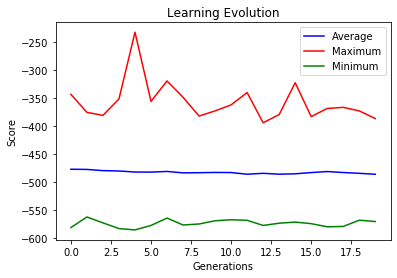

In [3]:
import matplotlib.pyplot as plt

def plotLearningEvolution(generationAverage, generationMax, generationMin):
    generationAverage = np.array(generationAverage)
    generationMax = np.array(generationMax)
    generationMin = np.array(generationMin)

    G = list(range(generationAverage.size))
    plt.title("Learning Evolution")
    plt.xlabel("Generations")
    plt.ylabel("Score")
    plt.plot(G, generationAverage, color='blue', label='Average')
    plt.plot(G, generationMax, color='red', label='Maximum')
    plt.plot(G, generationMin, color='green', label='Minimum')
    plt.legend()
    plt.show()

plotLearningEvolution(generationAverage, generationMax, generationMin)

Agora, vamos executar 20 gerações para o layout mediumClassic:

In [4]:
generation = createGeneration()
generationAverage, generationMax, generationMin, mediumClassicStrategy = runGeneticLearning("mediumClassic", generation)

layout:  mediumClassic
Pacman died! Score: -407
Pacman died! Score: -442
Pacman died! Score: -684
Pacman died! Score: -418
Pacman died! Score: -419
Average Score: -474.0
Scores:        -407.0, -442.0, -684.0, -418.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -411
Pacman died! Score: -414
Pacman died! Score: -492
Pacman died! Score: -488
Pacman died! Score: -566
Average Score: -474.2
Scores:        -411.0, -414.0, -492.0, -488.0, -566.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -607
Pacman died! Score: -619
Pacman died! Score: -511
Pacman died! Score: -520
Pacman died! Score: -483
Average Score: -548.0
Scores:        -607.0, -619.0, -511.0, -520.0, -483.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -565
Pacman died! Score: -466
Pacman died! Score: -519
Pacman died! Score: 

Pacman died! Score: -448
Pacman died! Score: -430
Pacman died! Score: -441
Pacman died! Score: -483
Pacman died! Score: -493
Average Score: -459.0
Scores:        -448.0, -430.0, -441.0, -483.0, -493.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -442
Pacman died! Score: -723
Pacman died! Score: -499
Pacman died! Score: -459
Pacman died! Score: -618
Average Score: -548.2
Scores:        -442.0, -723.0, -499.0, -459.0, -618.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -585
Pacman died! Score: -488
Pacman died! Score: -509
Pacman died! Score: -492
Pacman died! Score: -539
Average Score: -522.6
Scores:        -585.0, -488.0, -509.0, -492.0, -539.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -563
Pacman died! Score: -446
Pacman died! Score: -508
Pacman died! Score: -557
Pacman died! Score

Pacman died! Score: -462
Pacman died! Score: -485
Pacman died! Score: -443
Pacman died! Score: -414
Pacman died! Score: -425
Average Score: -445.8
Scores:        -462.0, -485.0, -443.0, -414.0, -425.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -540
Pacman died! Score: -484
Pacman died! Score: -507
Pacman died! Score: -542
Pacman died! Score: -506
Average Score: -515.8
Scores:        -540.0, -484.0, -507.0, -542.0, -506.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -506
Pacman died! Score: -616
Pacman died! Score: -519
Pacman died! Score: -587
Pacman died! Score: -560
Average Score: -557.6
Scores:        -506.0, -616.0, -519.0, -587.0, -560.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -518
Pacman died! Score: -507
Pacman died! Score: -643
Pacman died! Score: -547
Pacman died! Score

Pacman died! Score: -588
Pacman died! Score: -665
Pacman died! Score: -618
Pacman died! Score: -599
Pacman died! Score: -536
Average Score: -601.2
Scores:        -588.0, -665.0, -618.0, -599.0, -536.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -558
Pacman died! Score: -478
Pacman died! Score: -520
Pacman died! Score: -509
Pacman died! Score: -527
Average Score: -518.4
Scores:        -558.0, -478.0, -520.0, -509.0, -527.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -592
Pacman died! Score: -508
Pacman died! Score: -482
Pacman died! Score: -533
Pacman died! Score: -505
Average Score: -524.0
Scores:        -592.0, -508.0, -482.0, -533.0, -505.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -578
Pacman died! Score: -502
Pacman died! Score: -541
Pacman died! Score: -604
Pacman died! Score

Pacman died! Score: -533
Pacman died! Score: -697
Pacman died! Score: -507
Pacman died! Score: -473
Pacman died! Score: -536
Average Score: -549.2
Scores:        -533.0, -697.0, -507.0, -473.0, -536.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -542
Pacman died! Score: -506
Pacman died! Score: -540
Pacman died! Score: -610
Pacman died! Score: -567
Average Score: -553.0
Scores:        -542.0, -506.0, -540.0, -610.0, -567.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -529
Pacman died! Score: -476
Pacman died! Score: -492
Pacman died! Score: -511
Pacman died! Score: -501
Average Score: -501.8
Scores:        -529.0, -476.0, -492.0, -511.0, -501.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -514
Pacman died! Score: -538
Pacman died! Score: -512
Pacman died! Score: -505
Pacman died! Score

Pacman died! Score: -404
Pacman died! Score: -425
Pacman died! Score: -398
Pacman died! Score: -549
Pacman died! Score: -355
Average Score: -426.2
Scores:        -404.0, -425.0, -398.0, -549.0, -355.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -642
Pacman died! Score: -555
Pacman died! Score: -536
Pacman died! Score: -519
Pacman died! Score: -717
Average Score: -593.8
Scores:        -642.0, -555.0, -536.0, -519.0, -717.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -556
Pacman died! Score: -496
Pacman died! Score: -511
Pacman died! Score: -726
Pacman died! Score: -542
Average Score: -566.2
Scores:        -556.0, -496.0, -511.0, -726.0, -542.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -498
Pacman died! Score: -457
Pacman died! Score: -516
Pacman died! Score: -494
Pacman died! Score

Pacman died! Score: -517
Pacman died! Score: -528
Pacman died! Score: -569
Pacman died! Score: -479
Pacman died! Score: -579
Average Score: -534.4
Scores:        -517.0, -528.0, -569.0, -479.0, -579.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -496
Pacman died! Score: -489
Pacman died! Score: -513
Pacman died! Score: -508
Pacman died! Score: -485
Average Score: -498.2
Scores:        -496.0, -489.0, -513.0, -508.0, -485.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -506
Pacman died! Score: -427
Pacman died! Score: -400
Pacman died! Score: -393
Pacman died! Score: -398
Average Score: -424.8
Scores:        -506.0, -427.0, -400.0, -393.0, -398.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -490
Pacman died! Score: -442
Pacman died! Score: -500
Pacman died! Score: -559
Pacman died! Score

Pacman died! Score: -505
Pacman died! Score: -519
Pacman died! Score: -665
Pacman died! Score: -506
Pacman died! Score: -538
Average Score: -546.6
Scores:        -505.0, -519.0, -665.0, -506.0, -538.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -543
Pacman died! Score: -522
Pacman died! Score: -493
Pacman died! Score: -566
Pacman died! Score: -494
Average Score: -523.6
Scores:        -543.0, -522.0, -493.0, -566.0, -494.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -496
Pacman died! Score: -525
Pacman died! Score: -505
Pacman died! Score: -497
Pacman died! Score: -518
Average Score: -508.2
Scores:        -496.0, -525.0, -505.0, -497.0, -518.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -499
Pacman died! Score: -631
Pacman died! Score: -503
Pacman died! Score: -522
Pacman died! Score

Pacman died! Score: -548
Pacman died! Score: -565
Pacman died! Score: -738
Pacman died! Score: -551
Pacman died! Score: -526
Average Score: -585.6
Scores:        -548.0, -565.0, -738.0, -551.0, -526.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -416
Pacman died! Score: -590
Pacman died! Score: -404
Pacman died! Score: -526
Pacman died! Score: -531
Average Score: -493.4
Scores:        -416.0, -590.0, -404.0, -526.0, -531.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -486
Pacman died! Score: -493
Pacman died! Score: -543
Pacman died! Score: -511
Pacman died! Score: -550
Average Score: -516.6
Scores:        -486.0, -493.0, -543.0, -511.0, -550.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -551
Pacman died! Score: -540
Pacman died! Score: -695
Pacman died! Score: -526
Pacman died! Score

Pacman died! Score: -481
Pacman died! Score: -510
Pacman died! Score: -539
Pacman died! Score: -487
Pacman died! Score: -543
Average Score: -512.0
Scores:        -481.0, -510.0, -539.0, -487.0, -543.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -425
Pacman died! Score: -426
Pacman died! Score: -633
Pacman died! Score: -462
Pacman died! Score: -447
Average Score: -478.6
Scores:        -425.0, -426.0, -633.0, -462.0, -447.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -361
Pacman died! Score: -486
Pacman died! Score: -439
Pacman died! Score: -522
Pacman died! Score: -528
Average Score: -467.2
Scores:        -361.0, -486.0, -439.0, -522.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -583
Pacman died! Score: -480
Pacman died! Score: -490
Pacman died! Score: -477
Pacman died! Score

Pacman died! Score: -581
Pacman died! Score: -540
Pacman died! Score: -535
Pacman died! Score: -527
Pacman died! Score: -545
Average Score: -545.6
Scores:        -581.0, -540.0, -535.0, -527.0, -545.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -495
Pacman died! Score: -503
Pacman died! Score: -506
Pacman died! Score: -606
Pacman died! Score: -489
Average Score: -519.8
Scores:        -495.0, -503.0, -506.0, -606.0, -489.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -428
Pacman died! Score: -440
Pacman died! Score: -366
Pacman died! Score: -374
Pacman died! Score: -429
Average Score: -407.4
Scores:        -428.0, -440.0, -366.0, -374.0, -429.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -485
Pacman died! Score: -558
Pacman died! Score: -481
Pacman died! Score: -584
Pacman died! Score

Pacman died! Score: -603
Pacman died! Score: -507
Pacman died! Score: -544
Pacman died! Score: -500
Pacman died! Score: -501
Average Score: -531.0
Scores:        -603.0, -507.0, -544.0, -500.0, -501.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -540
Pacman died! Score: -536
Pacman died! Score: -551
Pacman died! Score: -627
Pacman died! Score: -495
Average Score: -549.8
Scores:        -540.0, -536.0, -551.0, -627.0, -495.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -441
Pacman died! Score: -409
Pacman died! Score: -376
Pacman died! Score: -439
Pacman died! Score: -390
Average Score: -411.0
Scores:        -441.0, -409.0, -376.0, -439.0, -390.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -578
Pacman died! Score: -591
Pacman died! Score: -558
Pacman died! Score: -530
Pacman died! Score

Pacman died! Score: -428
Pacman died! Score: -398
Pacman died! Score: -417
Pacman died! Score: -412
Pacman died! Score: -412
Average Score: -413.4
Scores:        -428.0, -398.0, -417.0, -412.0, -412.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -377
Pacman died! Score: 26
Pacman died! Score: -514
Pacman died! Score: -486
Pacman died! Score: -421
Average Score: -354.4
Scores:        -377.0, 26.0, -514.0, -486.0, -421.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -542
Pacman died! Score: -531
Pacman died! Score: -564
Pacman died! Score: -527
Pacman died! Score: -508
Average Score: -534.4
Scores:        -542.0, -531.0, -564.0, -527.0, -508.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -665
Pacman died! Score: -505
Pacman died! Score: -645
Pacman died! Score: -581
Pacman died! Score: -5

Pacman died! Score: -559
Pacman died! Score: -529
Pacman died! Score: -538
Pacman died! Score: -561
Pacman died! Score: -662
Average Score: -569.8
Scores:        -559.0, -529.0, -538.0, -561.0, -662.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -585
Pacman died! Score: -492
Pacman died! Score: -569
Pacman died! Score: -511
Pacman died! Score: -545
Average Score: -540.4
Scores:        -585.0, -492.0, -569.0, -511.0, -545.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -550
Pacman died! Score: -420
Pacman died! Score: -447
Pacman died! Score: -502
Pacman died! Score: -453
Average Score: -474.4
Scores:        -550.0, -420.0, -447.0, -502.0, -453.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -502
Pacman died! Score: -481
Pacman died! Score: -554
Pacman died! Score: -492
Pacman died! Score

Pacman died! Score: -522
Pacman died! Score: -488
Pacman died! Score: -491
Pacman died! Score: -490
Pacman died! Score: -534
Average Score: -505.0
Scores:        -522.0, -488.0, -491.0, -490.0, -534.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -464
Pacman died! Score: -458
Pacman died! Score: -456
Pacman died! Score: -476
Pacman died! Score: -447
Average Score: -460.2
Scores:        -464.0, -458.0, -456.0, -476.0, -447.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -548
Pacman died! Score: -662
Pacman died! Score: -535
Pacman died! Score: -524
Pacman died! Score: -622
Average Score: -578.2
Scores:        -548.0, -662.0, -535.0, -524.0, -622.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -545
Pacman died! Score: -656
Pacman died! Score: -561
Pacman died! Score: -507
Pacman died! Score

Pacman died! Score: -573
Pacman died! Score: -485
Pacman died! Score: -516
Pacman died! Score: -506
Pacman died! Score: -504
Average Score: -516.8
Scores:        -573.0, -485.0, -516.0, -506.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -563
Pacman died! Score: -539
Pacman died! Score: -510
Pacman died! Score: -533
Pacman died! Score: -601
Average Score: -549.2
Scores:        -563.0, -539.0, -510.0, -533.0, -601.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -533
Pacman died! Score: -532
Pacman died! Score: -637
Pacman died! Score: -547
Pacman died! Score: -531
Average Score: -556.0
Scores:        -533.0, -532.0, -637.0, -547.0, -531.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -538
Pacman died! Score: -598
Pacman died! Score: -496
Pacman died! Score: -516
Pacman died! Score

Pacman died! Score: -493
Pacman died! Score: -473
Pacman died! Score: -568
Pacman died! Score: -508
Pacman died! Score: -501
Average Score: -508.6
Scores:        -493.0, -473.0, -568.0, -508.0, -501.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -522
Pacman died! Score: -486
Pacman died! Score: -524
Pacman died! Score: -501
Pacman died! Score: -546
Average Score: -515.8
Scores:        -522.0, -486.0, -524.0, -501.0, -546.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -516
Pacman died! Score: -517
Pacman died! Score: -598
Pacman died! Score: -544
Pacman died! Score: -554
Average Score: -545.8
Scores:        -516.0, -517.0, -598.0, -544.0, -554.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -380
Pacman died! Score: -388
Pacman died! Score: -435
Pacman died! Score: -409
Pacman died! Score

Pacman died! Score: -419
Pacman died! Score: -416
Pacman died! Score: -410
Pacman died! Score: -396
Pacman died! Score: -419
Average Score: -412.0
Scores:        -419.0, -416.0, -410.0, -396.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -518
Pacman died! Score: -488
Pacman died! Score: -576
Pacman died! Score: -505
Pacman died! Score: -592
Average Score: -535.8
Scores:        -518.0, -488.0, -576.0, -505.0, -592.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -413
Pacman died! Score: -439
Pacman died! Score: -368
Pacman died! Score: -398
Pacman died! Score: -429
Average Score: -409.4
Scores:        -413.0, -439.0, -368.0, -398.0, -429.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -413
Pacman died! Score: -398
Pacman died! Score: -499
Pacman died! Score: -590
Pacman died! Score

Pacman died! Score: -518
Pacman died! Score: -524
Pacman died! Score: -522
Pacman died! Score: -749
Pacman died! Score: -543
Average Score: -571.2
Scores:        -518.0, -524.0, -522.0, -749.0, -543.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -598
Pacman died! Score: -523
Pacman died! Score: -515
Pacman died! Score: -576
Pacman died! Score: -517
Average Score: -545.8
Scores:        -598.0, -523.0, -515.0, -576.0, -517.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -613
Pacman died! Score: -565
Pacman died! Score: -559
Pacman died! Score: -563
Pacman died! Score: -599
Average Score: -579.8
Scores:        -613.0, -565.0, -559.0, -563.0, -599.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -497
Pacman died! Score: -403
Pacman died! Score: -410
Pacman died! Score: -491
Pacman died! Score

Pacman died! Score: -591
Pacman died! Score: -518
Pacman died! Score: -475
Pacman died! Score: -521
Pacman died! Score: -505
Average Score: -522.0
Scores:        -591.0, -518.0, -475.0, -521.0, -505.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -518
Pacman died! Score: -481
Pacman died! Score: -485
Pacman died! Score: -466
Pacman died! Score: -516
Average Score: -493.2
Scores:        -518.0, -481.0, -485.0, -466.0, -516.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -473
Pacman died! Score: -514
Pacman died! Score: -474
Pacman died! Score: -566
Pacman died! Score: -506
Average Score: -506.6
Scores:        -473.0, -514.0, -474.0, -566.0, -506.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -552
Pacman died! Score: -448
Pacman died! Score: -478
Pacman died! Score: -410
Pacman died! Score

Pacman died! Score: -486
Pacman died! Score: -466
Pacman died! Score: -520
Pacman died! Score: -503
Pacman died! Score: -490
Average Score: -493.0
Scores:        -486.0, -466.0, -520.0, -503.0, -490.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -573
Pacman died! Score: -548
Pacman died! Score: -483
Pacman died! Score: -587
Pacman died! Score: -588
Average Score: -555.8
Scores:        -573.0, -548.0, -483.0, -587.0, -588.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -527
Pacman died! Score: -530
Pacman died! Score: -510
Pacman died! Score: -583
Pacman died! Score: -519
Average Score: -533.8
Scores:        -527.0, -530.0, -510.0, -583.0, -519.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -529
Pacman died! Score: -425
Pacman died! Score: -481
Pacman died! Score: -514
Pacman died! Score

Pacman died! Score: -486
Pacman died! Score: -588
Pacman died! Score: -607
Pacman died! Score: -552
Pacman died! Score: -574
Average Score: -561.4
Scores:        -486.0, -588.0, -607.0, -552.0, -574.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -550
Pacman died! Score: -576
Pacman died! Score: -496
Pacman died! Score: -556
Pacman died! Score: -583
Average Score: -552.2
Scores:        -550.0, -576.0, -496.0, -556.0, -583.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -744
Pacman died! Score: -551
Pacman died! Score: -553
Pacman died! Score: -553
Pacman died! Score: -684
Average Score: -617.0
Scores:        -744.0, -551.0, -553.0, -553.0, -684.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -496
Pacman died! Score: -586
Pacman died! Score: -548
Pacman died! Score: -523
Pacman died! Score

Pacman died! Score: -411
Pacman died! Score: -403
Pacman died! Score: -443
Pacman died! Score: -459
Pacman died! Score: -406
Average Score: -424.4
Scores:        -411.0, -403.0, -443.0, -459.0, -406.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -569
Pacman died! Score: -563
Pacman died! Score: -527
Pacman died! Score: -480
Pacman died! Score: -487
Average Score: -525.2
Scores:        -569.0, -563.0, -527.0, -480.0, -487.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -526
Pacman died! Score: -446
Pacman died! Score: -495
Pacman died! Score: -500
Pacman died! Score: -492
Average Score: -491.8
Scores:        -526.0, -446.0, -495.0, -500.0, -492.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -480
Pacman died! Score: -485
Pacman died! Score: -583
Pacman died! Score: -670
Pacman died! Score

Pacman died! Score: -515
Pacman died! Score: -508
Pacman died! Score: -512
Pacman died! Score: -628
Pacman died! Score: -483
Average Score: -529.2
Scores:        -515.0, -508.0, -512.0, -628.0, -483.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -547
Pacman died! Score: -561
Pacman died! Score: -475
Pacman died! Score: -502
Pacman died! Score: -536
Average Score: -524.2
Scores:        -547.0, -561.0, -475.0, -502.0, -536.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -544
Pacman died! Score: -558
Pacman died! Score: -529
Pacman died! Score: -500
Pacman died! Score: -869
Average Score: -600.0
Scores:        -544.0, -558.0, -529.0, -500.0, -869.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -612
Pacman died! Score: -542
Pacman died! Score: -503
Pacman died! Score: -510
Pacman died! Score

Pacman died! Score: -576
Pacman died! Score: -528
Pacman died! Score: -495
Pacman died! Score: -670
Pacman died! Score: -617
Average Score: -577.2
Scores:        -576.0, -528.0, -495.0, -670.0, -617.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -533
Pacman died! Score: -519
Pacman died! Score: -538
Pacman died! Score: -505
Pacman died! Score: -507
Average Score: -520.4
Scores:        -533.0, -519.0, -538.0, -505.0, -507.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -576
Pacman died! Score: -594
Pacman died! Score: -514
Pacman died! Score: -534
Pacman died! Score: -450
Average Score: -533.6
Scores:        -576.0, -594.0, -514.0, -534.0, -450.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -408
Pacman died! Score: -404
Pacman died! Score: -399
Pacman died! Score: -421
Pacman died! Score

Pacman died! Score: -554
Pacman died! Score: -519
Pacman died! Score: -480
Pacman died! Score: -501
Pacman died! Score: -494
Average Score: -509.6
Scores:        -554.0, -519.0, -480.0, -501.0, -494.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -530
Pacman died! Score: -583
Pacman died! Score: -603
Pacman died! Score: -584
Pacman died! Score: -518
Average Score: -563.6
Scores:        -530.0, -583.0, -603.0, -584.0, -518.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -428
Pacman died! Score: -514
Pacman died! Score: -455
Pacman died! Score: -515
Pacman died! Score: -440
Average Score: -470.4
Scores:        -428.0, -514.0, -455.0, -515.0, -440.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -485
Pacman died! Score: -469
Pacman died! Score: -497
Pacman died! Score: -499
Pacman died! Score

Pacman died! Score: -439
Pacman died! Score: -435
Pacman died! Score: -445
Pacman died! Score: -454
Pacman died! Score: -459
Average Score: -446.4
Scores:        -439.0, -435.0, -445.0, -454.0, -459.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -562
Pacman died! Score: -524
Pacman died! Score: -574
Pacman died! Score: -519
Pacman died! Score: -535
Average Score: -542.8
Scores:        -562.0, -524.0, -574.0, -519.0, -535.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -402
Pacman died! Score: -551
Pacman died! Score: -410
Pacman died! Score: -355
Pacman died! Score: -378
Average Score: -419.2
Scores:        -402.0, -551.0, -410.0, -355.0, -378.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -587
Pacman died! Score: -560
Pacman died! Score: -572
Pacman died! Score: -544
Pacman died! Score

Pacman died! Score: -481
Pacman died! Score: -694
Pacman died! Score: -490
Pacman died! Score: -624
Pacman died! Score: -466
Average Score: -551.0
Scores:        -481.0, -694.0, -490.0, -624.0, -466.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -544
Pacman died! Score: -521
Pacman died! Score: -516
Pacman died! Score: -509
Pacman died! Score: -510
Average Score: -520.0
Scores:        -544.0, -521.0, -516.0, -509.0, -510.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -627
Pacman died! Score: -624
Pacman died! Score: -500
Pacman died! Score: -530
Pacman died! Score: -554
Average Score: -567.0
Scores:        -627.0, -624.0, -500.0, -530.0, -554.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -509
Pacman died! Score: -569
Pacman died! Score: -520
Pacman died! Score: -502
Pacman died! Score

Pacman died! Score: -505
Pacman died! Score: -573
Pacman died! Score: -558
Pacman died! Score: -397
Pacman died! Score: -682
Average Score: -543.0
Scores:        -505.0, -573.0, -558.0, -397.0, -682.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -594
Pacman died! Score: -552
Pacman died! Score: -524
Pacman died! Score: -656
Pacman died! Score: -519
Average Score: -569.0
Scores:        -594.0, -552.0, -524.0, -656.0, -519.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -514
Pacman died! Score: -508
Pacman died! Score: -501
Pacman died! Score: -524
Pacman died! Score: -504
Average Score: -510.2
Scores:        -514.0, -508.0, -501.0, -524.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -360
Pacman died! Score: -474
Pacman died! Score: -490
Pacman died! Score: -419
Pacman died! Score

Pacman died! Score: -515
Pacman died! Score: -532
Pacman died! Score: -499
Pacman died! Score: -544
Pacman died! Score: -628
Average Score: -543.6
Scores:        -515.0, -532.0, -499.0, -544.0, -628.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -502
Pacman died! Score: -441
Pacman died! Score: -537
Pacman died! Score: -499
Pacman died! Score: -366
Average Score: -469.0
Scores:        -502.0, -441.0, -537.0, -499.0, -366.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -414
Pacman died! Score: -398
Pacman died! Score: -491
Pacman died! Score: -485
Pacman died! Score: -485
Average Score: -454.6
Scores:        -414.0, -398.0, -491.0, -485.0, -485.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -502
Pacman died! Score: -381
Pacman died! Score: -431
Pacman died! Score: -425
Pacman died! Score

Pacman died! Score: -515
Pacman died! Score: -644
Pacman died! Score: -511
Pacman died! Score: -549
Pacman died! Score: -542
Average Score: -552.2
Scores:        -515.0, -644.0, -511.0, -549.0, -542.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -466
Pacman died! Score: -431
Pacman died! Score: -390
Pacman died! Score: -504
Pacman died! Score: -509
Average Score: -460.0
Scores:        -466.0, -431.0, -390.0, -504.0, -509.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -482
Pacman died! Score: -464
Pacman died! Score: -684
Pacman died! Score: -434
Pacman died! Score: -456
Average Score: -504.0
Scores:        -482.0, -464.0, -684.0, -434.0, -456.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -549
Pacman died! Score: -493
Pacman died! Score: -488
Pacman died! Score: -539
Pacman died! Score

Pacman died! Score: -392
Pacman died! Score: -339
Pacman died! Score: -404
Pacman died! Score: -465
Pacman died! Score: -440
Average Score: -408.0
Scores:        -392.0, -339.0, -404.0, -465.0, -440.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -378
Pacman died! Score: -437
Pacman died! Score: -444
Pacman died! Score: -360
Pacman died! Score: -305
Average Score: -384.8
Scores:        -378.0, -437.0, -444.0, -360.0, -305.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -516
Pacman died! Score: -597
Pacman died! Score: -531
Pacman died! Score: -582
Pacman died! Score: -546
Average Score: -554.4
Scores:        -516.0, -597.0, -531.0, -582.0, -546.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -506
Pacman died! Score: -584
Pacman died! Score: -511
Pacman died! Score: -564
Pacman died! Score

Pacman died! Score: -446
Pacman died! Score: -397
Pacman died! Score: -447
Pacman died! Score: -411
Pacman died! Score: -416
Average Score: -423.4
Scores:        -446.0, -397.0, -447.0, -411.0, -416.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -494
Pacman died! Score: -553
Pacman died! Score: -526
Pacman died! Score: -477
Pacman died! Score: -499
Average Score: -509.8
Scores:        -494.0, -553.0, -526.0, -477.0, -499.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -577
Pacman died! Score: -508
Pacman died! Score: -544
Pacman died! Score: -541
Pacman died! Score: -490
Average Score: -532.0
Scores:        -577.0, -508.0, -544.0, -541.0, -490.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -523
Pacman died! Score: -524
Pacman died! Score: -537
Pacman died! Score: -518
Pacman died! Score

Pacman died! Score: -550
Pacman died! Score: -533
Pacman died! Score: -655
Pacman died! Score: -541
Pacman died! Score: -535
Average Score: -562.8
Scores:        -550.0, -533.0, -655.0, -541.0, -535.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -401
Pacman died! Score: -401
Pacman died! Score: -338
Pacman died! Score: -523
Pacman died! Score: -426
Average Score: -417.8
Scores:        -401.0, -401.0, -338.0, -523.0, -426.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -460
Pacman died! Score: -419
Pacman died! Score: -399
Pacman died! Score: -480
Pacman died! Score: -419
Average Score: -435.4
Scores:        -460.0, -419.0, -399.0, -480.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -566
Pacman died! Score: -517
Pacman died! Score: -628
Pacman died! Score: -600
Pacman died! Score

Pacman died! Score: -552
Pacman died! Score: -541
Pacman died! Score: -541
Pacman died! Score: -563
Pacman died! Score: -576
Average Score: -554.6
Scores:        -552.0, -541.0, -541.0, -563.0, -576.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -486
Pacman died! Score: -526
Pacman died! Score: -492
Pacman died! Score: -454
Pacman died! Score: -452
Average Score: -482.0
Scores:        -486.0, -526.0, -492.0, -454.0, -452.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -423
Pacman died! Score: -420
Pacman died! Score: -522
Pacman died! Score: -492
Pacman died! Score: -497
Average Score: -470.8
Scores:        -423.0, -420.0, -522.0, -492.0, -497.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -455
Pacman died! Score: -411
Pacman died! Score: -398
Pacman died! Score: -397
Pacman died! Score

Pacman died! Score: -548
Pacman died! Score: -496
Pacman died! Score: -550
Pacman died! Score: -478
Pacman died! Score: -473
Average Score: -509.0
Scores:        -548.0, -496.0, -550.0, -478.0, -473.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -483
Pacman died! Score: -785
Pacman died! Score: -490
Pacman died! Score: -654
Pacman died! Score: -461
Average Score: -574.6
Scores:        -483.0, -785.0, -490.0, -654.0, -461.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -470
Pacman died! Score: -476
Pacman died! Score: -464
Pacman died! Score: -369
Pacman died! Score: -442
Average Score: -444.2
Scores:        -470.0, -476.0, -464.0, -369.0, -442.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -424
Pacman died! Score: -620
Pacman died! Score: -399
Pacman died! Score: -414
Pacman died! Score

Pacman died! Score: -522
Pacman died! Score: -505
Pacman died! Score: -526
Pacman died! Score: -517
Pacman died! Score: -506
Average Score: -515.2
Scores:        -522.0, -505.0, -526.0, -517.0, -506.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -515
Pacman died! Score: -472
Pacman died! Score: -505
Pacman died! Score: -494
Pacman died! Score: -501
Average Score: -497.4
Scores:        -515.0, -472.0, -505.0, -494.0, -501.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -612
Pacman died! Score: -508
Pacman died! Score: -571
Pacman died! Score: -547
Pacman died! Score: -596
Average Score: -566.8
Scores:        -612.0, -508.0, -571.0, -547.0, -596.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -522
Pacman died! Score: -522
Pacman died! Score: -696
Pacman died! Score: -504
Pacman died! Score

Pacman died! Score: -518
Pacman died! Score: -511
Pacman died! Score: -594
Pacman died! Score: -527
Pacman died! Score: -541
Average Score: -538.2
Scores:        -518.0, -511.0, -594.0, -527.0, -541.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -531
Pacman died! Score: -626
Pacman died! Score: -540
Pacman died! Score: -545
Pacman died! Score: -697
Average Score: -587.8
Scores:        -531.0, -626.0, -540.0, -545.0, -697.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -591
Pacman died! Score: -521
Pacman died! Score: -497
Pacman died! Score: -575
Pacman died! Score: -501
Average Score: -537.0
Scores:        -591.0, -521.0, -497.0, -575.0, -501.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -453
Pacman died! Score: -441
Pacman died! Score: -406
Pacman died! Score: -395
Pacman died! Score

Pacman died! Score: -655
Pacman died! Score: -494
Pacman died! Score: -578
Pacman died! Score: -521
Pacman died! Score: -570
Average Score: -563.6
Scores:        -655.0, -494.0, -578.0, -521.0, -570.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -525
Pacman died! Score: -513
Pacman died! Score: -343
Pacman died! Score: -549
Pacman died! Score: -461
Average Score: -478.2
Scores:        -525.0, -513.0, -343.0, -549.0, -461.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -561
Pacman died! Score: -572
Pacman died! Score: -505
Pacman died! Score: -487
Pacman died! Score: -614
Average Score: -547.8
Scores:        -561.0, -572.0, -505.0, -487.0, -614.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -559
Pacman died! Score: -513
Pacman died! Score: -507
Pacman died! Score: -491
Pacman died! Score

Pacman died! Score: -521
Pacman died! Score: -389
Pacman died! Score: -358
Pacman died! Score: -401
Pacman died! Score: -369
Average Score: -407.6
Scores:        -521.0, -389.0, -358.0, -401.0, -369.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -474
Pacman died! Score: -533
Pacman died! Score: -504
Pacman died! Score: -499
Pacman died! Score: -486
Average Score: -499.2
Scores:        -474.0, -533.0, -504.0, -499.0, -486.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -506
Pacman died! Score: -503
Pacman died! Score: -466
Pacman died! Score: -461
Pacman died! Score: -484
Average Score: -484.0
Scores:        -506.0, -503.0, -466.0, -461.0, -484.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -519
Pacman died! Score: -525
Pacman died! Score: -482
Pacman died! Score: -423
Pacman died! Score

Pacman died! Score: -627
Pacman died! Score: -490
Pacman died! Score: -534
Pacman died! Score: -521
Pacman died! Score: -564
Average Score: -547.2
Scores:        -627.0, -490.0, -534.0, -521.0, -564.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -384
Pacman died! Score: -401
Pacman died! Score: -366
Pacman died! Score: -403
Pacman died! Score: -362
Average Score: -383.2
Scores:        -384.0, -401.0, -366.0, -403.0, -362.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -545
Pacman died! Score: -532
Pacman died! Score: -595
Pacman died! Score: -532
Pacman died! Score: -554
Average Score: -551.6
Scores:        -545.0, -532.0, -595.0, -532.0, -554.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -588
Pacman died! Score: -584
Pacman died! Score: -600
Pacman died! Score: -668
Pacman died! Score

Pacman died! Score: -472
Pacman died! Score: -602
Pacman died! Score: -605
Pacman died! Score: -536
Pacman died! Score: -500
Average Score: -543.0
Scores:        -472.0, -602.0, -605.0, -536.0, -500.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -453
Pacman died! Score: -348
Pacman died! Score: -419
Pacman died! Score: -364
Pacman died! Score: -407
Average Score: -398.2
Scores:        -453.0, -348.0, -419.0, -364.0, -407.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -523
Pacman died! Score: -551
Pacman died! Score: -523
Pacman died! Score: -665
Pacman died! Score: -536
Average Score: -559.6
Scores:        -523.0, -551.0, -523.0, -665.0, -536.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -393
Pacman died! Score: -400
Pacman died! Score: -370
Pacman died! Score: -398
Pacman died! Score

Pacman died! Score: -521
Pacman died! Score: -469
Pacman died! Score: -584
Pacman died! Score: -480
Pacman died! Score: -528
Average Score: -516.4
Scores:        -521.0, -469.0, -584.0, -480.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -585
Pacman died! Score: -524
Pacman died! Score: -604
Pacman died! Score: -569
Pacman died! Score: -753
Average Score: -607.0
Scores:        -585.0, -524.0, -604.0, -569.0, -753.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -567
Pacman died! Score: -488
Pacman died! Score: -387
Pacman died! Score: -506
Pacman died! Score: -415
Average Score: -472.6
Scores:        -567.0, -488.0, -387.0, -506.0, -415.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -493
Pacman died! Score: -493
Pacman died! Score: -591
Pacman died! Score: -406
Pacman died! Score

Pacman died! Score: -575
Pacman died! Score: -438
Pacman died! Score: -399
Pacman died! Score: -419
Pacman died! Score: -396
Average Score: -445.4
Scores:        -575.0, -438.0, -399.0, -419.0, -396.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -512
Pacman died! Score: -538
Pacman died! Score: -540
Pacman died! Score: -524
Pacman died! Score: -534
Average Score: -529.6
Scores:        -512.0, -538.0, -540.0, -524.0, -534.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -173
Pacman died! Score: -467
Pacman died! Score: -455
Pacman died! Score: -199
Pacman died! Score: -418
Average Score: -342.4
Scores:        -173.0, -467.0, -455.0, -199.0, -418.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -366
Pacman died! Score: -404
Pacman died! Score: -401
Pacman died! Score: -346
Pacman died! Score

Pacman died! Score: -498
Pacman died! Score: -554
Pacman died! Score: -550
Pacman died! Score: -525
Pacman died! Score: -532
Average Score: -531.8
Scores:        -498.0, -554.0, -550.0, -525.0, -532.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -486
Pacman died! Score: -159
Pacman died! Score: -441
Pacman died! Score: -417
Pacman died! Score: -69
Average Score: -314.4
Scores:        -486.0, -159.0, -441.0, -417.0, -69.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -502
Pacman died! Score: -476
Pacman died! Score: -610
Pacman died! Score: -504
Pacman died! Score: -517
Average Score: -521.8
Scores:        -502.0, -476.0, -610.0, -504.0, -517.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -512
Pacman died! Score: -496
Pacman died! Score: -529
Pacman died! Score: -547
Pacman died! Score: 

Pacman died! Score: -512
Pacman died! Score: -584
Pacman died! Score: -480
Pacman died! Score: -513
Pacman died! Score: -483
Average Score: -514.4
Scores:        -512.0, -584.0, -480.0, -513.0, -483.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -599
Pacman died! Score: -585
Pacman died! Score: -661
Pacman died! Score: -493
Pacman died! Score: -568
Average Score: -581.2
Scores:        -599.0, -585.0, -661.0, -493.0, -568.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -479
Pacman died! Score: -530
Pacman died! Score: -502
Pacman died! Score: -529
Pacman died! Score: -498
Average Score: -507.6
Scores:        -479.0, -530.0, -502.0, -529.0, -498.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -468
Pacman died! Score: -482
Pacman died! Score: -522
Pacman died! Score: -516
Pacman died! Score

Pacman died! Score: -760
Pacman died! Score: -516
Pacman died! Score: -525
Pacman died! Score: -493
Pacman died! Score: -528
Average Score: -564.4
Scores:        -760.0, -516.0, -525.0, -493.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -588
Pacman died! Score: -508
Pacman died! Score: -516
Pacman died! Score: -721
Pacman died! Score: -536
Average Score: -573.8
Scores:        -588.0, -508.0, -516.0, -721.0, -536.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -649
Pacman died! Score: -572
Pacman died! Score: -582
Pacman died! Score: -645
Pacman died! Score: -536
Average Score: -596.8
Scores:        -649.0, -572.0, -582.0, -645.0, -536.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -365
Pacman died! Score: -363
Pacman died! Score: -362
Pacman died! Score: -497
Pacman died! Score

Pacman died! Score: -602
Pacman died! Score: -508
Pacman died! Score: -500
Pacman died! Score: -606
Pacman died! Score: -529
Average Score: -549.0
Scores:        -602.0, -508.0, -500.0, -606.0, -529.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -520
Pacman died! Score: -500
Pacman died! Score: -489
Pacman died! Score: -492
Pacman died! Score: -504
Average Score: -501.0
Scores:        -520.0, -500.0, -489.0, -492.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -467
Pacman died! Score: -471
Pacman died! Score: -546
Pacman died! Score: -470
Pacman died! Score: -517
Average Score: -494.2
Scores:        -467.0, -471.0, -546.0, -470.0, -517.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -492
Pacman died! Score: -496
Pacman died! Score: -493
Pacman died! Score: -521
Pacman died! Score

Pacman died! Score: -386
Pacman died! Score: -515
Pacman died! Score: -499
Pacman died! Score: -549
Pacman died! Score: -507
Average Score: -491.2
Scores:        -386.0, -515.0, -499.0, -549.0, -507.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -420
Pacman died! Score: -660
Pacman died! Score: -394
Pacman died! Score: -383
Pacman died! Score: -322
Average Score: -435.8
Scores:        -420.0, -660.0, -394.0, -383.0, -322.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -508
Pacman died! Score: -516
Pacman died! Score: -526
Pacman died! Score: -571
Pacman died! Score: -552
Average Score: -534.6
Scores:        -508.0, -516.0, -526.0, -571.0, -552.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -507
Pacman died! Score: -537
Pacman died! Score: -595
Pacman died! Score: -575
Pacman died! Score

Pacman died! Score: -526
Pacman died! Score: -536
Pacman died! Score: -641
Pacman died! Score: -530
Pacman died! Score: -555
Average Score: -557.6
Scores:        -526.0, -536.0, -641.0, -530.0, -555.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -534
Pacman died! Score: -543
Pacman died! Score: -539
Pacman died! Score: -547
Pacman died! Score: -523
Average Score: -537.2
Scores:        -534.0, -543.0, -539.0, -547.0, -523.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -525
Pacman died! Score: -599
Pacman died! Score: -542
Pacman died! Score: -528
Pacman died! Score: -513
Average Score: -541.4
Scores:        -525.0, -599.0, -542.0, -528.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -477
Pacman died! Score: -500
Pacman died! Score: -479
Pacman died! Score: -455
Pacman died! Score

Pacman died! Score: -516
Pacman died! Score: -477
Pacman died! Score: -493
Pacman died! Score: -571
Pacman died! Score: -497
Average Score: -510.8
Scores:        -516.0, -477.0, -493.0, -571.0, -497.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -459
Pacman died! Score: -392
Pacman died! Score: -392
Pacman died! Score: -495
Pacman died! Score: -489
Average Score: -445.4
Scores:        -459.0, -392.0, -392.0, -495.0, -489.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -569
Pacman died! Score: -510
Pacman died! Score: -691
Pacman died! Score: -627
Pacman died! Score: -527
Average Score: -584.8
Scores:        -569.0, -510.0, -691.0, -627.0, -527.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -512
Pacman died! Score: -502
Pacman died! Score: -516
Pacman died! Score: -504
Pacman died! Score

Pacman died! Score: -537
Pacman died! Score: -529
Pacman died! Score: -595
Pacman died! Score: -534
Pacman died! Score: -591
Average Score: -557.2
Scores:        -537.0, -529.0, -595.0, -534.0, -591.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -542
Pacman died! Score: -521
Pacman died! Score: -517
Pacman died! Score: -564
Pacman died! Score: -541
Average Score: -537.0
Scores:        -542.0, -521.0, -517.0, -564.0, -541.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -492
Pacman died! Score: -490
Pacman died! Score: -496
Pacman died! Score: -533
Pacman died! Score: -513
Average Score: -504.8
Scores:        -492.0, -490.0, -496.0, -533.0, -513.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -537
Pacman died! Score: -558
Pacman died! Score: -503
Pacman died! Score: -544
Pacman died! Score

Pacman died! Score: -496
Pacman died! Score: -573
Pacman died! Score: -526
Pacman died! Score: -563
Pacman died! Score: -525
Average Score: -536.6
Scores:        -496.0, -573.0, -526.0, -563.0, -525.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -516
Pacman died! Score: -693
Pacman died! Score: -529
Pacman died! Score: -569
Pacman died! Score: -517
Average Score: -564.8
Scores:        -516.0, -693.0, -529.0, -569.0, -517.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -532
Pacman died! Score: -497
Pacman died! Score: -522
Pacman died! Score: -525
Pacman died! Score: -526
Average Score: -520.4
Scores:        -532.0, -497.0, -522.0, -525.0, -526.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -515
Pacman died! Score: -579
Pacman died! Score: -583
Pacman died! Score: -598
Pacman died! Score

Pacman died! Score: -541
Pacman died! Score: -505
Pacman died! Score: -533
Pacman died! Score: -547
Pacman died! Score: -537
Average Score: -532.6
Scores:        -541.0, -505.0, -533.0, -547.0, -537.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -470
Pacman died! Score: -514
Pacman died! Score: -496
Pacman died! Score: -505
Pacman died! Score: -524
Average Score: -501.8
Scores:        -470.0, -514.0, -496.0, -505.0, -524.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -478
Pacman died! Score: -449
Pacman died! Score: -437
Pacman died! Score: -374
Pacman died! Score: -359
Average Score: -419.4
Scores:        -478.0, -449.0, -437.0, -374.0, -359.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -545
Pacman died! Score: -629
Pacman died! Score: -538
Pacman died! Score: -557
Pacman died! Score

Pacman died! Score: -563
Pacman died! Score: -734
Pacman died! Score: -583
Pacman died! Score: -522
Pacman died! Score: -499
Average Score: -580.2
Scores:        -563.0, -734.0, -583.0, -522.0, -499.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -482
Pacman died! Score: -513
Pacman died! Score: -524
Pacman died! Score: -492
Pacman died! Score: -558
Average Score: -513.8
Scores:        -482.0, -513.0, -524.0, -492.0, -558.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -489
Pacman died! Score: -501
Pacman died! Score: -503
Pacman died! Score: -489
Pacman died! Score: -535
Average Score: -503.4
Scores:        -489.0, -501.0, -503.0, -489.0, -535.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -622
Pacman died! Score: -514
Pacman died! Score: -495
Pacman died! Score: -435
Pacman died! Score

Pacman died! Score: -486
Pacman died! Score: -584
Pacman died! Score: -491
Pacman died! Score: -516
Pacman died! Score: -473
Average Score: -510.0
Scores:        -486.0, -584.0, -491.0, -516.0, -473.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -584
Pacman died! Score: -653
Pacman died! Score: -524
Pacman died! Score: -506
Pacman died! Score: -501
Average Score: -553.6
Scores:        -584.0, -653.0, -524.0, -506.0, -501.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -664
Pacman died! Score: -644
Pacman died! Score: -596
Pacman died! Score: -553
Pacman died! Score: -512
Average Score: -593.8
Scores:        -664.0, -644.0, -596.0, -553.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -516
Pacman died! Score: -467
Pacman died! Score: -489
Pacman died! Score: -520
Pacman died! Score

Pacman died! Score: -516
Pacman died! Score: -610
Pacman died! Score: -599
Pacman died! Score: -726
Pacman died! Score: -567
Average Score: -603.6
Scores:        -516.0, -610.0, -599.0, -726.0, -567.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -570
Pacman died! Score: -480
Pacman died! Score: -486
Pacman died! Score: -518
Pacman died! Score: -555
Average Score: -521.8
Scores:        -570.0, -480.0, -486.0, -518.0, -555.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -396
Pacman died! Score: -410
Pacman died! Score: -427
Pacman died! Score: -404
Pacman died! Score: -417
Average Score: -410.8
Scores:        -396.0, -410.0, -427.0, -404.0, -417.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -522
Pacman died! Score: -551
Pacman died! Score: -650
Pacman died! Score: -545
Pacman died! Score

Pacman died! Score: -594
Pacman died! Score: -496
Pacman died! Score: -491
Pacman died! Score: -588
Pacman died! Score: -558
Average Score: -545.4
Scores:        -594.0, -496.0, -491.0, -588.0, -558.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -401
Pacman died! Score: -391
Pacman died! Score: -418
Pacman died! Score: -509
Pacman died! Score: -419
Average Score: -427.6
Scores:        -401.0, -391.0, -418.0, -509.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -644
Pacman died! Score: -559
Pacman died! Score: -479
Pacman died! Score: -606
Pacman died! Score: -536
Average Score: -564.8
Scores:        -644.0, -559.0, -479.0, -606.0, -536.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -498
Pacman died! Score: -556
Pacman died! Score: -536
Pacman died! Score: -512
Pacman died! Score

Pacman died! Score: -532
Pacman died! Score: -491
Pacman died! Score: -789
Pacman died! Score: -520
Pacman died! Score: -532
Average Score: -572.8
Scores:        -532.0, -491.0, -789.0, -520.0, -532.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -533
Pacman died! Score: -558
Pacman died! Score: -571
Pacman died! Score: -558
Pacman died! Score: -573
Average Score: -558.6
Scores:        -533.0, -558.0, -571.0, -558.0, -573.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -564
Pacman died! Score: -484
Pacman died! Score: -582
Pacman died! Score: -567
Pacman died! Score: -488
Average Score: -537.0
Scores:        -564.0, -484.0, -582.0, -567.0, -488.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -546
Pacman died! Score: -446
Pacman died! Score: -422
Pacman died! Score: -416
Pacman died! Score

Pacman died! Score: -493
Pacman died! Score: -510
Pacman died! Score: -539
Pacman died! Score: -487
Pacman died! Score: -537
Average Score: -513.2
Scores:        -493.0, -510.0, -539.0, -487.0, -537.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -518
Pacman died! Score: -515
Pacman died! Score: -516
Pacman died! Score: -532
Pacman died! Score: -535
Average Score: -523.2
Scores:        -518.0, -515.0, -516.0, -532.0, -535.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -504
Pacman died! Score: -478
Pacman died! Score: -535
Pacman died! Score: -525
Pacman died! Score: -507
Average Score: -509.8
Scores:        -504.0, -478.0, -535.0, -525.0, -507.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -515
Pacman died! Score: -650
Pacman died! Score: -484
Pacman died! Score: -574
Pacman died! Score

Pacman died! Score: -568
Pacman died! Score: -530
Pacman died! Score: -516
Pacman died! Score: -632
Pacman died! Score: -532
Average Score: -555.6
Scores:        -568.0, -530.0, -516.0, -632.0, -532.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -417
Pacman died! Score: -419
Pacman died! Score: -412
Pacman died! Score: -446
Pacman died! Score: -402
Average Score: -419.2
Scores:        -417.0, -419.0, -412.0, -446.0, -402.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -362
Pacman died! Score: -394
Pacman died! Score: -361
Pacman died! Score: -428
Pacman died! Score: -462
Average Score: -401.4
Scores:        -362.0, -394.0, -361.0, -428.0, -462.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -471
Pacman died! Score: -546
Pacman died! Score: -528
Pacman died! Score: -475
Pacman died! Score

Pacman died! Score: -498
Pacman died! Score: -565
Pacman died! Score: -488
Pacman died! Score: -506
Pacman died! Score: -495
Average Score: -510.4
Scores:        -498.0, -565.0, -488.0, -506.0, -495.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -539
Pacman died! Score: -613
Pacman died! Score: -528
Pacman died! Score: -488
Pacman died! Score: -539
Average Score: -541.4
Scores:        -539.0, -613.0, -528.0, -488.0, -539.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -328
Pacman died! Score: -423
Pacman died! Score: -352
Pacman died! Score: -379
Pacman died! Score: -357
Average Score: -367.8
Scores:        -328.0, -423.0, -352.0, -379.0, -357.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -561
Pacman died! Score: -521
Pacman died! Score: -527
Pacman died! Score: -582
Pacman died! Score

Pacman died! Score: -580
Pacman died! Score: -545
Pacman died! Score: -485
Pacman died! Score: -702
Pacman died! Score: -497
Average Score: -561.8
Scores:        -580.0, -545.0, -485.0, -702.0, -497.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -485
Pacman died! Score: -516
Pacman died! Score: -496
Pacman died! Score: -580
Pacman died! Score: -667
Average Score: -548.8
Scores:        -485.0, -516.0, -496.0, -580.0, -667.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -532
Pacman died! Score: -596
Pacman died! Score: -526
Pacman died! Score: -531
Pacman died! Score: -521
Average Score: -541.2
Scores:        -532.0, -596.0, -526.0, -531.0, -521.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -538
Pacman died! Score: -634
Pacman died! Score: -586
Pacman died! Score: -512
Pacman died! Score

Pacman died! Score: -540
Pacman died! Score: -654
Pacman died! Score: -524
Pacman died! Score: -504
Pacman died! Score: -498
Average Score: -544.0
Scores:        -540.0, -654.0, -524.0, -504.0, -498.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -528
Pacman died! Score: -747
Pacman died! Score: -564
Pacman died! Score: -540
Pacman died! Score: -559
Average Score: -587.6
Scores:        -528.0, -747.0, -564.0, -540.0, -559.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -462
Pacman died! Score: -450
Pacman died! Score: -487
Pacman died! Score: -371
Pacman died! Score: -545
Average Score: -463.0
Scores:        -462.0, -450.0, -487.0, -371.0, -545.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -503
Pacman died! Score: -505
Pacman died! Score: -470
Pacman died! Score: -507
Pacman died! Score

Pacman died! Score: -491
Pacman died! Score: -498
Pacman died! Score: -472
Pacman died! Score: -503
Pacman died! Score: -508
Average Score: -494.4
Scores:        -491.0, -498.0, -472.0, -503.0, -508.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -438
Pacman died! Score: -461
Pacman died! Score: -425
Pacman died! Score: -478
Pacman died! Score: -469
Average Score: -454.2
Scores:        -438.0, -461.0, -425.0, -478.0, -469.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -542
Pacman died! Score: -719
Pacman died! Score: -620
Pacman died! Score: -613
Pacman died! Score: -559
Average Score: -610.6
Scores:        -542.0, -719.0, -620.0, -613.0, -559.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -583
Pacman died! Score: -530
Pacman died! Score: -590
Pacman died! Score: -511
Pacman died! Score

Pacman died! Score: -479
Pacman died! Score: -498
Pacman died! Score: -522
Pacman died! Score: -522
Pacman died! Score: -516
Average Score: -507.4
Scores:        -479.0, -498.0, -522.0, -522.0, -516.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -529
Pacman died! Score: -553
Pacman died! Score: -576
Pacman died! Score: -648
Pacman died! Score: -599
Average Score: -581.0
Scores:        -529.0, -553.0, -576.0, -648.0, -599.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -601
Pacman died! Score: -616
Pacman died! Score: -564
Pacman died! Score: -522
Pacman died! Score: -528
Average Score: -566.2
Scores:        -601.0, -616.0, -564.0, -522.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -513
Pacman died! Score: -582
Pacman died! Score: -502
Pacman died! Score: -512
Pacman died! Score

Pacman died! Score: -622
Pacman died! Score: -523
Pacman died! Score: -480
Pacman died! Score: -506
Pacman died! Score: -524
Average Score: -531.0
Scores:        -622.0, -523.0, -480.0, -506.0, -524.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -501
Pacman died! Score: -567
Pacman died! Score: -668
Pacman died! Score: -552
Pacman died! Score: -627
Average Score: -583.0
Scores:        -501.0, -567.0, -668.0, -552.0, -627.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -518
Pacman died! Score: -545
Pacman died! Score: -626
Pacman died! Score: -540
Pacman died! Score: -533
Average Score: -552.4
Scores:        -518.0, -545.0, -626.0, -540.0, -533.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -418
Pacman died! Score: -385
Pacman died! Score: -403
Pacman died! Score: -418
Pacman died! Score

Pacman died! Score: -407
Pacman died! Score: -426
Pacman died! Score: -396
Pacman died! Score: -416
Pacman died! Score: -558
Average Score: -440.6
Scores:        -407.0, -426.0, -396.0, -416.0, -558.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -483
Pacman died! Score: -529
Pacman died! Score: -491
Pacman died! Score: -500
Pacman died! Score: -522
Average Score: -505.0
Scores:        -483.0, -529.0, -491.0, -500.0, -522.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -451
Pacman died! Score: -413
Pacman died! Score: -432
Pacman died! Score: -477
Pacman died! Score: -473
Average Score: -449.2
Scores:        -451.0, -413.0, -432.0, -477.0, -473.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -404
Pacman died! Score: -420
Pacman died! Score: -402
Pacman died! Score: -408
Pacman died! Score

Pacman died! Score: -539
Pacman died! Score: -510
Pacman died! Score: -492
Pacman died! Score: -517
Pacman died! Score: -501
Average Score: -511.8
Scores:        -539.0, -510.0, -492.0, -517.0, -501.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -626
Pacman died! Score: -549
Pacman died! Score: -565
Pacman died! Score: -545
Pacman died! Score: -561
Average Score: -569.2
Scores:        -626.0, -549.0, -565.0, -545.0, -561.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -556
Pacman died! Score: -637
Pacman died! Score: -521
Pacman died! Score: -539
Pacman died! Score: -548
Average Score: -560.2
Scores:        -556.0, -637.0, -521.0, -539.0, -548.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -491
Pacman died! Score: -502
Pacman died! Score: -503
Pacman died! Score: -499
Pacman died! Score

Pacman died! Score: -511
Pacman died! Score: -567
Pacman died! Score: -558
Pacman died! Score: -570
Pacman died! Score: -501
Average Score: -541.4
Scores:        -511.0, -567.0, -558.0, -570.0, -501.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -476
Pacman died! Score: -516
Pacman died! Score: -511
Pacman died! Score: -497
Pacman died! Score: -464
Average Score: -492.8
Scores:        -476.0, -516.0, -511.0, -497.0, -464.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -500
Pacman died! Score: -544
Pacman died! Score: -507
Pacman died! Score: -479
Pacman died! Score: -528
Average Score: -511.6
Scores:        -500.0, -544.0, -507.0, -479.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -484
Pacman died! Score: -475
Pacman died! Score: -498
Pacman died! Score: -526
Pacman died! Score

Pacman died! Score: -491
Pacman died! Score: -578
Pacman died! Score: -522
Pacman died! Score: -590
Pacman died! Score: -486
Average Score: -533.4
Scores:        -491.0, -578.0, -522.0, -590.0, -486.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -554
Pacman died! Score: -485
Pacman died! Score: -834
Pacman died! Score: -532
Pacman died! Score: -496
Average Score: -580.2
Scores:        -554.0, -485.0, -834.0, -532.0, -496.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -558
Pacman died! Score: -673
Pacman died! Score: -492
Pacman died! Score: -619
Pacman died! Score: -645
Average Score: -597.4
Scores:        -558.0, -673.0, -492.0, -619.0, -645.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -429
Pacman died! Score: -416
Pacman died! Score: -413
Pacman died! Score: -406
Pacman died! Score

Pacman died! Score: -442
Pacman died! Score: -399
Pacman died! Score: -554
Pacman died! Score: -543
Pacman died! Score: -435
Average Score: -474.6
Scores:        -442.0, -399.0, -554.0, -543.0, -435.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -516
Pacman died! Score: -514
Pacman died! Score: -541
Pacman died! Score: -658
Pacman died! Score: -553
Average Score: -556.4
Scores:        -516.0, -514.0, -541.0, -658.0, -553.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -552
Pacman died! Score: -690
Pacman died! Score: -535
Pacman died! Score: -587
Pacman died! Score: -530
Average Score: -578.8
Scores:        -552.0, -690.0, -535.0, -587.0, -530.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -520
Pacman died! Score: -502
Pacman died! Score: -697
Pacman died! Score: -536
Pacman died! Score

Pacman died! Score: -502
Pacman died! Score: -563
Pacman died! Score: -523
Pacman died! Score: -500
Pacman died! Score: -540
Average Score: -525.6
Scores:        -502.0, -563.0, -523.0, -500.0, -540.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -500
Pacman died! Score: -539
Pacman died! Score: -511
Pacman died! Score: -523
Pacman died! Score: -500
Average Score: -514.6
Scores:        -500.0, -539.0, -511.0, -523.0, -500.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -482
Pacman died! Score: -536
Pacman died! Score: -496
Pacman died! Score: -573
Pacman died! Score: -546
Average Score: -526.6
Scores:        -482.0, -536.0, -496.0, -573.0, -546.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -588
Pacman died! Score: -480
Pacman died! Score: -521
Pacman died! Score: -499
Pacman died! Score

Pacman died! Score: -508
Pacman died! Score: -536
Pacman died! Score: -504
Pacman died! Score: -539
Pacman died! Score: -555
Average Score: -528.4
Scores:        -508.0, -536.0, -504.0, -539.0, -555.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -478
Pacman died! Score: -593
Pacman died! Score: -617
Pacman died! Score: -561
Pacman died! Score: -515
Average Score: -552.8
Scores:        -478.0, -593.0, -617.0, -561.0, -515.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -557
Pacman died! Score: -517
Pacman died! Score: -518
Pacman died! Score: -574
Pacman died! Score: -543
Average Score: -541.8
Scores:        -557.0, -517.0, -518.0, -574.0, -543.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -586
Pacman died! Score: -485
Pacman died! Score: -492
Pacman died! Score: -467
Pacman died! Score

Pacman died! Score: -521
Pacman died! Score: -588
Pacman died! Score: -534
Pacman died! Score: -521
Pacman died! Score: -520
Average Score: -536.8
Scores:        -521.0, -588.0, -534.0, -521.0, -520.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -505
Pacman died! Score: -479
Pacman died! Score: -495
Pacman died! Score: -507
Pacman died! Score: -502
Average Score: -497.6
Scores:        -505.0, -479.0, -495.0, -507.0, -502.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -509
Pacman died! Score: -599
Pacman died! Score: -551
Pacman died! Score: -497
Pacman died! Score: -657
Average Score: -562.6
Scores:        -509.0, -599.0, -551.0, -497.0, -657.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -368
Pacman died! Score: -372
Pacman died! Score: -378
Pacman died! Score: -394
Pacman died! Score

Pacman died! Score: -365
Pacman died! Score: -348
Pacman died! Score: -404
Pacman died! Score: -365
Pacman died! Score: -379
Average Score: -372.2
Scores:        -365.0, -348.0, -404.0, -365.0, -379.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -524
Pacman died! Score: -539
Pacman died! Score: -603
Pacman died! Score: -574
Pacman died! Score: -562
Average Score: -560.4
Scores:        -524.0, -539.0, -603.0, -574.0, -562.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -504
Pacman died! Score: -452
Pacman died! Score: -495
Pacman died! Score: -494
Pacman died! Score: -467
Average Score: -482.4
Scores:        -504.0, -452.0, -495.0, -494.0, -467.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -455
Pacman died! Score: -476
Pacman died! Score: -488
Pacman died! Score: -451
Pacman died! Score

Pacman died! Score: -450
Pacman died! Score: -442
Pacman died! Score: -441
Pacman died! Score: -429
Pacman died! Score: -427
Average Score: -437.8
Scores:        -450.0, -442.0, -441.0, -429.0, -427.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -599
Pacman died! Score: -483
Pacman died! Score: -516
Pacman died! Score: -677
Pacman died! Score: -395
Average Score: -534.0
Scores:        -599.0, -483.0, -516.0, -677.0, -395.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -415
Pacman died! Score: -448
Pacman died! Score: -366
Pacman died! Score: -402
Pacman died! Score: -376
Average Score: -401.4
Scores:        -415.0, -448.0, -366.0, -402.0, -376.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -615
Pacman died! Score: -629
Pacman died! Score: -560
Pacman died! Score: -570
Pacman died! Score

Pacman died! Score: -522
Pacman died! Score: -484
Pacman died! Score: -554
Pacman died! Score: -497
Pacman died! Score: -489
Average Score: -509.2
Scores:        -522.0, -484.0, -554.0, -497.0, -489.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -630
Pacman died! Score: -597
Pacman died! Score: -523
Pacman died! Score: -526
Pacman died! Score: -658
Average Score: -586.8
Scores:        -630.0, -597.0, -523.0, -526.0, -658.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -643
Pacman died! Score: -519
Pacman died! Score: -518
Pacman died! Score: -504
Pacman died! Score: -549
Average Score: -546.6
Scores:        -643.0, -519.0, -518.0, -504.0, -549.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -582
Pacman died! Score: -588
Pacman died! Score: -505
Pacman died! Score: -506
Pacman died! Score

Pacman died! Score: -528
Pacman died! Score: -561
Pacman died! Score: -718
Pacman died! Score: -504
Pacman died! Score: -480
Average Score: -558.2
Scores:        -528.0, -561.0, -718.0, -504.0, -480.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -412
Pacman died! Score: -434
Pacman died! Score: -391
Pacman died! Score: -405
Pacman died! Score: -369
Average Score: -402.2
Scores:        -412.0, -434.0, -391.0, -405.0, -369.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -533
Pacman died! Score: -534
Pacman died! Score: -541
Pacman died! Score: -543
Pacman died! Score: -606
Average Score: -551.4
Scores:        -533.0, -534.0, -541.0, -543.0, -606.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -393
Pacman died! Score: -483
Pacman died! Score: -431
Pacman died! Score: -422
Pacman died! Score

Pacman died! Score: -503
Pacman died! Score: -470
Pacman died! Score: -566
Pacman died! Score: -462
Pacman died! Score: -494
Average Score: -499.0
Scores:        -503.0, -470.0, -566.0, -462.0, -494.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -380
Pacman died! Score: -337
Pacman died! Score: -329
Pacman died! Score: -364
Pacman died! Score: -326
Average Score: -347.2
Scores:        -380.0, -337.0, -329.0, -364.0, -326.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -414
Pacman died! Score: -417
Pacman died! Score: -461
Pacman died! Score: -448
Pacman died! Score: -500
Average Score: -448.0
Scores:        -414.0, -417.0, -461.0, -448.0, -500.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -437
Pacman died! Score: -397
Pacman died! Score: -404
Pacman died! Score: -415
Pacman died! Score

Pacman died! Score: -513
Pacman died! Score: -527
Pacman died! Score: -545
Pacman died! Score: -502
Pacman died! Score: -521
Average Score: -521.6
Scores:        -513.0, -527.0, -545.0, -502.0, -521.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -398
Pacman died! Score: -374
Pacman died! Score: -517
Pacman died! Score: -422
Pacman died! Score: -516
Average Score: -445.4
Scores:        -398.0, -374.0, -517.0, -422.0, -516.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -427
Pacman died! Score: -597
Pacman died! Score: -608
Pacman died! Score: -443
Pacman died! Score: -463
Average Score: -507.6
Scores:        -427.0, -597.0, -608.0, -443.0, -463.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -353
Pacman died! Score: -424
Pacman died! Score: -455
Pacman died! Score: -496
Pacman died! Score

Pacman died! Score: -472
Pacman died! Score: -459
Pacman died! Score: -492
Pacman died! Score: -445
Pacman died! Score: -457
Average Score: -465.0
Scores:        -472.0, -459.0, -492.0, -445.0, -457.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -572
Pacman died! Score: -471
Pacman died! Score: -455
Pacman died! Score: -446
Pacman died! Score: -719
Average Score: -532.6
Scores:        -572.0, -471.0, -455.0, -446.0, -719.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -551
Pacman died! Score: -524
Pacman died! Score: -578
Pacman died! Score: -567
Pacman died! Score: -605
Average Score: -565.0
Scores:        -551.0, -524.0, -578.0, -567.0, -605.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -633
Pacman died! Score: -633
Pacman died! Score: -575
Pacman died! Score: -596
Pacman died! Score

Pacman died! Score: -505
Pacman died! Score: -508
Pacman died! Score: -521
Pacman died! Score: -461
Pacman died! Score: -482
Average Score: -495.4
Scores:        -505.0, -508.0, -521.0, -461.0, -482.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -542
Pacman died! Score: -517
Pacman died! Score: -493
Pacman died! Score: -537
Pacman died! Score: -509
Average Score: -519.6
Scores:        -542.0, -517.0, -493.0, -537.0, -509.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -375
Pacman died! Score: -404
Pacman died! Score: -365
Pacman died! Score: -418
Pacman died! Score: -363
Average Score: -385.0
Scores:        -375.0, -404.0, -365.0, -418.0, -363.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -393
Pacman died! Score: -431
Pacman died! Score: -410
Pacman died! Score: -419
Pacman died! Score

Pacman died! Score: -561
Pacman died! Score: -603
Pacman died! Score: -569
Pacman died! Score: -547
Pacman died! Score: -494
Average Score: -554.8
Scores:        -561.0, -603.0, -569.0, -547.0, -494.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -410
Pacman died! Score: -401
Pacman died! Score: -464
Pacman died! Score: -356
Pacman died! Score: -419
Average Score: -410.0
Scores:        -410.0, -401.0, -464.0, -356.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -428
Pacman died! Score: -393
Pacman died! Score: -431
Pacman died! Score: -495
Pacman died! Score: -416
Average Score: -432.6
Scores:        -428.0, -393.0, -431.0, -495.0, -416.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -485
Pacman died! Score: -461
Pacman died! Score: -442
Pacman died! Score: -349
Pacman died! Score

Pacman died! Score: -535
Pacman died! Score: -553
Pacman died! Score: -555
Pacman died! Score: -560
Pacman died! Score: -628
Average Score: -566.2
Scores:        -535.0, -553.0, -555.0, -560.0, -628.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -410
Pacman died! Score: -421
Pacman died! Score: -354
Pacman died! Score: -561
Pacman died! Score: -366
Average Score: -422.4
Scores:        -410.0, -421.0, -354.0, -561.0, -366.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -436
Pacman died! Score: -418
Pacman died! Score: -498
Pacman died! Score: -508
Pacman died! Score: -436
Average Score: -459.2
Scores:        -436.0, -418.0, -498.0, -508.0, -436.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -511
Pacman died! Score: -607
Pacman died! Score: -486
Pacman died! Score: -509
Pacman died! Score

Pacman died! Score: -467
Pacman died! Score: -473
Pacman died! Score: -494
Pacman died! Score: -466
Pacman died! Score: -552
Average Score: -490.4
Scores:        -467.0, -473.0, -494.0, -466.0, -552.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -478
Pacman died! Score: -445
Pacman died! Score: -462
Pacman died! Score: -479
Pacman died! Score: -518
Average Score: -476.4
Scores:        -478.0, -445.0, -462.0, -479.0, -518.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -356
Pacman died! Score: -417
Pacman died! Score: -343
Pacman died! Score: -421
Pacman died! Score: -354
Average Score: -378.2
Scores:        -356.0, -417.0, -343.0, -421.0, -354.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -568
Pacman died! Score: -630
Pacman died! Score: -523
Pacman died! Score: -578
Pacman died! Score

Pacman died! Score: -525
Pacman died! Score: -494
Pacman died! Score: -714
Pacman died! Score: -574
Pacman died! Score: -512
Average Score: -563.8
Scores:        -525.0, -494.0, -714.0, -574.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -492
Pacman died! Score: -528
Pacman died! Score: -497
Pacman died! Score: -526
Pacman died! Score: -581
Average Score: -524.8
Scores:        -492.0, -528.0, -497.0, -526.0, -581.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -509
Pacman died! Score: -511
Pacman died! Score: -498
Pacman died! Score: -616
Pacman died! Score: -540
Average Score: -534.8
Scores:        -509.0, -511.0, -498.0, -616.0, -540.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -395
Pacman died! Score: -397
Pacman died! Score: -396
Pacman died! Score: -395
Pacman died! Score

Pacman died! Score: -499
Pacman died! Score: -505
Pacman died! Score: -552
Pacman died! Score: -614
Pacman died! Score: -520
Average Score: -538.0
Scores:        -499.0, -505.0, -552.0, -614.0, -520.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -620
Pacman died! Score: -563
Pacman died! Score: -547
Pacman died! Score: -611
Pacman died! Score: -527
Average Score: -573.6
Scores:        -620.0, -563.0, -547.0, -611.0, -527.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -476
Pacman died! Score: -512
Pacman died! Score: -535
Pacman died! Score: -670
Pacman died! Score: -518
Average Score: -542.2
Scores:        -476.0, -512.0, -535.0, -670.0, -518.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -336
Pacman died! Score: -349
Pacman died! Score: -414
Pacman died! Score: -399
Pacman died! Score

Pacman died! Score: -528
Pacman died! Score: -571
Pacman died! Score: -542
Pacman died! Score: -490
Pacman died! Score: -521
Average Score: -530.4
Scores:        -528.0, -571.0, -542.0, -490.0, -521.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -558
Pacman died! Score: -555
Pacman died! Score: -565
Pacman died! Score: -588
Pacman died! Score: -512
Average Score: -555.6
Scores:        -558.0, -555.0, -565.0, -588.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -533
Pacman died! Score: -522
Pacman died! Score: -530
Pacman died! Score: -532
Pacman died! Score: -490
Average Score: -521.4
Scores:        -533.0, -522.0, -530.0, -532.0, -490.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -533
Pacman died! Score: -585
Pacman died! Score: -589
Pacman died! Score: -514
Pacman died! Score

Pacman died! Score: -401
Pacman died! Score: -398
Pacman died! Score: -375
Pacman died! Score: -403
Pacman died! Score: -338
Average Score: -383.0
Scores:        -401.0, -398.0, -375.0, -403.0, -338.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -532
Pacman died! Score: -517
Pacman died! Score: -532
Pacman died! Score: -455
Pacman died! Score: -515
Average Score: -510.2
Scores:        -532.0, -517.0, -532.0, -455.0, -515.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -486
Pacman died! Score: -539
Pacman died! Score: -498
Pacman died! Score: -575
Pacman died! Score: -478
Average Score: -515.2
Scores:        -486.0, -539.0, -498.0, -575.0, -478.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -497
Pacman died! Score: -495
Pacman died! Score: -511
Pacman died! Score: -496
Pacman died! Score

Pacman died! Score: -515
Pacman died! Score: -558
Pacman died! Score: -484
Pacman died! Score: -602
Pacman died! Score: -516
Average Score: -535.0
Scores:        -515.0, -558.0, -484.0, -602.0, -516.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -451
Pacman died! Score: -385
Pacman died! Score: -389
Pacman died! Score: -431
Pacman died! Score: -393
Average Score: -409.8
Scores:        -451.0, -385.0, -389.0, -431.0, -393.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -526
Pacman died! Score: -581
Pacman died! Score: -552
Pacman died! Score: -551
Pacman died! Score: -589
Average Score: -559.8
Scores:        -526.0, -581.0, -552.0, -551.0, -589.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -551
Pacman died! Score: -578
Pacman died! Score: -523
Pacman died! Score: -576
Pacman died! Score

Pacman died! Score: -724
Pacman died! Score: -474
Pacman died! Score: -601
Pacman died! Score: -670
Pacman died! Score: -526
Average Score: -599.0
Scores:        -724.0, -474.0, -601.0, -670.0, -526.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -363
Pacman died! Score: -443
Pacman died! Score: -348
Average Score: -402.0
Scores:        -428.0, -428.0, -363.0, -443.0, -348.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -532
Pacman died! Score: -524
Pacman died! Score: -541
Pacman died! Score: -587
Pacman died! Score: -530
Average Score: -542.8
Scores:        -532.0, -524.0, -541.0, -587.0, -530.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -415
Pacman died! Score: -398
Pacman died! Score: -380
Pacman died! Score: -432
Pacman died! Score

Pacman died! Score: -530
Pacman died! Score: -575
Pacman died! Score: -505
Pacman died! Score: -505
Pacman died! Score: -494
Average Score: -521.8
Scores:        -530.0, -575.0, -505.0, -505.0, -494.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -546
Pacman died! Score: -528
Pacman died! Score: -538
Pacman died! Score: -542
Pacman died! Score: -549
Average Score: -540.6
Scores:        -546.0, -528.0, -538.0, -542.0, -549.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -525
Pacman died! Score: -547
Pacman died! Score: -520
Pacman died! Score: -500
Pacman died! Score: -517
Average Score: -521.8
Scores:        -525.0, -547.0, -520.0, -500.0, -517.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -503
Pacman died! Score: -516
Pacman died! Score: -600
Pacman died! Score: -508
Pacman died! Score

Pacman died! Score: -606
Pacman died! Score: -499
Pacman died! Score: -485
Pacman died! Score: -480
Pacman died! Score: -494
Average Score: -512.8
Scores:        -606.0, -499.0, -485.0, -480.0, -494.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -520
Pacman died! Score: -537
Pacman died! Score: -578
Pacman died! Score: -490
Pacman died! Score: -556
Average Score: -536.2
Scores:        -520.0, -537.0, -578.0, -490.0, -556.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -493
Pacman died! Score: -512
Pacman died! Score: -484
Pacman died! Score: -474
Pacman died! Score: -551
Average Score: -502.8
Scores:        -493.0, -512.0, -484.0, -474.0, -551.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -508
Pacman died! Score: -534
Pacman died! Score: -482
Pacman died! Score: -482
Pacman died! Score

Pacman died! Score: -501
Pacman died! Score: -517
Pacman died! Score: -537
Pacman died! Score: -502
Pacman died! Score: -524
Average Score: -516.2
Scores:        -501.0, -517.0, -537.0, -502.0, -524.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -493
Pacman died! Score: -495
Pacman died! Score: -498
Pacman died! Score: -508
Pacman died! Score: -492
Average Score: -497.2
Scores:        -493.0, -495.0, -498.0, -508.0, -492.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -467
Pacman died! Score: -358
Pacman died! Score: -419
Pacman died! Score: -394
Pacman died! Score: -395
Average Score: -406.6
Scores:        -467.0, -358.0, -419.0, -394.0, -395.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -483
Pacman died! Score: -443
Pacman died! Score: -506
Pacman died! Score: -501
Pacman died! Score

Pacman died! Score: -410
Pacman died! Score: -441
Pacman died! Score: -419
Pacman died! Score: -392
Pacman died! Score: -432
Average Score: -418.8
Scores:        -410.0, -441.0, -419.0, -392.0, -432.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -571
Pacman died! Score: -510
Pacman died! Score: -503
Pacman died! Score: -584
Pacman died! Score: -716
Average Score: -576.8
Scores:        -571.0, -510.0, -503.0, -584.0, -716.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -492
Pacman died! Score: -486
Pacman died! Score: -632
Pacman died! Score: -485
Pacman died! Score: -611
Average Score: -541.2
Scores:        -492.0, -486.0, -632.0, -485.0, -611.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -477
Pacman died! Score: -494
Pacman died! Score: -547
Pacman died! Score: -513
Pacman died! Score

Pacman died! Score: -527
Pacman died! Score: -566
Pacman died! Score: -527
Pacman died! Score: -566
Pacman died! Score: -559
Average Score: -549.0
Scores:        -527.0, -566.0, -527.0, -566.0, -559.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -551
Pacman died! Score: -595
Pacman died! Score: -489
Pacman died! Score: -570
Pacman died! Score: -554
Average Score: -551.8
Scores:        -551.0, -595.0, -489.0, -570.0, -554.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -516
Pacman died! Score: -578
Pacman died! Score: -592
Pacman died! Score: -525
Pacman died! Score: -567
Average Score: -555.6
Scores:        -516.0, -578.0, -592.0, -525.0, -567.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -322
Pacman died! Score: -432
Pacman died! Score: -397
Pacman died! Score: -461
Pacman died! Score

Pacman died! Score: -584
Pacman died! Score: -437
Pacman died! Score: -476
Pacman died! Score: -371
Pacman died! Score: -433
Average Score: -460.2
Scores:        -584.0, -437.0, -476.0, -371.0, -433.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -457
Pacman died! Score: -456
Pacman died! Score: -501
Pacman died! Score: -555
Pacman died! Score: -516
Average Score: -497.0
Scores:        -457.0, -456.0, -501.0, -555.0, -516.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -493
Pacman died! Score: -451
Pacman died! Score: -486
Pacman died! Score: -442
Pacman died! Score: -482
Average Score: -470.8
Scores:        -493.0, -451.0, -486.0, -442.0, -482.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -494
Pacman died! Score: -464
Pacman died! Score: -510
Pacman died! Score: -490
Pacman died! Score

Pacman died! Score: -447
Pacman died! Score: -458
Pacman died! Score: -393
Pacman died! Score: -444
Pacman died! Score: -393
Average Score: -427.0
Scores:        -447.0, -458.0, -393.0, -444.0, -393.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -312
Pacman died! Score: -288
Pacman died! Score: -331
Pacman died! Score: -366
Pacman died! Score: -569
Average Score: -373.2
Scores:        -312.0, -288.0, -331.0, -366.0, -569.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -508
Pacman died! Score: -507
Pacman died! Score: -486
Pacman died! Score: -663
Pacman died! Score: -485
Average Score: -529.8
Scores:        -508.0, -507.0, -486.0, -663.0, -485.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -502
Pacman died! Score: -796
Pacman died! Score: -507
Pacman died! Score: -427
Pacman died! Score

Pacman died! Score: -614
Pacman died! Score: -565
Pacman died! Score: -535
Pacman died! Score: -516
Pacman died! Score: -535
Average Score: -553.0
Scores:        -614.0, -565.0, -535.0, -516.0, -535.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -529
Pacman died! Score: -549
Pacman died! Score: -625
Pacman died! Score: -581
Pacman died! Score: -550
Average Score: -566.8
Scores:        -529.0, -549.0, -625.0, -581.0, -550.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -569
Pacman died! Score: -517
Pacman died! Score: -536
Pacman died! Score: -631
Pacman died! Score: -518
Average Score: -554.2
Scores:        -569.0, -517.0, -536.0, -631.0, -518.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -559
Pacman died! Score: -495
Pacman died! Score: -488
Pacman died! Score: -535
Pacman died! Score

Pacman died! Score: -405
Pacman died! Score: -419
Pacman died! Score: -426
Pacman died! Score: -477
Pacman died! Score: -410
Average Score: -427.4
Scores:        -405.0, -419.0, -426.0, -477.0, -410.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -490
Pacman died! Score: -352
Pacman died! Score: -495
Pacman died! Score: -466
Pacman died! Score: -423
Average Score: -445.2
Scores:        -490.0, -352.0, -495.0, -466.0, -423.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -489
Pacman died! Score: -569
Pacman died! Score: -578
Pacman died! Score: -510
Pacman died! Score: -536
Average Score: -536.4
Scores:        -489.0, -569.0, -578.0, -510.0, -536.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -500
Pacman died! Score: -522
Pacman died! Score: -501
Pacman died! Score: -444
Pacman died! Score

Pacman died! Score: -567
Pacman died! Score: -587
Pacman died! Score: -515
Pacman died! Score: -634
Pacman died! Score: -544
Average Score: -569.4
Scores:        -567.0, -587.0, -515.0, -634.0, -544.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -552
Pacman died! Score: -576
Pacman died! Score: -613
Pacman died! Score: -541
Pacman died! Score: -559
Average Score: -568.2
Scores:        -552.0, -576.0, -613.0, -541.0, -559.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -471
Pacman died! Score: -515
Pacman died! Score: -566
Pacman died! Score: -624
Pacman died! Score: -516
Average Score: -538.4
Scores:        -471.0, -515.0, -566.0, -624.0, -516.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -561
Pacman died! Score: -529
Pacman died! Score: -541
Pacman died! Score: -561
Pacman died! Score

Pacman died! Score: -488
Pacman died! Score: -501
Pacman died! Score: -525
Pacman died! Score: -484
Pacman died! Score: -558
Average Score: -511.2
Scores:        -488.0, -501.0, -525.0, -484.0, -558.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -512
Pacman died! Score: -770
Pacman died! Score: -512
Pacman died! Score: -554
Pacman died! Score: -528
Average Score: -575.2
Scores:        -512.0, -770.0, -512.0, -554.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -476
Pacman died! Score: -387
Pacman died! Score: -468
Pacman died! Score: -428
Pacman died! Score: -448
Average Score: -441.4
Scores:        -476.0, -387.0, -468.0, -428.0, -448.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -507
Pacman died! Score: -547
Pacman died! Score: -508
Pacman died! Score: -500
Pacman died! Score

Pacman died! Score: -523
Pacman died! Score: -578
Pacman died! Score: -649
Pacman died! Score: -527
Pacman died! Score: -528
Average Score: -561.0
Scores:        -523.0, -578.0, -649.0, -527.0, -528.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -422
Pacman died! Score: -419
Pacman died! Score: -419
Pacman died! Score: -428
Pacman died! Score: -433
Average Score: -424.2
Scores:        -422.0, -419.0, -419.0, -428.0, -433.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -514
Pacman died! Score: -272
Pacman died! Score: -486
Pacman died! Score: -481
Pacman died! Score: -492
Average Score: -449.0
Scores:        -514.0, -272.0, -486.0, -481.0, -492.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -428
Pacman died! Score: -399
Pacman died! Score: -508
Pacman died! Score: -428
Pacman died! Score

Pacman died! Score: -500
Pacman died! Score: -511
Pacman died! Score: -592
Pacman died! Score: -540
Pacman died! Score: -497
Average Score: -528.0
Scores:        -500.0, -511.0, -592.0, -540.0, -497.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -451
Pacman died! Score: -468
Pacman died! Score: -492
Pacman died! Score: -616
Pacman died! Score: -553
Average Score: -516.0
Scores:        -451.0, -468.0, -492.0, -616.0, -553.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -305
Pacman died! Score: -344
Pacman died! Score: -335
Pacman died! Score: -369
Pacman died! Score: -366
Average Score: -343.8
Scores:        -305.0, -344.0, -335.0, -369.0, -366.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -429
Pacman died! Score: -490
Pacman died! Score: -558
Pacman died! Score: -516
Pacman died! Score

Pacman died! Score: -404
Pacman died! Score: -565
Pacman died! Score: -407
Pacman died! Score: -403
Pacman died! Score: -402
Average Score: -436.2
Scores:        -404.0, -565.0, -407.0, -403.0, -402.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -515
Pacman died! Score: -515
Pacman died! Score: -508
Pacman died! Score: -519
Pacman died! Score: -487
Average Score: -508.8
Scores:        -515.0, -515.0, -508.0, -519.0, -487.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -532
Pacman died! Score: -631
Pacman died! Score: -502
Pacman died! Score: -510
Pacman died! Score: -534
Average Score: -541.8
Scores:        -532.0, -631.0, -502.0, -510.0, -534.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -450
Pacman died! Score: -490
Pacman died! Score: -547
Pacman died! Score: -490
Pacman died! Score

Pacman died! Score: -502
Pacman died! Score: -711
Pacman died! Score: -557
Pacman died! Score: -598
Pacman died! Score: -588
Average Score: -591.2
Scores:        -502.0, -711.0, -557.0, -598.0, -588.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -518
Pacman died! Score: -548
Pacman died! Score: -510
Pacman died! Score: -507
Pacman died! Score: -622
Average Score: -541.0
Scores:        -518.0, -548.0, -510.0, -507.0, -622.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -395
Pacman died! Score: -428
Pacman died! Score: -400
Pacman died! Score: -348
Pacman died! Score: -410
Average Score: -396.2
Scores:        -395.0, -428.0, -400.0, -348.0, -410.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -523
Pacman died! Score: -551
Pacman died! Score: -674
Pacman died! Score: -588
Pacman died! Score

Pacman died! Score: -478
Pacman died! Score: -573
Pacman died! Score: -516
Pacman died! Score: -536
Pacman died! Score: -542
Average Score: -529.0
Scores:        -478.0, -573.0, -516.0, -536.0, -542.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -603
Pacman died! Score: -714
Pacman died! Score: -536
Pacman died! Score: -558
Pacman died! Score: -521
Average Score: -586.4
Scores:        -603.0, -714.0, -536.0, -558.0, -521.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -496
Pacman died! Score: -486
Pacman died! Score: -557
Pacman died! Score: -532
Pacman died! Score: -564
Average Score: -527.0
Scores:        -496.0, -486.0, -557.0, -532.0, -564.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -494
Pacman died! Score: -647
Pacman died! Score: -513
Pacman died! Score: -513
Pacman died! Score

Pacman died! Score: -630
Pacman died! Score: -654
Pacman died! Score: -505
Pacman died! Score: -517
Pacman died! Score: -500
Average Score: -561.2
Scores:        -630.0, -654.0, -505.0, -517.0, -500.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -532
Pacman died! Score: -574
Pacman died! Score: -475
Pacman died! Score: -533
Pacman died! Score: -565
Average Score: -535.8
Scores:        -532.0, -574.0, -475.0, -533.0, -565.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -532
Pacman died! Score: -469
Pacman died! Score: -513
Pacman died! Score: -621
Pacman died! Score: -510
Average Score: -529.0
Scores:        -532.0, -469.0, -513.0, -621.0, -510.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -471
Pacman died! Score: -436
Pacman died! Score: -483
Pacman died! Score: -422
Pacman died! Score

Pacman died! Score: -502
Pacman died! Score: -479
Pacman died! Score: -561
Pacman died! Score: -552
Pacman died! Score: -641
Average Score: -547.0
Scores:        -502.0, -479.0, -561.0, -552.0, -641.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -488
Pacman died! Score: -684
Pacman died! Score: -494
Pacman died! Score: -491
Pacman died! Score: -516
Average Score: -534.6
Scores:        -488.0, -684.0, -494.0, -491.0, -516.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -545
Pacman died! Score: -552
Pacman died! Score: -543
Pacman died! Score: -591
Pacman died! Score: -535
Average Score: -553.2
Scores:        -545.0, -552.0, -543.0, -591.0, -535.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -504
Pacman died! Score: -539
Pacman died! Score: -605
Pacman died! Score: -540
Pacman died! Score

Pacman died! Score: -541
Pacman died! Score: -553
Pacman died! Score: -721
Pacman died! Score: -523
Pacman died! Score: -516
Average Score: -570.8
Scores:        -541.0, -553.0, -721.0, -523.0, -516.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -475
Pacman died! Score: -465
Pacman died! Score: -524
Pacman died! Score: -408
Pacman died! Score: -409
Average Score: -456.2
Scores:        -475.0, -465.0, -524.0, -408.0, -409.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -531
Pacman died! Score: -535
Pacman died! Score: -537
Pacman died! Score: -535
Pacman died! Score: -627
Average Score: -553.0
Scores:        -531.0, -535.0, -537.0, -535.0, -627.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -543
Pacman died! Score: -500
Pacman died! Score: -490
Pacman died! Score: -501
Pacman died! Score

Pacman died! Score: -536
Pacman died! Score: -481
Pacman died! Score: -481
Pacman died! Score: -491
Pacman died! Score: -497
Average Score: -497.2
Scores:        -536.0, -481.0, -481.0, -491.0, -497.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -591
Pacman died! Score: -536
Pacman died! Score: -518
Pacman died! Score: -609
Pacman died! Score: -500
Average Score: -550.8
Scores:        -591.0, -536.0, -518.0, -609.0, -500.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -419
Pacman died! Score: -429
Pacman died! Score: -396
Pacman died! Score: -423
Pacman died! Score: -421
Average Score: -417.6
Scores:        -419.0, -429.0, -396.0, -423.0, -421.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -539
Pacman died! Score: -524
Pacman died! Score: -539
Pacman died! Score: -564
Pacman died! Score

Pacman died! Score: -522
Pacman died! Score: -498
Pacman died! Score: -469
Pacman died! Score: -502
Pacman died! Score: -509
Average Score: -500.0
Scores:        -522.0, -498.0, -469.0, -502.0, -509.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -484
Pacman died! Score: -554
Pacman died! Score: -598
Pacman died! Score: -551
Pacman died! Score: -489
Average Score: -535.2
Scores:        -484.0, -554.0, -598.0, -551.0, -489.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -516
Pacman died! Score: -499
Pacman died! Score: -523
Pacman died! Score: -523
Pacman died! Score: -486
Average Score: -509.4
Scores:        -516.0, -499.0, -523.0, -523.0, -486.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -568
Pacman died! Score: -506
Pacman died! Score: -549
Pacman died! Score: -480
Pacman died! Score

Pacman died! Score: -496
Pacman died! Score: -538
Pacman died! Score: -579
Pacman died! Score: -542
Pacman died! Score: -512
Average Score: -533.4
Scores:        -496.0, -538.0, -579.0, -542.0, -512.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -410
Pacman died! Score: -493
Pacman died! Score: -590
Pacman died! Score: -401
Pacman died! Score: -364
Average Score: -451.6
Scores:        -410.0, -493.0, -590.0, -401.0, -364.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -210
Pacman died! Score: -477
Pacman died! Score: -375
Pacman died! Score: -470
Pacman died! Score: -268
Average Score: -360.0
Scores:        -210.0, -477.0, -375.0, -470.0, -268.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -458
Pacman died! Score: -456
Pacman died! Score: -436
Pacman died! Score: -407
Pacman died! Score

Pacman died! Score: -556
Pacman died! Score: -533
Pacman died! Score: -583
Pacman died! Score: -501
Pacman died! Score: -497
Average Score: -534.0
Scores:        -556.0, -533.0, -583.0, -501.0, -497.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -420
Pacman died! Score: -646
Pacman died! Score: -446
Pacman died! Score: -448
Pacman died! Score: -609
Average Score: -513.8
Scores:        -420.0, -646.0, -446.0, -448.0, -609.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -635
Pacman died! Score: -595
Pacman died! Score: -583
Pacman died! Score: -535
Pacman died! Score: -574
Average Score: -584.4
Scores:        -635.0, -595.0, -583.0, -535.0, -574.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -521
Pacman died! Score: -505
Pacman died! Score: -740
Pacman died! Score: -623
Pacman died! Score

Pacman died! Score: -474
Pacman died! Score: -530
Pacman died! Score: -492
Pacman died! Score: -520
Pacman died! Score: -488
Average Score: -500.8
Scores:        -474.0, -530.0, -492.0, -520.0, -488.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -520
Pacman died! Score: -511
Pacman died! Score: -538
Pacman died! Score: -506
Pacman died! Score: -558
Average Score: -526.6
Scores:        -520.0, -511.0, -538.0, -506.0, -558.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -488
Pacman died! Score: -521
Pacman died! Score: -535
Pacman died! Score: -503
Pacman died! Score: -516
Average Score: -512.6
Scores:        -488.0, -521.0, -535.0, -503.0, -516.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -528
Pacman died! Score: -697
Pacman died! Score: -566
Pacman died! Score: -570
Pacman died! Score

Pacman died! Score: -487
Pacman died! Score: -704
Pacman died! Score: -500
Pacman died! Score: -615
Pacman died! Score: -479
Average Score: -557.0
Scores:        -487.0, -704.0, -500.0, -615.0, -479.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -482
Pacman died! Score: -507
Pacman died! Score: -551
Pacman died! Score: -511
Pacman died! Score: -646
Average Score: -539.4
Scores:        -482.0, -507.0, -551.0, -511.0, -646.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -413
Pacman died! Score: -423
Pacman died! Score: -415
Pacman died! Score: -407
Pacman died! Score: -481
Average Score: -427.8
Scores:        -413.0, -423.0, -415.0, -407.0, -481.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -450
Pacman died! Score: -454
Pacman died! Score: -414
Pacman died! Score: -468
Pacman died! Score

Pacman died! Score: -406
Pacman died! Score: -469
Pacman died! Score: -535
Pacman died! Score: -437
Pacman died! Score: -531
Average Score: -475.6
Scores:        -406.0, -469.0, -535.0, -437.0, -531.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -504
Pacman died! Score: -489
Pacman died! Score: -551
Pacman died! Score: -490
Pacman died! Score: -598
Average Score: -526.4
Scores:        -504.0, -489.0, -551.0, -490.0, -598.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -462
Pacman died! Score: -402
Pacman died! Score: -432
Pacman died! Score: -418
Pacman died! Score: -404
Average Score: -423.6
Scores:        -462.0, -402.0, -432.0, -418.0, -404.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -440
Pacman died! Score: -457
Pacman died! Score: -438
Pacman died! Score: -510
Pacman died! Score

Pacman died! Score: -486
Pacman died! Score: -511
Pacman died! Score: -656
Pacman died! Score: -549
Pacman died! Score: -461
Average Score: -532.6
Scores:        -486.0, -511.0, -656.0, -549.0, -461.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -548
Pacman died! Score: -517
Pacman died! Score: -745
Pacman died! Score: -534
Pacman died! Score: -555
Average Score: -579.8
Scores:        -548.0, -517.0, -745.0, -534.0, -555.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -419
Pacman died! Score: -415
Pacman died! Score: -451
Pacman died! Score: -519
Pacman died! Score: -442
Average Score: -449.2
Scores:        -419.0, -415.0, -451.0, -519.0, -442.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -490
Pacman died! Score: -574
Pacman died! Score: -500
Pacman died! Score: -477
Pacman died! Score

Pacman died! Score: -662
Pacman died! Score: -615
Pacman died! Score: -507
Pacman died! Score: -522
Pacman died! Score: -492
Average Score: -559.6
Scores:        -662.0, -615.0, -507.0, -522.0, -492.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -650
Pacman died! Score: -553
Pacman died! Score: -534
Pacman died! Score: -570
Pacman died! Score: -619
Average Score: -585.2
Scores:        -650.0, -553.0, -534.0, -570.0, -619.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -643
Pacman died! Score: -472
Pacman died! Score: -509
Pacman died! Score: -504
Pacman died! Score: -478
Average Score: -521.2
Scores:        -643.0, -472.0, -509.0, -504.0, -478.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -499
Pacman died! Score: -489
Pacman died! Score: -544
Pacman died! Score: -636
Pacman died! Score

Pacman died! Score: -417
Pacman died! Score: -415
Pacman died! Score: -457
Pacman died! Score: -577
Pacman died! Score: -435
Average Score: -460.2
Scores:        -417.0, -415.0, -457.0, -577.0, -435.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -610
Pacman died! Score: -701
Pacman died! Score: -540
Pacman died! Score: -491
Pacman died! Score: -551
Average Score: -578.6
Scores:        -610.0, -701.0, -540.0, -491.0, -551.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -548
Pacman died! Score: -500
Pacman died! Score: -519
Pacman died! Score: -647
Pacman died! Score: -489
Average Score: -540.6
Scores:        -548.0, -500.0, -519.0, -647.0, -489.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -454
Pacman died! Score: -620
Pacman died! Score: -517
Pacman died! Score: -515
Pacman died! Score

Pacman died! Score: -446
Pacman died! Score: -440
Pacman died! Score: -466
Pacman died! Score: -418
Pacman died! Score: -498
Average Score: -453.6
Scores:        -446.0, -440.0, -466.0, -418.0, -498.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -539
Pacman died! Score: -510
Pacman died! Score: -566
Pacman died! Score: -486
Pacman died! Score: -478
Average Score: -515.8
Scores:        -539.0, -510.0, -566.0, -486.0, -478.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -552
Pacman died! Score: -555
Pacman died! Score: -567
Pacman died! Score: -564
Pacman died! Score: -544
Average Score: -556.4
Scores:        -552.0, -555.0, -567.0, -564.0, -544.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -618
Pacman died! Score: -601
Pacman died! Score: -520
Pacman died! Score: -504
Pacman died! Score

Pacman died! Score: -550
Pacman died! Score: -516
Pacman died! Score: -507
Pacman died! Score: -535
Pacman died! Score: -507
Average Score: -523.0
Scores:        -550.0, -516.0, -507.0, -535.0, -507.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -488
Pacman died! Score: -503
Pacman died! Score: -524
Pacman died! Score: -467
Pacman died! Score: -468
Average Score: -490.0
Scores:        -488.0, -503.0, -524.0, -467.0, -468.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -522
Pacman died! Score: -554
Pacman died! Score: -523
Pacman died! Score: -512
Pacman died! Score: -611
Average Score: -544.4
Scores:        -522.0, -554.0, -523.0, -512.0, -611.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -544
Pacman died! Score: -585
Pacman died! Score: -556
Pacman died! Score: -641
Pacman died! Score

Pacman died! Score: -553
Pacman died! Score: -481
Pacman died! Score: -737
Pacman died! Score: -521
Pacman died! Score: -496
Average Score: -557.6
Scores:        -553.0, -481.0, -737.0, -521.0, -496.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -512
Pacman died! Score: -570
Pacman died! Score: -623
Pacman died! Score: -547
Pacman died! Score: -526
Average Score: -555.6
Scores:        -512.0, -570.0, -623.0, -547.0, -526.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -551
Pacman died! Score: -584
Pacman died! Score: -525
Pacman died! Score: -535
Pacman died! Score: -540
Average Score: -547.0
Scores:        -551.0, -584.0, -525.0, -535.0, -540.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -423
Pacman died! Score: -419
Pacman died! Score: -424
Pacman died! Score: -471
Pacman died! Score

Pacman died! Score: -541
Pacman died! Score: -619
Pacman died! Score: -555
Pacman died! Score: -551
Pacman died! Score: -482
Average Score: -549.6
Scores:        -541.0, -619.0, -555.0, -551.0, -482.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -539
Pacman died! Score: -486
Pacman died! Score: -510
Pacman died! Score: -495
Pacman died! Score: -545
Average Score: -515.0
Scores:        -539.0, -486.0, -510.0, -495.0, -545.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -427
Pacman died! Score: -387
Pacman died! Score: -343
Pacman died! Score: -443
Pacman died! Score: -344
Average Score: -388.8
Scores:        -427.0, -387.0, -343.0, -443.0, -344.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -376
Pacman died! Score: -388
Pacman died! Score: -462
Pacman died! Score: -377
Pacman died! Score

Pacman died! Score: -365
Pacman died! Score: -352
Pacman died! Score: -375
Pacman died! Score: -380
Pacman died! Score: -361
Average Score: -366.6
Scores:        -365.0, -352.0, -375.0, -380.0, -361.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -505
Pacman died! Score: -529
Pacman died! Score: -496
Pacman died! Score: -505
Pacman died! Score: -496
Average Score: -506.2
Scores:        -505.0, -529.0, -496.0, -505.0, -496.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -612
Pacman died! Score: -550
Pacman died! Score: -541
Pacman died! Score: -518
Pacman died! Score: -546
Average Score: -553.4
Scores:        -612.0, -550.0, -541.0, -518.0, -546.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -379
Pacman died! Score: -535
Pacman died! Score: -472
Pacman died! Score: -470
Pacman died! Score

Pacman died! Score: -394
Pacman died! Score: -421
Pacman died! Score: -397
Pacman died! Score: -396
Pacman died! Score: -410
Average Score: -403.6
Scores:        -394.0, -421.0, -397.0, -396.0, -410.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -495
Pacman died! Score: -480
Pacman died! Score: -544
Pacman died! Score: -493
Pacman died! Score: -490
Average Score: -500.4
Scores:        -495.0, -480.0, -544.0, -493.0, -490.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -401
Pacman died! Score: -390
Pacman died! Score: -454
Pacman died! Score: -392
Pacman died! Score: -425
Average Score: -412.4
Scores:        -401.0, -390.0, -454.0, -392.0, -425.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -559
Pacman died! Score: -557
Pacman died! Score: -598
Pacman died! Score: -535
Pacman died! Score

Pacman died! Score: -517
Pacman died! Score: -490
Pacman died! Score: -491
Pacman died! Score: -598
Pacman died! Score: -484
Average Score: -516.0
Scores:        -517.0, -490.0, -491.0, -598.0, -484.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -566
Pacman died! Score: -569
Pacman died! Score: -558
Pacman died! Score: -511
Pacman died! Score: -665
Average Score: -573.8
Scores:        -566.0, -569.0, -558.0, -511.0, -665.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -522
Pacman died! Score: -545
Pacman died! Score: -704
Pacman died! Score: -523
Pacman died! Score: -564
Average Score: -571.6
Scores:        -522.0, -545.0, -704.0, -523.0, -564.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -509
Pacman died! Score: -550
Pacman died! Score: -628
Pacman died! Score: -548
Pacman died! Score

Pacman died! Score: -487
Pacman died! Score: -514
Pacman died! Score: -517
Pacman died! Score: -485
Pacman died! Score: -591
Average Score: -518.8
Scores:        -487.0, -514.0, -517.0, -485.0, -591.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -424
Pacman died! Score: -395
Pacman died! Score: -446
Pacman died! Score: -387
Pacman died! Score: -377
Average Score: -405.8
Scores:        -424.0, -395.0, -446.0, -387.0, -377.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -397
Pacman died! Score: -401
Pacman died! Score: -436
Pacman died! Score: -395
Pacman died! Score: -420
Average Score: -409.8
Scores:        -397.0, -401.0, -436.0, -395.0, -420.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -331
Pacman died! Score: -416
Pacman died! Score: -579
Pacman died! Score: -463
Pacman died! Score

Pacman died! Score: -438
Pacman died! Score: -496
Pacman died! Score: -427
Pacman died! Score: -413
Pacman died! Score: -497
Average Score: -454.2
Scores:        -438.0, -496.0, -427.0, -413.0, -497.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -398
Pacman died! Score: -428
Pacman died! Score: -466
Pacman died! Score: -488
Pacman died! Score: -469
Average Score: -449.8
Scores:        -398.0, -428.0, -466.0, -488.0, -469.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -540
Pacman died! Score: -723
Pacman died! Score: -549
Pacman died! Score: -691
Pacman died! Score: -596
Average Score: -619.8
Scores:        -540.0, -723.0, -549.0, -691.0, -596.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -371
Pacman died! Score: -347
Pacman died! Score: -406
Pacman died! Score: -367
Pacman died! Score

Pacman died! Score: -500
Pacman died! Score: -567
Pacman died! Score: -551
Pacman died! Score: -857
Pacman died! Score: -500
Average Score: -595.0
Scores:        -500.0, -567.0, -551.0, -857.0, -500.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -484
Pacman died! Score: -520
Pacman died! Score: -430
Pacman died! Score: -506
Pacman died! Score: -511
Average Score: -490.2
Scores:        -484.0, -520.0, -430.0, -506.0, -511.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -531
Pacman died! Score: -486
Pacman died! Score: -462
Pacman died! Score: -471
Pacman died! Score: -456
Average Score: -481.2
Scores:        -531.0, -486.0, -462.0, -471.0, -456.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -557
Pacman died! Score: -561
Pacman died! Score: -519
Pacman died! Score: -522
Pacman died! Score

Pacman died! Score: -449
Pacman died! Score: -461
Pacman died! Score: -451
Pacman died! Score: -495
Pacman died! Score: -461
Average Score: -463.4
Scores:        -449.0, -461.0, -451.0, -495.0, -461.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -536
Pacman died! Score: -509
Pacman died! Score: -517
Pacman died! Score: -524
Pacman died! Score: -539
Average Score: -525.0
Scores:        -536.0, -509.0, -517.0, -524.0, -539.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -497
Pacman died! Score: -502
Pacman died! Score: -494
Pacman died! Score: -505
Pacman died! Score: -548
Average Score: -509.2
Scores:        -497.0, -502.0, -494.0, -505.0, -548.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -589
Pacman died! Score: -557
Pacman died! Score: -560
Pacman died! Score: -590
Pacman died! Score

Pacman died! Score: -525
Pacman died! Score: -521
Pacman died! Score: -502
Pacman died! Score: -470
Pacman died! Score: -476
Average Score: -498.8
Scores:        -525.0, -521.0, -502.0, -470.0, -476.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -506
Pacman died! Score: -607
Pacman died! Score: -474
Pacman died! Score: -483
Pacman died! Score: -548
Average Score: -523.6
Scores:        -506.0, -607.0, -474.0, -483.0, -548.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -387
Pacman died! Score: -371
Pacman died! Score: -389
Pacman died! Score: -422
Pacman died! Score: -407
Average Score: -395.2
Scores:        -387.0, -371.0, -389.0, -422.0, -407.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -620
Pacman died! Score: -700
Pacman died! Score: -579
Pacman died! Score: -615
Pacman died! Score

Pacman died! Score: -418
Pacman died! Score: -428
Pacman died! Score: -465
Pacman died! Score: -425
Pacman died! Score: -434
Average Score: -434.0
Scores:        -418.0, -428.0, -465.0, -425.0, -434.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -385
Pacman died! Score: -402
Pacman died! Score: -367
Pacman died! Score: -380
Pacman died! Score: -425
Average Score: -391.8
Scores:        -385.0, -402.0, -367.0, -380.0, -425.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -407
Pacman died! Score: -417
Pacman died! Score: -456
Pacman died! Score: -473
Pacman died! Score: -395
Average Score: -429.6
Scores:        -407.0, -417.0, -456.0, -473.0, -395.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -694
Pacman died! Score: -380
Pacman died! Score: -366
Pacman died! Score: -367
Pacman died! Score

Pacman died! Score: -601
Pacman died! Score: -646
Pacman died! Score: -687
Pacman died! Score: -600
Pacman died! Score: -559
Average Score: -618.6
Scores:        -601.0, -646.0, -687.0, -600.0, -559.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -483
Pacman died! Score: -509
Pacman died! Score: -470
Pacman died! Score: -453
Pacman died! Score: -450
Average Score: -473.0
Scores:        -483.0, -509.0, -470.0, -453.0, -450.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -474
Pacman died! Score: -662
Pacman died! Score: -512
Pacman died! Score: -514
Pacman died! Score: -508
Average Score: -534.0
Scores:        -474.0, -662.0, -512.0, -514.0, -508.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -493
Pacman died! Score: -563
Pacman died! Score: -512
Pacman died! Score: -520
Pacman died! Score

Pacman died! Score: -526
Pacman died! Score: -492
Pacman died! Score: -511
Pacman died! Score: -481
Pacman died! Score: -534
Average Score: -508.8
Scores:        -526.0, -492.0, -511.0, -481.0, -534.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -411
Pacman died! Score: -488
Pacman died! Score: -469
Pacman died! Score: -493
Pacman died! Score: -502
Average Score: -472.6
Scores:        -411.0, -488.0, -469.0, -493.0, -502.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -528
Pacman died! Score: -512
Pacman died! Score: -499
Pacman died! Score: -526
Pacman died! Score: -504
Average Score: -513.8
Scores:        -528.0, -512.0, -499.0, -526.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -583
Pacman died! Score: -515
Pacman died! Score: -623
Pacman died! Score: -527
Pacman died! Score

Pacman died! Score: -690
Pacman died! Score: -512
Pacman died! Score: -605
Pacman died! Score: -526
Pacman died! Score: -499
Average Score: -566.4
Scores:        -690.0, -512.0, -605.0, -526.0, -499.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -579
Pacman died! Score: -563
Pacman died! Score: -675
Pacman died! Score: -498
Pacman died! Score: -580
Average Score: -579.0
Scores:        -579.0, -563.0, -675.0, -498.0, -580.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -609
Pacman died! Score: -494
Pacman died! Score: -611
Pacman died! Score: -505
Pacman died! Score: -739
Average Score: -591.6
Scores:        -609.0, -494.0, -611.0, -505.0, -739.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -404
Pacman died! Score: -395
Pacman died! Score: -410
Pacman died! Score: -443
Pacman died! Score

Pacman died! Score: -408
Pacman died! Score: -425
Pacman died! Score: -426
Pacman died! Score: -428
Average Score: -421.2
Scores:        -419.0, -408.0, -425.0, -426.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -531
Pacman died! Score: -532
Pacman died! Score: -521
Pacman died! Score: -513
Pacman died! Score: -504
Average Score: -520.2
Scores:        -531.0, -532.0, -521.0, -513.0, -504.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -492
Pacman died! Score: -527
Pacman died! Score: -470
Pacman died! Score: -503
Pacman died! Score: -501
Average Score: -498.6
Scores:        -492.0, -527.0, -470.0, -503.0, -501.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -371
Pacman died! Score: -445
Pacman died! Score: -412
Pacman died! Score: -433
Pacman died! Score: -377
Average Score: -40

Pacman died! Score: -539
Pacman died! Score: -520
Pacman died! Score: -572
Pacman died! Score: -495
Pacman died! Score: -527
Average Score: -530.6
Scores:        -539.0, -520.0, -572.0, -495.0, -527.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -533
Pacman died! Score: -594
Pacman died! Score: -558
Pacman died! Score: -508
Pacman died! Score: -591
Average Score: -556.8
Scores:        -533.0, -594.0, -558.0, -508.0, -591.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -529
Pacman died! Score: -481
Pacman died! Score: -473
Pacman died! Score: -511
Pacman died! Score: -521
Average Score: -503.0
Scores:        -529.0, -481.0, -473.0, -511.0, -521.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -488
Pacman died! Score: -648
Pacman died! Score: -604
Pacman died! Score: -663
Pacman died! Score

Pacman died! Score: -379
Pacman died! Score: -397
Pacman died! Score: -401
Pacman died! Score: -401
Pacman died! Score: -425
Average Score: -400.6
Scores:        -379.0, -397.0, -401.0, -401.0, -425.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -446
Pacman died! Score: -506
Pacman died! Score: -497
Pacman died! Score: -521
Pacman died! Score: -509
Average Score: -495.8
Scores:        -446.0, -506.0, -497.0, -521.0, -509.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -469
Pacman died! Score: -595
Pacman died! Score: -476
Pacman died! Score: -554
Pacman died! Score: -507
Average Score: -520.2
Scores:        -469.0, -595.0, -476.0, -554.0, -507.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -386
Pacman died! Score: -410
Pacman died! Score: -419
Pacman died! Score: -419
Pacman died! Score

Pacman died! Score: -543
Pacman died! Score: -508
Pacman died! Score: -522
Pacman died! Score: -525
Pacman died! Score: -483
Average Score: -516.2
Scores:        -543.0, -508.0, -522.0, -525.0, -483.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -397
Pacman died! Score: -480
Pacman died! Score: -507
Pacman died! Score: -412
Pacman died! Score: -536
Average Score: -466.4
Scores:        -397.0, -480.0, -507.0, -412.0, -536.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -531
Pacman died! Score: -551
Pacman died! Score: -523
Pacman died! Score: -515
Pacman died! Score: -527
Average Score: -529.4
Scores:        -531.0, -551.0, -523.0, -515.0, -527.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -617
Pacman died! Score: -571
Pacman died! Score: -601
Pacman died! Score: -606
Pacman died! Score

Pacman died! Score: -406
Pacman died! Score: -411
Pacman died! Score: -428
Pacman died! Score: -438
Pacman died! Score: -428
Average Score: -422.2
Scores:        -406.0, -411.0, -428.0, -438.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -368
Pacman died! Score: -428
Pacman died! Score: -419
Pacman died! Score: -348
Pacman died! Score: -351
Average Score: -382.8
Scores:        -368.0, -428.0, -419.0, -348.0, -351.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -541
Pacman died! Score: -538
Pacman died! Score: -616
Pacman died! Score: -684
Pacman died! Score: -555
Average Score: -586.8
Scores:        -541.0, -538.0, -616.0, -684.0, -555.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -587
Pacman died! Score: -403
Pacman died! Score: -407
Pacman died! Score: -417
Pacman died! Score

Pacman died! Score: -509
Pacman died! Score: -515
Pacman died! Score: -546
Pacman died! Score: -565
Pacman died! Score: -485
Average Score: -524.0
Scores:        -509.0, -515.0, -546.0, -565.0, -485.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -567
Pacman died! Score: -587
Pacman died! Score: -540
Pacman died! Score: -541
Pacman died! Score: -597
Average Score: -566.4
Scores:        -567.0, -587.0, -540.0, -541.0, -597.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -608
Pacman died! Score: -518
Pacman died! Score: -506
Pacman died! Score: -562
Pacman died! Score: -519
Average Score: -542.6
Scores:        -608.0, -518.0, -506.0, -562.0, -519.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -479
Pacman died! Score: -580
Pacman died! Score: -574
Pacman died! Score: -536
Pacman died! Score

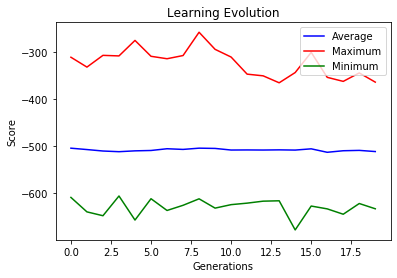

In [5]:
plotLearningEvolution(generationAverage, generationMax, generationMin)

Por último, executamos 20 gerações para o layout originalClassic:

In [6]:
generation = createGeneration()
generationAverage, generationMax, generationMin, originalClassicStrategy = runGeneticLearning("originalClassic", generation)

layout:  originalClassic
Pacman died! Score: -467
Pacman died! Score: -547
Pacman died! Score: -517
Pacman died! Score: -558
Pacman died! Score: -510
Average Score: -519.8
Scores:        -467.0, -547.0, -517.0, -558.0, -510.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -614
Pacman died! Score: -673
Pacman died! Score: -604
Pacman died! Score: -571
Pacman died! Score: -587
Average Score: -609.8
Scores:        -614.0, -673.0, -604.0, -571.0, -587.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -765
Pacman died! Score: -589
Pacman died! Score: -613
Pacman died! Score: -611
Pacman died! Score: -568
Average Score: -629.2
Scores:        -765.0, -589.0, -613.0, -611.0, -568.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -639
Pacman died! Score: -567
Pacman died! Score: -1010
Pacman died

Pacman died! Score: -358
Pacman died! Score: -345
Pacman died! Score: -399
Pacman died! Score: -399
Pacman died! Score: -457
Average Score: -391.6
Scores:        -358.0, -345.0, -399.0, -399.0, -457.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -659
Pacman died! Score: -439
Pacman died! Score: -458
Pacman died! Score: -430
Pacman died! Score: -481
Average Score: -493.4
Scores:        -659.0, -439.0, -458.0, -430.0, -481.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -466
Pacman died! Score: -455
Pacman died! Score: -545
Pacman died! Score: -421
Pacman died! Score: -548
Average Score: -487.0
Scores:        -466.0, -455.0, -545.0, -421.0, -548.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -591
Pacman died! Score: -394
Pacman died! Score: -421
Pacman died! Score: -585
Pacman died!

KeyboardInterrupt: 

In [ ]:
plotLearningEvolution(generationAverage, generationMax, generationMin)